In [1]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt

In [2]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [4]:
cd /export/usuarios_ml4ds/lbartolome/topicmodeler

/export/usuarios_ml4ds/lbartolome/topicmodeler


In [5]:
from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [6]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

## **1. Creation of synthetic corpus functions**


---

In [7]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [8]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [9]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [10]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_distribution()
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [11]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    avitm = AVITM(logger=None,
              input_size=input_size,
              n_components=n_topics,
              model_type="prodLDA",
              hidden_sizes=(100, 100),
              activation='softplus',
              dropout=0.2,
              learn_priors=True,
              batch_size=64,
              lr=2e-3,
              momentum=0.99,
              solver='adam',
              num_epochs=100,
              reduce_on_plateau=False,
              topic_prior_mean=0.0,
              topic_prior_variance=None,
              num_samples=20,
              num_data_loader_workers=0,
              verbose=True)
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [12]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [13]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [14]:
n_nodes = 5

In [15]:
1e-1

0.1

In [16]:
1e-2

0.01

In [17]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 5/n_topics
n_docs = 1000
n_docs_inf = 1000
n_docs_global_inf = 1000#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [18]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [19]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []

for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_distribution()
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_distribution()
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = thetas_inf
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 40.85it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.05it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.64it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 41.72it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.17it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.24s/it][2022-10-09 11:30:07,501] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1689.955078125	Time: 0:00:00.819653
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1744.1834791666668	Time: 0:00:00.819653: : 1it [00:02,  1.24s/it]                           

Validation loss decreased (inf --> 1689.955078).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1744.1834791666668	Time: 0:00:00.819653: : 2it [00:03,  1.94s/it][2022-10-09 11:30:09,975] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1579.977875	Time: 0:00:00.859851
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1635.6437791666667	Time: 0:00:00.859851: : 2it [00:04,  1.94s/it]                        

Validation loss decreased (1689.955078 --> 1579.977875).  Saving model ...


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1635.6437791666667	Time: 0:00:00.859851: : 3it [00:05,  2.06s/it][2022-10-09 11:30:12,154] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1547.4833	Time: 0:00:00.832307
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1588.6774708333332	Time: 0:00:00.832307: : 3it [00:06,  2.06s/it]                      

Validation loss decreased (1579.977875 --> 1547.483300).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1588.6774708333332	Time: 0:00:00.832307: : 4it [00:08,  2.11s/it][2022-10-09 11:30:14,371] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1520.55956875	Time: 0:00:00.860189
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1562.571884375	Time: 0:00:00.860189: : 4it [00:08,  2.11s/it]                          

Validation loss decreased (1547.483300 --> 1520.559569).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1562.571884375	Time: 0:00:00.860189: : 5it [00:10,  2.14s/it][2022-10-09 11:30:16,533] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1503.655190625	Time: 0:00:00.833134
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1541.1811739583334	Time: 0:00:00.833134: : 5it [00:11,  2.14s/it]                           

Validation loss decreased (1520.559569 --> 1503.655191).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1541.1811739583334	Time: 0:00:00.833134: : 6it [00:12,  2.14s/it][2022-10-09 11:30:18,701] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1487.480525	Time: 0:00:00.851128
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1526.5420375	Time: 0:00:00.851128: : 6it [00:13,  2.14s/it]                        

Validation loss decreased (1503.655191 --> 1487.480525).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1526.5420375	Time: 0:00:00.851128: : 7it [00:14,  2.16s/it][2022-10-09 11:30:20,903] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1479.266990625	Time: 0:00:00.848990
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1513.5779458333334	Time: 0:00:00.848990: : 7it [00:15,  2.16s/it]                           

Validation loss decreased (1487.480525 --> 1479.266991).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1513.5779458333334	Time: 0:00:00.848990: : 8it [00:16,  2.18s/it][2022-10-09 11:30:23,109] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1468.493609375	Time: 0:00:00.852449
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1504.7665354166666	Time: 0:00:00.852449: : 8it [00:17,  2.18s/it]                           

Validation loss decreased (1479.266991 --> 1468.493609).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1504.7665354166666	Time: 0:00:00.852449: : 9it [00:19,  2.19s/it][2022-10-09 11:30:25,362] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1461.0909	Time: 0:00:00.885513
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1497.3569375	Time: 0:00:00.885513: : 9it [00:19,  2.19s/it]                      

Validation loss decreased (1468.493609 --> 1461.090900).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1497.3569375	Time: 0:00:00.885513: : 10it [00:21,  2.20s/it][2022-10-09 11:30:27,551] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1445.58085	Time: 0:00:00.844719
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1490.0463583333333	Time: 0:00:00.844719: : 10it [00:22,  2.20s/it]                       

Validation loss decreased (1461.090900 --> 1445.580850).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1490.0463583333333	Time: 0:00:00.844719: : 11it [00:23,  2.22s/it][2022-10-09 11:30:29,855] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1441.086671875	Time: 0:00:00.899723
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1483.2920833333333	Time: 0:00:00.899723: : 11it [00:24,  2.22s/it]                           

Validation loss decreased (1445.580850 --> 1441.086672).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1483.2920833333333	Time: 0:00:00.899723: : 12it [00:25,  2.23s/it][2022-10-09 11:30:32,066] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1437.79485625	Time: 0:00:00.863410
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1480.1036177083333	Time: 0:00:00.863410: : 12it [00:26,  2.23s/it]                          

Validation loss decreased (1441.086672 --> 1437.794856).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1480.1036177083333	Time: 0:00:00.863410: : 13it [00:27,  2.22s/it][2022-10-09 11:30:34,244] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1431.440640625	Time: 0:00:00.833802
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1477.23860625	Time: 0:00:00.833802: : 13it [00:28,  2.22s/it]                           

Validation loss decreased (1437.794856 --> 1431.440641).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1477.23860625	Time: 0:00:00.833802: : 14it [00:30,  2.23s/it][2022-10-09 11:30:36,465] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1430.043984375	Time: 0:00:00.812738
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1469.34986875	Time: 0:00:00.812738: : 14it [00:31,  2.23s/it]                           

Validation loss decreased (1431.440641 --> 1430.043984).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1469.34986875	Time: 0:00:00.812738: : 15it [00:32,  2.21s/it][2022-10-09 11:30:38,690] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1424.302909375	Time: 0:00:00.874183
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1468.1508072916668	Time: 0:00:00.874183: : 15it [00:33,  2.21s/it]                           

Validation loss decreased (1430.043984 --> 1424.302909).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1468.1508072916668	Time: 0:00:00.874183: : 16it [00:34,  2.21s/it][2022-10-09 11:30:40,938] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1420.2509625	Time: 0:00:00.893926
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1464.1110833333332	Time: 0:00:00.893926: : 16it [00:35,  2.21s/it]                         

Validation loss decreased (1424.302909 --> 1420.250963).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1464.1110833333332	Time: 0:00:00.893926: : 17it [00:36,  2.23s/it][2022-10-09 11:30:43,205] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1422.074271875	Time: 0:00:00.885431
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1462.3070229166667	Time: 0:00:00.885431: : 17it [00:37,  2.23s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1462.3070229166667	Time: 0:00:00.885431: : 18it [00:39,  2.23s/it][2022-10-09 11:30:45,422] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1417.442740625	Time: 0:00:00.870753
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1459.8654833333333	Time: 0:00:00.870753: : 18it [00:39,  2.23s/it]                           

Validation loss decreased (1420.250963 --> 1417.442741).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1459.8654833333333	Time: 0:00:00.870753: : 19it [00:41,  2.23s/it][2022-10-09 11:30:47,660] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1412.914775	Time: 0:00:00.869035
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1455.79596875	Time: 0:00:00.869035: : 19it [00:42,  2.23s/it]                        

Validation loss decreased (1417.442741 --> 1412.914775).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1455.79596875	Time: 0:00:00.869035: : 20it [00:43,  2.25s/it][2022-10-09 11:30:49,938] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1416.87605625	Time: 0:00:00.856556
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1456.8428833333332	Time: 0:00:00.856556: : 20it [00:44,  2.25s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1456.8428833333332	Time: 0:00:00.856556: : 21it [00:45,  2.24s/it][2022-10-09 11:30:52,125] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1411.8123875	Time: 0:00:00.838821
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1451.142228125	Time: 0:00:00.838821: : 21it [00:46,  2.24s/it]                         

Validation loss decreased (1412.914775 --> 1411.812388).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1451.142228125	Time: 0:00:00.838821: : 22it [00:48,  2.25s/it][2022-10-09 11:30:54,411] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1410.65121875	Time: 0:00:00.831237
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1451.6953375	Time: 0:00:00.831237: : 22it [00:48,  2.25s/it]                          

Validation loss decreased (1411.812388 --> 1410.651219).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1451.6953375	Time: 0:00:00.831237: : 23it [00:50,  2.24s/it][2022-10-09 11:30:56,633] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1407.91519375	Time: 0:00:00.856355
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1451.4081510416668	Time: 0:00:00.856355: : 23it [00:51,  2.24s/it]                          

Validation loss decreased (1410.651219 --> 1407.915194).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1451.4081510416668	Time: 0:00:00.856355: : 24it [00:52,  2.24s/it][2022-10-09 11:30:58,884] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1396.58575	Time: 0:00:00.863910
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1449.18796875	Time: 0:00:00.863910: : 24it [00:53,  2.24s/it]                       

Validation loss decreased (1407.915194 --> 1396.585750).  Saving model ...


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1449.18796875	Time: 0:00:00.863910: : 25it [00:54,  2.24s/it][2022-10-09 11:31:01,126] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1403.15534375	Time: 0:00:00.876601
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1446.054440625	Time: 0:00:00.876601: : 25it [00:55,  2.24s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1446.054440625	Time: 0:00:00.876601: : 26it [00:57,  2.24s/it][2022-10-09 11:31:03,360] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1404.97399375	Time: 0:00:00.854243
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1446.8915197916667	Time: 0:00:00.854243: : 26it [00:57,  2.24s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1446.8915197916667	Time: 0:00:00.854243: : 27it [00:59,  2.24s/it][2022-10-09 11:31:05,571] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1402.58856875	Time: 0:00:00.839333
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1446.112565625	Time: 0:00:00.839333: : 27it [01:00,  2.24s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1446.112565625	Time: 0:00:00.839333: : 28it [01:01,  2.24s/it][2022-10-09 11:31:07,838] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1401.439803125	Time: 0:00:00.872090
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1445.75058125	Time: 0:00:00.872090: : 28it [01:02,  2.24s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1445.75058125	Time: 0:00:00.872090: : 29it [01:03,  2.23s/it][2022-10-09 11:31:10,019] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1404.581853125	Time: 0:00:00.848322
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1441.896390625	Valid Loss: 1404.581853125	Time: 0:00:00.848322: : 29it [01:04,  2.23s/it][2022-10-09 11:31:10,021] [avitm.py] [INFO] Early stopping
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1441.896390625	Valid Loss: 1404.581853125	Time: 0:00:00.848322: : 29it [01:04,  2.23s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.05it/s]


Tópicos (equivalentes) evaluados correctamente:
8.60512730852166


Sampling: [20/20]: : 20it [00:20,  1.03s/it]


Difference in evaluation of doc similarity:
2549.4220156503184
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:00,  1.10it/s][2022-10-09 11:32:58,107] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1571.25653125	Time: 0:00:00.802650
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1691.0707604166666	Time: 0:00:00.802650: : 1it [00:01,  1.10it/s]                          

Validation loss decreased (inf --> 1571.256531).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1691.0707604166666	Time: 0:00:00.802650: : 2it [00:02,  1.38s/it][2022-10-09 11:32:59,861] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1582.9688125	Time: 0:00:00.842641
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1655.2805729166666	Time: 0:00:00.842641: : 2it [00:03,  1.38s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1655.2805729166666	Time: 0:00:00.842641: : 3it [00:04,  1.56s/it][2022-10-09 11:33:01,608] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1590.69459375	Time: 0:00:00.829052
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1615.8415520833332	Time: 0:00:00.829052: : 3it [00:05,  1.56s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1615.8415520833332	Time: 0:00:00.829052: : 4it [00:06,  1.64s/it][2022-10-09 11:33:03,394] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1574.5151875	Time: 0:00:00.849898
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1575.3691770833334	Time: 0:00:00.849898: : 4it [00:07,  1.64s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1575.3691770833334	Time: 0:00:00.849898: : 5it [00:07,  1.69s/it][2022-10-09 11:33:05,187] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1539.2725625	Time: 0:00:00.862720
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1547.8158958333333	Time: 0:00:00.862720: : 5it [00:08,  1.69s/it]                         

Validation loss decreased (1571.256531 --> 1539.272563).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1547.8158958333333	Time: 0:00:00.862720: : 6it [00:09,  1.72s/it][2022-10-09 11:33:06,985] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1493.38934375	Time: 0:00:00.866425
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1524.3976770833333	Time: 0:00:00.866425: : 6it [00:10,  1.72s/it]                          

Validation loss decreased (1539.272563 --> 1493.389344).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1524.3976770833333	Time: 0:00:00.866425: : 7it [00:11,  1.77s/it][2022-10-09 11:33:08,853] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1465.60646875	Time: 0:00:00.866783
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1507.6017291666667	Time: 0:00:00.866783: : 7it [00:12,  1.77s/it]                          

Validation loss decreased (1493.389344 --> 1465.606469).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1507.6017291666667	Time: 0:00:00.866783: : 8it [00:13,  1.79s/it][2022-10-09 11:33:10,680] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1440.860625	Time: 0:00:00.878090
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1497.5756041666666	Time: 0:00:00.878090: : 8it [00:14,  1.79s/it]                        

Validation loss decreased (1465.606469 --> 1440.860625).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1497.5756041666666	Time: 0:00:00.878090: : 9it [00:15,  1.80s/it][2022-10-09 11:33:12,523] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1437.52984375	Time: 0:00:00.875781
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.76446875	Time: 0:00:00.875781: : 9it [00:16,  1.80s/it]                          

Validation loss decreased (1440.860625 --> 1437.529844).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.76446875	Time: 0:00:00.875781: : 10it [00:17,  1.82s/it][2022-10-09 11:33:14,395] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1424.592375	Time: 0:00:00.884127
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1468.8925729166667	Time: 0:00:00.884127: : 10it [00:18,  1.82s/it]                        

Validation loss decreased (1437.529844 --> 1424.592375).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1468.8925729166667	Time: 0:00:00.884127: : 11it [00:18,  1.84s/it][2022-10-09 11:33:16,284] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1423.49825	Time: 0:00:00.905831
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1465.2599895833334	Time: 0:00:00.905831: : 11it [00:19,  1.84s/it]                       

Validation loss decreased (1424.592375 --> 1423.498250).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1465.2599895833334	Time: 0:00:00.905831: : 12it [00:20,  1.86s/it][2022-10-09 11:33:18,196] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1417.3594375	Time: 0:00:00.912297
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1457.4055	Time: 0:00:00.912297: : 12it [00:21,  1.86s/it]                         

Validation loss decreased (1423.498250 --> 1417.359438).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1457.4055	Time: 0:00:00.912297: : 13it [00:22,  1.87s/it][2022-10-09 11:33:20,066] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1409.88253125	Time: 0:00:00.885495
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1449.38396875	Time: 0:00:00.885495: : 13it [00:23,  1.87s/it]                          

Validation loss decreased (1417.359438 --> 1409.882531).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1449.38396875	Time: 0:00:00.885495: : 14it [00:24,  1.87s/it][2022-10-09 11:33:21,940] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1410.35940625	Time: 0:00:00.887390
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1444.2247916666668	Time: 0:00:00.887390: : 14it [00:25,  1.87s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1444.2247916666668	Time: 0:00:00.887390: : 15it [00:26,  1.87s/it][2022-10-09 11:33:23,826] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1400.2314375	Time: 0:00:00.906459
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1439.9793229166667	Time: 0:00:00.906459: : 15it [00:27,  1.87s/it]                         

Validation loss decreased (1409.882531 --> 1400.231438).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1439.9793229166667	Time: 0:00:00.906459: : 16it [00:28,  1.88s/it][2022-10-09 11:33:25,741] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1396.17484375	Time: 0:00:00.918213
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1441.4126770833334	Time: 0:00:00.918213: : 16it [00:29,  1.88s/it]                          

Validation loss decreased (1400.231438 --> 1396.174844).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1441.4126770833334	Time: 0:00:00.918213: : 17it [00:30,  1.89s/it][2022-10-09 11:33:27,646] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1394.95028125	Time: 0:00:00.921240
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1431.17134375	Time: 0:00:00.921240: : 17it [00:31,  1.89s/it]                          

Validation loss decreased (1396.174844 --> 1394.950281).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1431.17134375	Time: 0:00:00.921240: : 18it [00:32,  1.89s/it][2022-10-09 11:33:29,702] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1398.29440625	Time: 0:00:01.065903
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1432.0472083333334	Time: 0:00:01.065903: : 18it [00:33,  1.89s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1432.0472083333334	Time: 0:00:01.065903: : 19it [00:34,  1.94s/it][2022-10-09 11:33:31,606] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1393.55484375	Time: 0:00:00.909601
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1426.5474375	Time: 0:00:00.909601: : 19it [00:35,  1.94s/it]                          

Validation loss decreased (1394.950281 --> 1393.554844).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1426.5474375	Time: 0:00:00.909601: : 20it [00:36,  1.94s/it][2022-10-09 11:33:33,536] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1389.2865	Time: 0:00:00.917358
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1425.9935729166666	Time: 0:00:00.917358: : 20it [00:37,  1.94s/it]                      

Validation loss decreased (1393.554844 --> 1389.286500).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1425.9935729166666	Time: 0:00:00.917358: : 21it [00:38,  1.93s/it][2022-10-09 11:33:35,463] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1384.01478125	Time: 0:00:00.925968
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1424.9845208333334	Time: 0:00:00.925968: : 21it [00:39,  1.93s/it]                          

Validation loss decreased (1389.286500 --> 1384.014781).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1424.9845208333334	Time: 0:00:00.925968: : 22it [00:40,  1.93s/it][2022-10-09 11:33:37,382] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1388.31053125	Time: 0:00:00.916100
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1423.5877291666666	Time: 0:00:00.916100: : 22it [00:40,  1.93s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1423.5877291666666	Time: 0:00:00.916100: : 23it [00:41,  1.93s/it][2022-10-09 11:33:39,300] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1387.92184375	Time: 0:00:00.917223
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1419.9771041666668	Time: 0:00:00.917223: : 23it [00:42,  1.93s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1419.9771041666668	Time: 0:00:00.917223: : 24it [00:43,  1.93s/it][2022-10-09 11:33:41,227] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1392.13290625	Time: 0:00:00.920875
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1421.124046875	Time: 0:00:00.920875: : 24it [00:44,  1.93s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1421.124046875	Time: 0:00:00.920875: : 25it [00:45,  1.93s/it][2022-10-09 11:33:43,158] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1384.779	Time: 0:00:00.921791
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1417.5426041666667	Time: 0:00:00.921791: : 25it [00:46,  1.93s/it]                     

EarlyStopping counter: 4 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1417.5426041666667	Time: 0:00:00.921791: : 26it [00:47,  1.93s/it][2022-10-09 11:33:45,074] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1388.929125	Time: 0:00:00.907669
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1414.2990885416666	Valid Loss: 1388.929125	Time: 0:00:00.907669: : 26it [00:48,  1.93s/it][2022-10-09 11:33:45,077] [avitm.py] [INFO] Early stopping
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1414.2990885416666	Valid Loss: 1388.929125	Time: 0:00:00.907669: : 26it [00:48,  1.87s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.09it/s]


Tópicos (equivalentes) evaluados correctamente:
6.397787591201496


Sampling: [20/20]: : 20it [00:22,  1.11s/it]


Difference in evaluation of doc similarity:
3309.739397096313
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.05s/it][2022-10-09 11:35:06,395] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1591.6841875	Time: 0:00:00.934057
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1691.8559166666666	Time: 0:00:00.934057: : 1it [00:01,  1.05s/it]                         

Validation loss decreased (inf --> 1591.684188).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1691.8559166666666	Time: 0:00:00.934057: : 2it [00:03,  1.58s/it][2022-10-09 11:35:08,341] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1603.41996875	Time: 0:00:00.926178
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1652.304625	Time: 0:00:00.926178: : 2it [00:03,  1.58s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1652.304625	Time: 0:00:00.926178: : 3it [00:04,  1.75s/it][2022-10-09 11:35:10,314] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1610.94259375	Time: 0:00:00.949480
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1608.007625	Time: 0:00:00.949480: : 3it [00:05,  1.75s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1608.007625	Time: 0:00:00.949480: : 4it [00:06,  1.84s/it][2022-10-09 11:35:12,267] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1595.468625	Time: 0:00:00.935849
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1574.5747291666667	Time: 0:00:00.935849: : 4it [00:07,  1.84s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1574.5747291666667	Time: 0:00:00.935849: : 5it [00:08,  1.88s/it][2022-10-09 11:35:14,216] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1560.60578125	Time: 0:00:00.932021
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1544.0314166666667	Time: 0:00:00.932021: : 5it [00:09,  1.88s/it]                          

Validation loss decreased (1591.684188 --> 1560.605781).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1544.0314166666667	Time: 0:00:00.932021: : 6it [00:10,  1.90s/it][2022-10-09 11:35:16,304] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1518.30365625	Time: 0:00:01.076264
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1519.7145520833333	Time: 0:00:01.076264: : 6it [00:11,  1.90s/it]                          

Validation loss decreased (1560.605781 --> 1518.303656).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1519.7145520833333	Time: 0:00:01.076264: : 7it [00:12,  1.97s/it][2022-10-09 11:35:18,287] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1488.27003125	Time: 0:00:00.950293
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1503.8128125	Time: 0:00:00.950293: : 7it [00:13,  1.97s/it]                          

Validation loss decreased (1518.303656 --> 1488.270031).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1503.8128125	Time: 0:00:00.950293: : 8it [00:14,  1.97s/it][2022-10-09 11:35:20,236] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1472.6355	Time: 0:00:00.913368
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1495.9422708333334	Time: 0:00:00.913368: : 8it [00:15,  1.97s/it]                      

Validation loss decreased (1488.270031 --> 1472.635500).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1495.9422708333334	Time: 0:00:00.913368: : 9it [00:16,  1.96s/it][2022-10-09 11:35:22,174] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1450.4780625	Time: 0:00:00.932702
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.6939895833334	Time: 0:00:00.932702: : 9it [00:17,  1.96s/it]                         

Validation loss decreased (1472.635500 --> 1450.478063).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.6939895833334	Time: 0:00:00.932702: : 10it [00:18,  1.96s/it][2022-10-09 11:35:24,142] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1442.363125	Time: 0:00:00.924273
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1471.7600520833332	Time: 0:00:00.924273: : 10it [00:19,  1.96s/it]                        

Validation loss decreased (1450.478063 --> 1442.363125).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1471.7600520833332	Time: 0:00:00.924273: : 11it [00:20,  1.96s/it][2022-10-09 11:35:26,133] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1430.879625	Time: 0:00:00.950213
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1464.8171770833333	Time: 0:00:00.950213: : 11it [00:21,  1.96s/it]                        

Validation loss decreased (1442.363125 --> 1430.879625).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1464.8171770833333	Time: 0:00:00.950213: : 12it [00:22,  1.97s/it][2022-10-09 11:35:28,093] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1436.66309375	Time: 0:00:00.912474
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1453.44696875	Time: 0:00:00.912474: : 12it [00:23,  1.97s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1453.44696875	Time: 0:00:00.912474: : 13it [00:24,  1.96s/it][2022-10-09 11:35:30,036] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1423.3835625	Time: 0:00:00.914127
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1449.4214583333332	Time: 0:00:00.914127: : 13it [00:25,  1.96s/it]                         

Validation loss decreased (1430.879625 --> 1423.383562).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1449.4214583333332	Time: 0:00:00.914127: : 14it [00:26,  1.96s/it][2022-10-09 11:35:32,030] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1421.3261875	Time: 0:00:00.946692
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1440.37771875	Time: 0:00:00.946692: : 14it [00:27,  1.96s/it]                         

Validation loss decreased (1423.383562 --> 1421.326188).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1440.37771875	Time: 0:00:00.946692: : 15it [00:28,  1.97s/it][2022-10-09 11:35:34,003] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1419.7411875	Time: 0:00:00.932041
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1435.59021875	Time: 0:00:00.932041: : 15it [00:29,  1.97s/it]                         

Validation loss decreased (1421.326188 --> 1419.741188).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1435.59021875	Time: 0:00:00.932041: : 16it [00:30,  1.97s/it][2022-10-09 11:35:35,952] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1413.03196875	Time: 0:00:00.911611
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1434.9795520833334	Time: 0:00:00.911611: : 16it [00:31,  1.97s/it]                          

Validation loss decreased (1419.741188 --> 1413.031969).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1434.9795520833334	Time: 0:00:00.911611: : 17it [00:32,  1.96s/it][2022-10-09 11:35:37,909] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1405.35728125	Time: 0:00:00.934489
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1433.33621875	Time: 0:00:00.934489: : 17it [00:33,  1.96s/it]                          

Validation loss decreased (1413.031969 --> 1405.357281).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1433.33621875	Time: 0:00:00.934489: : 18it [00:34,  1.97s/it][2022-10-09 11:35:39,874] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1406.1484375	Time: 0:00:00.920432
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1430.474421875	Time: 0:00:00.920432: : 18it [00:35,  1.97s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1430.474421875	Time: 0:00:00.920432: : 19it [00:36,  1.96s/it][2022-10-09 11:35:41,842] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1408.6418125	Time: 0:00:00.935336
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1427.2159166666668	Time: 0:00:00.935336: : 19it [00:37,  1.96s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1427.2159166666668	Time: 0:00:00.935336: : 20it [00:38,  1.96s/it][2022-10-09 11:35:43,787] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1405.35359375	Time: 0:00:00.928040
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1422.071375	Time: 0:00:00.928040: : 20it [00:39,  1.96s/it]                          

Validation loss decreased (1405.357281 --> 1405.353594).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1422.071375	Time: 0:00:00.928040: : 21it [00:40,  1.96s/it][2022-10-09 11:35:45,757] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1399.115125	Time: 0:00:00.922480
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1418.5030729166667	Time: 0:00:00.922480: : 21it [00:41,  1.96s/it]                        

Validation loss decreased (1405.353594 --> 1399.115125).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1418.5030729166667	Time: 0:00:00.922480: : 22it [00:42,  1.96s/it][2022-10-09 11:35:47,711] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1395.37434375	Time: 0:00:00.927564
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1415.739625	Time: 0:00:00.927564: : 22it [00:43,  1.96s/it]                          

Validation loss decreased (1399.115125 --> 1395.374344).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1415.739625	Time: 0:00:00.927564: : 23it [00:44,  1.95s/it][2022-10-09 11:35:49,646] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1399.628125	Time: 0:00:00.924166
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1414.6630677083333	Time: 0:00:00.924166: : 23it [00:45,  1.95s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1414.6630677083333	Time: 0:00:00.924166: : 24it [00:46,  1.96s/it][2022-10-09 11:35:51,629] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1395.02621875	Time: 0:00:00.941534
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1416.33996875	Time: 0:00:00.941534: : 24it [00:47,  1.96s/it]                          

Validation loss decreased (1395.374344 --> 1395.026219).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1416.33996875	Time: 0:00:00.941534: : 25it [00:48,  1.96s/it][2022-10-09 11:35:53,600] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1404.44484375	Time: 0:00:00.931267
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1410.5702291666666	Time: 0:00:00.931267: : 25it [00:49,  1.96s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1410.5702291666666	Time: 0:00:00.931267: : 26it [00:50,  1.97s/it][2022-10-09 11:35:55,572] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1391.965375	Time: 0:00:00.930348
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1407.4190104166667	Time: 0:00:00.930348: : 26it [00:51,  1.97s/it]                        

Validation loss decreased (1395.026219 --> 1391.965375).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1407.4190104166667	Time: 0:00:00.930348: : 27it [00:52,  1.96s/it][2022-10-09 11:35:57,527] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1391.501125	Time: 0:00:00.924920
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1409.6248125	Time: 0:00:00.924920: : 27it [00:53,  1.96s/it]                        

Validation loss decreased (1391.965375 --> 1391.501125).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1409.6248125	Time: 0:00:00.924920: : 28it [00:54,  1.96s/it][2022-10-09 11:35:59,470] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1391.43315625	Time: 0:00:00.918742
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1401.8276875	Time: 0:00:00.918742: : 28it [00:55,  1.96s/it]                          

Validation loss decreased (1391.501125 --> 1391.433156).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1401.8276875	Time: 0:00:00.918742: : 29it [00:56,  1.96s/it][2022-10-09 11:36:01,437] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1396.49578125	Time: 0:00:00.936882
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1405.312078125	Time: 0:00:00.936882: : 29it [00:57,  1.96s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1405.312078125	Time: 0:00:00.936882: : 30it [00:58,  1.96s/it][2022-10-09 11:36:03,381] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1390.2384375	Time: 0:00:00.919846
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1405.0288125	Time: 0:00:00.919846: : 30it [00:58,  1.96s/it]                         

Validation loss decreased (1391.433156 --> 1390.238437).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1405.0288125	Time: 0:00:00.919846: : 31it [01:00,  1.96s/it][2022-10-09 11:36:05,345] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1394.2795	Time: 0:00:00.930696
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1402.431890625	Time: 0:00:00.930696: : 31it [01:00,  1.96s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1402.431890625	Time: 0:00:00.930696: : 32it [01:01,  1.95s/it][2022-10-09 11:36:07,297] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1398.89703125	Time: 0:00:00.935513
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1400.6372604166668	Time: 0:00:00.935513: : 32it [01:02,  1.95s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1400.6372604166668	Time: 0:00:00.935513: : 33it [01:03,  1.96s/it][2022-10-09 11:36:09,259] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1394.166875	Time: 0:00:00.935188
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1399.8699270833333	Time: 0:00:00.935188: : 33it [01:04,  1.96s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1399.8699270833333	Time: 0:00:00.935188: : 34it [01:05,  1.96s/it][2022-10-09 11:36:11,223] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1393.62909375	Time: 0:00:00.935634
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1401.0710677083334	Time: 0:00:00.935634: : 34it [01:06,  1.96s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1401.0710677083334	Time: 0:00:00.935634: : 35it [01:07,  1.96s/it][2022-10-09 11:36:13,193] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1390.16990625	Time: 0:00:00.930341
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1395.4736041666667	Time: 0:00:00.930341: : 35it [01:08,  1.96s/it]                          

Validation loss decreased (1390.238437 --> 1390.169906).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1395.4736041666667	Time: 0:00:00.930341: : 36it [01:09,  1.95s/it][2022-10-09 11:36:15,126] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1387.6595625	Time: 0:00:00.930990
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1393.6694895833334	Time: 0:00:00.930990: : 36it [01:10,  1.95s/it]                         

Validation loss decreased (1390.169906 --> 1387.659562).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1393.6694895833334	Time: 0:00:00.930990: : 37it [01:11,  1.96s/it][2022-10-09 11:36:17,115] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1386.06465625	Time: 0:00:00.956956
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1393.988984375	Time: 0:00:00.956956: : 37it [01:12,  1.96s/it]                          

Validation loss decreased (1387.659562 --> 1386.064656).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1393.988984375	Time: 0:00:00.956956: : 38it [01:13,  1.97s/it][2022-10-09 11:36:19,076] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1384.82053125	Time: 0:00:00.930691
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1395.3818125	Time: 0:00:00.930691: : 38it [01:14,  1.97s/it]                          

Validation loss decreased (1386.064656 --> 1384.820531).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1395.3818125	Time: 0:00:00.930691: : 39it [01:15,  1.96s/it][2022-10-09 11:36:21,029] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1382.5098125	Time: 0:00:00.939396
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1393.3104791666667	Time: 0:00:00.939396: : 39it [01:16,  1.96s/it]                         

Validation loss decreased (1384.820531 --> 1382.509812).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1393.3104791666667	Time: 0:00:00.939396: : 40it [01:17,  1.97s/it][2022-10-09 11:36:23,000] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1386.0399375	Time: 0:00:00.932810
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1394.0133541666667	Time: 0:00:00.932810: : 40it [01:18,  1.97s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1394.0133541666667	Time: 0:00:00.932810: : 41it [01:19,  1.96s/it][2022-10-09 11:36:24,962] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1385.277875	Time: 0:00:00.941077
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1393.5417291666668	Time: 0:00:00.941077: : 41it [01:20,  1.96s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1393.5417291666668	Time: 0:00:00.941077: : 42it [01:21,  1.96s/it][2022-10-09 11:36:26,900] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1385.95890625	Time: 0:00:00.922827
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1393.0416875	Time: 0:00:00.922827: : 42it [01:22,  1.96s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1393.0416875	Time: 0:00:00.922827: : 43it [01:23,  1.96s/it][2022-10-09 11:36:28,871] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1383.95384375	Time: 0:00:00.930983
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1386.120578125	Time: 0:00:00.930983: : 43it [01:24,  1.96s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1386.120578125	Time: 0:00:00.930983: : 44it [01:25,  1.96s/it][2022-10-09 11:36:30,800] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1388.53990625	Time: 0:00:00.914783
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1388.9721875	Valid Loss: 1388.53990625	Time: 0:00:00.914783: : 44it [01:26,  1.96s/it][2022-10-09 11:36:30,802] [avitm.py] [INFO] Early stopping
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1388.9721875	Valid Loss: 1388.53990625	Time: 0:00:00.914783: : 44it [01:26,  1.96s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.07it/s]


Tópicos (equivalentes) evaluados correctamente:
6.5533893892991735


Sampling: [20/20]: : 20it [00:22,  1.15s/it]


Difference in evaluation of doc similarity:
3328.207486921599
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.03s/it][2022-10-09 11:37:53,611] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1580.204	Time: 0:00:00.932360
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1689.250125	Time: 0:00:00.932360: : 1it [00:01,  1.03s/it]                     

Validation loss decreased (inf --> 1580.204000).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1689.250125	Time: 0:00:00.932360: : 2it [00:02,  1.58s/it][2022-10-09 11:37:55,588] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1589.2066875	Time: 0:00:00.945747
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1655.53365625	Time: 0:00:00.945747: : 2it [00:03,  1.58s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1655.53365625	Time: 0:00:00.945747: : 3it [00:04,  1.76s/it][2022-10-09 11:37:57,556] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1597.169625	Time: 0:00:00.944215
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1613.7720208333333	Time: 0:00:00.944215: : 3it [00:05,  1.76s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1613.7720208333333	Time: 0:00:00.944215: : 4it [00:06,  1.85s/it][2022-10-09 11:37:59,537] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1581.294375	Time: 0:00:00.934035
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1574.7604270833333	Time: 0:00:00.934035: : 4it [00:07,  1.85s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1574.7604270833333	Time: 0:00:00.934035: : 5it [00:08,  1.89s/it][2022-10-09 11:38:01,491] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1551.4723125	Time: 0:00:00.920243
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1547.2647291666667	Time: 0:00:00.920243: : 5it [00:09,  1.89s/it]                         

Validation loss decreased (1580.204000 --> 1551.472313).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1547.2647291666667	Time: 0:00:00.920243: : 6it [00:10,  1.91s/it][2022-10-09 11:38:03,456] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1502.00003125	Time: 0:00:00.942917
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1525.7856458333333	Time: 0:00:00.942917: : 6it [00:11,  1.91s/it]                          

Validation loss decreased (1551.472313 --> 1502.000031).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1525.7856458333333	Time: 0:00:00.942917: : 7it [00:12,  1.93s/it][2022-10-09 11:38:05,437] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1473.44871875	Time: 0:00:00.946060
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1507.5694895833333	Time: 0:00:00.946060: : 7it [00:13,  1.93s/it]                          

Validation loss decreased (1502.000031 --> 1473.448719).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1507.5694895833333	Time: 0:00:00.946060: : 8it [00:14,  1.95s/it][2022-10-09 11:38:07,403] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1454.5708125	Time: 0:00:00.926482
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1496.1996666666666	Time: 0:00:00.926482: : 8it [00:15,  1.95s/it]                         

Validation loss decreased (1473.448719 --> 1454.570813).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1496.1996666666666	Time: 0:00:00.926482: : 9it [00:16,  1.95s/it][2022-10-09 11:38:09,353] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1436.14834375	Time: 0:00:00.928332
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1484.4914479166666	Time: 0:00:00.928332: : 9it [00:17,  1.95s/it]                          

Validation loss decreased (1454.570813 --> 1436.148344).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1484.4914479166666	Time: 0:00:00.928332: : 10it [00:18,  1.95s/it][2022-10-09 11:38:11,328] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1438.15384375	Time: 0:00:00.944794
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1477.81034375	Time: 0:00:00.944794: : 10it [00:19,  1.95s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1477.81034375	Time: 0:00:00.944794: : 11it [00:20,  1.96s/it][2022-10-09 11:38:13,301] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1424.35	Time: 0:00:00.946112
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1469.7472708333332	Time: 0:00:00.946112: : 11it [00:21,  1.96s/it]                    

Validation loss decreased (1436.148344 --> 1424.350000).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1469.7472708333332	Time: 0:00:00.946112: : 12it [00:22,  1.96s/it][2022-10-09 11:38:15,279] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1414.14075	Time: 0:00:00.957799
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1462.225375	Time: 0:00:00.957799: : 12it [00:23,  1.96s/it]                       

Validation loss decreased (1424.350000 --> 1414.140750).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1462.225375	Time: 0:00:00.957799: : 13it [00:24,  1.97s/it][2022-10-09 11:38:17,233] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1407.88934375	Time: 0:00:00.917893
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1452.1424010416667	Time: 0:00:00.917893: : 13it [00:25,  1.97s/it]                          

Validation loss decreased (1414.140750 --> 1407.889344).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1452.1424010416667	Time: 0:00:00.917893: : 14it [00:26,  1.97s/it][2022-10-09 11:38:19,217] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1408.8636875	Time: 0:00:00.933055
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1449.98646875	Time: 0:00:00.933055: : 14it [00:27,  1.97s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1449.98646875	Time: 0:00:00.933055: : 15it [00:28,  1.97s/it][2022-10-09 11:38:21,180] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1397.68315625	Time: 0:00:00.932393
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1445.5110729166668	Time: 0:00:00.932393: : 15it [00:29,  1.97s/it]                          

Validation loss decreased (1407.889344 --> 1397.683156).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1445.5110729166668	Time: 0:00:00.932393: : 16it [00:30,  1.97s/it][2022-10-09 11:38:23,148] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1399.633375	Time: 0:00:00.927618
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1443.84546875	Time: 0:00:00.927618: : 16it [00:31,  1.97s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1443.84546875	Time: 0:00:00.927618: : 17it [00:32,  1.97s/it][2022-10-09 11:38:25,123] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1391.35625	Time: 0:00:00.939836
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1428.1104270833334	Time: 0:00:00.939836: : 17it [00:33,  1.97s/it]                       

Validation loss decreased (1397.683156 --> 1391.356250).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1428.1104270833334	Time: 0:00:00.939836: : 18it [00:34,  1.98s/it][2022-10-09 11:38:27,144] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1399.82159375	Time: 0:00:00.948640
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1432.4969375	Time: 0:00:00.948640: : 18it [00:35,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1432.4969375	Time: 0:00:00.948640: : 19it [00:36,  1.99s/it][2022-10-09 11:38:29,124] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1388.28028125	Time: 0:00:00.928116
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1425.086953125	Time: 0:00:00.928116: : 19it [00:37,  1.99s/it]                          

Validation loss decreased (1391.356250 --> 1388.280281).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1425.086953125	Time: 0:00:00.928116: : 20it [00:38,  1.97s/it][2022-10-09 11:38:31,076] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1390.621125	Time: 0:00:00.944669
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1420.397890625	Time: 0:00:00.944669: : 20it [00:39,  1.97s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1420.397890625	Time: 0:00:00.944669: : 21it [00:40,  1.97s/it][2022-10-09 11:38:33,054] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1389.5340625	Time: 0:00:00.952903
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1414.2556458333333	Time: 0:00:00.952903: : 21it [00:41,  1.97s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1414.2556458333333	Time: 0:00:00.952903: : 22it [00:42,  1.98s/it][2022-10-09 11:38:35,041] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1385.94175	Time: 0:00:00.931811
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1417.8903697916667	Time: 0:00:00.931811: : 22it [00:43,  1.98s/it]                       

Validation loss decreased (1388.280281 --> 1385.941750).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1417.8903697916667	Time: 0:00:00.931811: : 23it [00:44,  1.98s/it][2022-10-09 11:38:37,033] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1378.5820625	Time: 0:00:00.942856
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1410.644640625	Time: 0:00:00.942856: : 23it [00:45,  1.98s/it]                         

Validation loss decreased (1385.941750 --> 1378.582062).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1410.644640625	Time: 0:00:00.942856: : 24it [00:46,  1.98s/it][2022-10-09 11:38:39,009] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1388.08521875	Time: 0:00:00.948289
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1416.6309427083334	Time: 0:00:00.948289: : 24it [00:47,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1416.6309427083334	Time: 0:00:00.948289: : 25it [00:48,  1.99s/it][2022-10-09 11:38:41,015] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1378.90225	Time: 0:00:00.951731
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1415.6560104166667	Time: 0:00:00.951731: : 25it [00:49,  1.99s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1415.6560104166667	Time: 0:00:00.951731: : 26it [00:50,  1.99s/it][2022-10-09 11:38:42,994] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1377.69175	Time: 0:00:00.941888
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1410.3967916666666	Time: 0:00:00.941888: : 26it [00:51,  1.99s/it]                       

Validation loss decreased (1378.582062 --> 1377.691750).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1410.3967916666666	Time: 0:00:00.941888: : 27it [00:52,  1.99s/it][2022-10-09 11:38:44,964] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1374.5093125	Time: 0:00:00.924198
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1408.6013020833334	Time: 0:00:00.924198: : 27it [00:53,  1.99s/it]                         

Validation loss decreased (1377.691750 --> 1374.509313).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1408.6013020833334	Time: 0:00:00.924198: : 28it [00:54,  1.98s/it][2022-10-09 11:38:46,939] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1378.1345625	Time: 0:00:00.936113
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1403.5973541666667	Time: 0:00:00.936113: : 28it [00:55,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1403.5973541666667	Time: 0:00:00.936113: : 29it [00:56,  1.98s/it][2022-10-09 11:38:48,904] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1378.315875	Time: 0:00:00.921291
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1405.70153125	Time: 0:00:00.921291: : 29it [00:57,  1.98s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1405.70153125	Time: 0:00:00.921291: : 30it [00:58,  2.02s/it][2022-10-09 11:38:51,019] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1377.2585625	Time: 0:00:00.922619
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1397.3706354166666	Time: 0:00:00.922619: : 30it [00:59,  2.02s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1397.3706354166666	Time: 0:00:00.922619: : 31it [01:00,  2.00s/it][2022-10-09 11:38:52,983] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1373.131375	Time: 0:00:00.934999
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1402.808921875	Time: 0:00:00.934999: : 31it [01:01,  2.00s/it]                        

Validation loss decreased (1374.509313 --> 1373.131375).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1402.808921875	Time: 0:00:00.934999: : 32it [01:02,  1.99s/it][2022-10-09 11:38:54,954] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1368.70490625	Time: 0:00:00.945240
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1398.8109479166667	Time: 0:00:00.945240: : 32it [01:03,  1.99s/it]                          

Validation loss decreased (1373.131375 --> 1368.704906).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1398.8109479166667	Time: 0:00:00.945240: : 33it [01:04,  1.98s/it][2022-10-09 11:38:56,915] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1378.134375	Time: 0:00:00.938970
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1395.6532864583332	Time: 0:00:00.938970: : 33it [01:05,  1.98s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1395.6532864583332	Time: 0:00:00.938970: : 34it [01:06,  1.98s/it][2022-10-09 11:38:58,874] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1373.575125	Time: 0:00:00.936181
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1398.2313802083333	Time: 0:00:00.936181: : 34it [01:07,  1.98s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1398.2313802083333	Time: 0:00:00.936181: : 35it [01:08,  1.97s/it][2022-10-09 11:39:00,840] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1374.59240625	Time: 0:00:00.938116
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1396.1346666666666	Time: 0:00:00.938116: : 35it [01:09,  1.97s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1396.1346666666666	Time: 0:00:00.938116: : 36it [01:10,  1.97s/it][2022-10-09 11:39:02,815] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1372.20296875	Time: 0:00:00.934814
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1394.45278125	Time: 0:00:00.934814: : 36it [01:11,  1.97s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1394.45278125	Time: 0:00:00.934814: : 37it [01:12,  1.97s/it][2022-10-09 11:39:04,774] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1371.26696875	Time: 0:00:00.924261
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1393.8791770833334	Valid Loss: 1371.26696875	Time: 0:00:00.924261: : 37it [01:13,  1.97s/it][2022-10-09 11:39:04,776] [avitm.py] [INFO] Early stopping
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1393.8791770833334	Valid Loss: 1371.26696875	Time: 0:00:00.924261: : 37it [01:13,  1.98s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.07it/s]


Tópicos (equivalentes) evaluados correctamente:
6.406438238510841


Sampling: [20/20]: : 20it [00:22,  1.14s/it]


Difference in evaluation of doc similarity:
3359.585269335895
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.03s/it][2022-10-09 11:40:26,003] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1577.11959375	Time: 0:00:00.935816
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1688.2113229166666	Time: 0:00:00.935816: : 1it [00:01,  1.03s/it]                          

Validation loss decreased (inf --> 1577.119594).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1688.2113229166666	Time: 0:00:00.935816: : 2it [00:03,  1.67s/it][2022-10-09 11:40:28,132] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1588.232875	Time: 0:00:00.942794
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1651.6135625	Time: 0:00:00.942794: : 2it [00:04,  1.67s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1651.6135625	Time: 0:00:00.942794: : 3it [00:05,  1.81s/it][2022-10-09 11:40:30,086] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1593.71240625	Time: 0:00:00.929493
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1610.4193541666666	Time: 0:00:00.929493: : 3it [00:06,  1.81s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1610.4193541666666	Time: 0:00:00.929493: : 4it [00:07,  1.87s/it][2022-10-09 11:40:32,063] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1580.44184375	Time: 0:00:00.943144
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1572.9497291666667	Time: 0:00:00.943144: : 4it [00:08,  1.87s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1572.9497291666667	Time: 0:00:00.943144: : 5it [00:09,  1.90s/it][2022-10-09 11:40:34,006] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1551.2608125	Time: 0:00:00.925582
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1546.7383958333332	Time: 0:00:00.925582: : 5it [00:09,  1.90s/it]                         

Validation loss decreased (1577.119594 --> 1551.260812).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1546.7383958333332	Time: 0:00:00.925582: : 6it [00:10,  1.92s/it][2022-10-09 11:40:35,976] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1509.20309375	Time: 0:00:00.949117
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1520.2911041666666	Time: 0:00:00.949117: : 6it [00:11,  1.92s/it]                          

Validation loss decreased (1551.260812 --> 1509.203094).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1520.2911041666666	Time: 0:00:00.949117: : 7it [00:12,  1.94s/it][2022-10-09 11:40:37,945] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1479.93815625	Time: 0:00:00.925934
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1504.5263229166667	Time: 0:00:00.925934: : 7it [00:13,  1.94s/it]                          

Validation loss decreased (1509.203094 --> 1479.938156).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1504.5263229166667	Time: 0:00:00.925934: : 8it [00:14,  1.94s/it][2022-10-09 11:40:39,926] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1462.59284375	Time: 0:00:00.957133
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1492.5309166666666	Time: 0:00:00.957133: : 8it [00:15,  1.94s/it]                          

Validation loss decreased (1479.938156 --> 1462.592844).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1492.5309166666666	Time: 0:00:00.957133: : 9it [00:16,  1.96s/it][2022-10-09 11:40:41,898] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1454.2069375	Time: 0:00:00.950840
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.4162083333333	Time: 0:00:00.950840: : 9it [00:17,  1.96s/it]                         

Validation loss decreased (1462.592844 --> 1454.206938).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.4162083333333	Time: 0:00:00.950840: : 10it [00:18,  1.97s/it][2022-10-09 11:40:43,872] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1443.140375	Time: 0:00:00.936400
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1471.6860520833334	Time: 0:00:00.936400: : 10it [00:19,  1.97s/it]                        

Validation loss decreased (1454.206938 --> 1443.140375).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1471.6860520833334	Time: 0:00:00.936400: : 11it [00:20,  1.97s/it][2022-10-09 11:40:45,846] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1439.4325	Time: 0:00:00.929259
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1467.5891770833334	Time: 0:00:00.929259: : 11it [00:21,  1.97s/it]                      

Validation loss decreased (1443.140375 --> 1439.432500).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1467.5891770833334	Time: 0:00:00.929259: : 12it [00:22,  1.97s/it][2022-10-09 11:40:47,835] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1434.63896875	Time: 0:00:00.944827
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1459.7429583333333	Time: 0:00:00.944827: : 12it [00:23,  1.97s/it]                          

Validation loss decreased (1439.432500 --> 1434.638969).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1459.7429583333333	Time: 0:00:00.944827: : 13it [00:24,  1.97s/it][2022-10-09 11:40:49,811] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1429.6110625	Time: 0:00:00.951018
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1457.8528229166666	Time: 0:00:00.951018: : 13it [00:25,  1.97s/it]                         

Validation loss decreased (1434.638969 --> 1429.611062).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1457.8528229166666	Time: 0:00:00.951018: : 14it [00:26,  1.98s/it][2022-10-09 11:40:51,820] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1425.0530625	Time: 0:00:00.952649
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1446.8814166666666	Time: 0:00:00.952649: : 14it [00:27,  1.98s/it]                         

Validation loss decreased (1429.611062 --> 1425.053062).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1446.8814166666666	Time: 0:00:00.952649: : 15it [00:28,  1.98s/it][2022-10-09 11:40:53,804] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1421.7095	Time: 0:00:00.946976
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1444.2569479166666	Time: 0:00:00.946976: : 15it [00:29,  1.98s/it]                      

Validation loss decreased (1425.053062 --> 1421.709500).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1444.2569479166666	Time: 0:00:00.946976: : 16it [00:30,  1.99s/it][2022-10-09 11:40:55,801] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1414.2564375	Time: 0:00:00.953822
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1435.60421875	Time: 0:00:00.953822: : 16it [00:31,  1.99s/it]                         

Validation loss decreased (1421.709500 --> 1414.256437).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1435.60421875	Time: 0:00:00.953822: : 17it [00:32,  1.99s/it][2022-10-09 11:40:57,791] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1423.4939375	Time: 0:00:00.946791
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1436.8315416666667	Time: 0:00:00.946791: : 17it [00:33,  1.99s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1436.8315416666667	Time: 0:00:00.946791: : 18it [00:34,  1.99s/it][2022-10-09 11:40:59,773] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1408.25546875	Time: 0:00:00.938187
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1431.5064479166667	Time: 0:00:00.938187: : 18it [00:35,  1.99s/it]                          

Validation loss decreased (1414.256437 --> 1408.255469).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1431.5064479166667	Time: 0:00:00.938187: : 19it [00:36,  1.98s/it][2022-10-09 11:41:01,750] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1405.6303125	Time: 0:00:00.956466
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1429.9013333333332	Time: 0:00:00.956466: : 19it [00:37,  1.98s/it]                         

Validation loss decreased (1408.255469 --> 1405.630312).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1429.9013333333332	Time: 0:00:00.956466: : 20it [00:38,  1.98s/it][2022-10-09 11:41:03,710] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1409.19025	Time: 0:00:00.933433
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1419.413375	Time: 0:00:00.933433: : 20it [00:39,  1.98s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1419.413375	Time: 0:00:00.933433: : 21it [00:40,  1.98s/it][2022-10-09 11:41:05,675] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1406.00703125	Time: 0:00:00.932632
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1421.288515625	Time: 0:00:00.932632: : 21it [00:41,  1.98s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1421.288515625	Time: 0:00:00.932632: : 22it [00:42,  1.97s/it][2022-10-09 11:41:07,647] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1403.61775	Time: 0:00:00.937689
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1422.3771041666666	Time: 0:00:00.937689: : 22it [00:43,  1.97s/it]                       

Validation loss decreased (1405.630312 --> 1403.617750).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1422.3771041666666	Time: 0:00:00.937689: : 23it [00:44,  1.97s/it][2022-10-09 11:41:09,613] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1400.4641875	Time: 0:00:00.937579
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1417.9725625	Time: 0:00:00.937579: : 23it [00:45,  1.97s/it]                         

Validation loss decreased (1403.617750 --> 1400.464187).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1417.9725625	Time: 0:00:00.937579: : 24it [00:46,  1.97s/it][2022-10-09 11:41:11,586] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1399.81659375	Time: 0:00:00.945162
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1414.5219375	Time: 0:00:00.945162: : 24it [00:47,  1.97s/it]                          

Validation loss decreased (1400.464187 --> 1399.816594).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1414.5219375	Time: 0:00:00.945162: : 25it [00:48,  1.98s/it][2022-10-09 11:41:13,564] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1405.15525	Time: 0:00:00.928434
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1415.1219479166666	Time: 0:00:00.928434: : 25it [00:49,  1.98s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1415.1219479166666	Time: 0:00:00.928434: : 26it [00:50,  1.98s/it][2022-10-09 11:41:15,543] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1399.23834375	Time: 0:00:00.932082
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1413.4303020833333	Time: 0:00:00.932082: : 26it [00:51,  1.98s/it]                          

Validation loss decreased (1399.816594 --> 1399.238344).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1413.4303020833333	Time: 0:00:00.932082: : 27it [00:52,  1.98s/it][2022-10-09 11:41:17,525] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1401.856625	Time: 0:00:00.940103
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1406.1031666666668	Time: 0:00:00.940103: : 27it [00:53,  1.98s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1406.1031666666668	Time: 0:00:00.940103: : 28it [00:54,  1.98s/it][2022-10-09 11:41:19,510] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1402.97465625	Time: 0:00:00.935627
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1407.4191614583333	Time: 0:00:00.935627: : 28it [00:55,  1.98s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1407.4191614583333	Time: 0:00:00.935627: : 29it [00:56,  1.97s/it][2022-10-09 11:41:21,470] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1397.5566875	Time: 0:00:00.933604
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1405.7766510416666	Time: 0:00:00.933604: : 29it [00:57,  1.97s/it]                         

Validation loss decreased (1399.238344 --> 1397.556687).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1405.7766510416666	Time: 0:00:00.933604: : 30it [00:58,  1.97s/it][2022-10-09 11:41:23,467] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1399.41890625	Time: 0:00:00.955198
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1401.2118020833334	Time: 0:00:00.955198: : 30it [00:59,  1.97s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1401.2118020833334	Time: 0:00:00.955198: : 31it [01:00,  1.99s/it][2022-10-09 11:41:25,482] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1395.4353125	Time: 0:00:00.936775
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1404.068515625	Time: 0:00:00.936775: : 31it [01:01,  1.99s/it]                         

Validation loss decreased (1397.556687 --> 1395.435313).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1404.068515625	Time: 0:00:00.936775: : 32it [01:02,  1.99s/it][2022-10-09 11:41:27,462] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1392.0888125	Time: 0:00:00.934602
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1402.7969166666667	Time: 0:00:00.934602: : 32it [01:03,  1.99s/it]                         

Validation loss decreased (1395.435313 --> 1392.088812).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1402.7969166666667	Time: 0:00:00.934602: : 33it [01:04,  1.98s/it][2022-10-09 11:41:29,444] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1389.5323125	Time: 0:00:00.948199
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1398.3899427083334	Time: 0:00:00.948199: : 33it [01:05,  1.98s/it]                         

Validation loss decreased (1392.088812 --> 1389.532312).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1398.3899427083334	Time: 0:00:00.948199: : 34it [01:06,  1.98s/it][2022-10-09 11:41:31,418] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1393.7435625	Time: 0:00:00.939871
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1399.5801666666666	Time: 0:00:00.939871: : 34it [01:07,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1399.5801666666666	Time: 0:00:00.939871: : 35it [01:08,  1.98s/it][2022-10-09 11:41:33,397] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1394.400125	Time: 0:00:00.939655
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1391.1402447916666	Time: 0:00:00.939655: : 35it [01:09,  1.98s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1391.1402447916666	Time: 0:00:00.939655: : 36it [01:10,  1.98s/it][2022-10-09 11:41:35,382] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1389.59159375	Time: 0:00:00.943664
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1395.076171875	Time: 0:00:00.943664: : 36it [01:11,  1.98s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1395.076171875	Time: 0:00:00.943664: : 37it [01:12,  1.99s/it][2022-10-09 11:41:37,384] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1388.6135625	Time: 0:00:00.945798
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1391.62628125	Time: 0:00:00.945798: : 37it [01:13,  1.99s/it]                         

Validation loss decreased (1389.532312 --> 1388.613562).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1391.62628125	Time: 0:00:00.945798: : 38it [01:14,  1.99s/it][2022-10-09 11:41:39,366] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1391.99309375	Time: 0:00:00.947661
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1395.7154375	Time: 0:00:00.947661: : 38it [01:15,  1.99s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1395.7154375	Time: 0:00:00.947661: : 39it [01:16,  1.98s/it][2022-10-09 11:41:41,338] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1396.9478125	Time: 0:00:00.937843
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1392.4639114583333	Time: 0:00:00.937843: : 39it [01:17,  1.98s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1392.4639114583333	Time: 0:00:00.937843: : 40it [01:18,  1.98s/it][2022-10-09 11:41:43,335] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1387.33821875	Time: 0:00:00.956652
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1394.3059114583334	Time: 0:00:00.956652: : 40it [01:19,  1.98s/it]                          

Validation loss decreased (1388.613562 --> 1387.338219).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1394.3059114583334	Time: 0:00:00.956652: : 41it [01:20,  1.98s/it][2022-10-09 11:41:45,314] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1389.15271875	Time: 0:00:00.944453
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1390.6471614583334	Time: 0:00:00.944453: : 41it [01:21,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1390.6471614583334	Time: 0:00:00.944453: : 42it [01:22,  1.99s/it][2022-10-09 11:41:47,299] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1388.08965625	Time: 0:00:00.942313
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1387.6916458333333	Time: 0:00:00.942313: : 42it [01:23,  1.99s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1387.6916458333333	Time: 0:00:00.942313: : 43it [01:24,  1.98s/it][2022-10-09 11:41:49,262] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1386.02375	Time: 0:00:00.930343
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1388.7666979166668	Time: 0:00:00.930343: : 43it [01:25,  1.98s/it]                       

Validation loss decreased (1387.338219 --> 1386.023750).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1388.7666979166668	Time: 0:00:00.930343: : 44it [01:26,  1.98s/it][2022-10-09 11:41:51,254] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1387.9176875	Time: 0:00:00.947929
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1387.219265625	Time: 0:00:00.947929: : 44it [01:27,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1387.219265625	Time: 0:00:00.947929: : 45it [01:28,  1.98s/it][2022-10-09 11:41:53,225] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1388.4791875	Time: 0:00:00.932877
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1386.9287916666667	Time: 0:00:00.932877: : 45it [01:29,  1.98s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1386.9287916666667	Time: 0:00:00.932877: : 46it [01:30,  1.98s/it][2022-10-09 11:41:55,210] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1386.87621875	Time: 0:00:00.942925
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1387.7733541666666	Time: 0:00:00.942925: : 46it [01:31,  1.98s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1387.7733541666666	Time: 0:00:00.942925: : 47it [01:32,  1.98s/it][2022-10-09 11:41:57,191] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1387.4116875	Time: 0:00:00.939004
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1390.115671875	Time: 0:00:00.939004: : 47it [01:33,  1.98s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1390.115671875	Time: 0:00:00.939004: : 48it [01:34,  1.98s/it][2022-10-09 11:41:59,163] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1385.16965625	Time: 0:00:00.940473
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1389.783109375	Time: 0:00:00.940473: : 48it [01:35,  1.98s/it]                          

Validation loss decreased (1386.023750 --> 1385.169656).  Saving model ...


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1389.783109375	Time: 0:00:00.940473: : 49it [01:36,  1.98s/it][2022-10-09 11:42:01,169] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1387.9523125	Time: 0:00:00.952541
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1382.14646875	Time: 0:00:00.952541: : 49it [01:37,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1382.14646875	Time: 0:00:00.952541: : 50it [01:38,  1.98s/it][2022-10-09 11:42:03,157] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1389.157875	Time: 0:00:00.951427
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1382.3810729166667	Time: 0:00:00.951427: : 50it [01:39,  1.98s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1382.3810729166667	Time: 0:00:00.951427: : 51it [01:40,  1.98s/it][2022-10-09 11:42:05,127] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1384.48209375	Time: 0:00:00.940697
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1385.7714895833333	Time: 0:00:00.940697: : 51it [01:41,  1.98s/it]                          

Validation loss decreased (1385.169656 --> 1384.482094).  Saving model ...


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1385.7714895833333	Time: 0:00:00.940697: : 52it [01:42,  1.98s/it][2022-10-09 11:42:07,096] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1378.30209375	Time: 0:00:00.923666
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1381.4599791666667	Time: 0:00:00.923666: : 52it [01:43,  1.98s/it]                          

Validation loss decreased (1384.482094 --> 1378.302094).  Saving model ...


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1381.4599791666667	Time: 0:00:00.923666: : 53it [01:44,  1.98s/it][2022-10-09 11:42:09,054] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1381.7409375	Time: 0:00:00.924392
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1385.2986145833333	Time: 0:00:00.924392: : 53it [01:45,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1385.2986145833333	Time: 0:00:00.924392: : 54it [01:46,  1.97s/it][2022-10-09 11:42:11,030] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1385.54359375	Time: 0:00:00.934698
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1381.9013802083334	Time: 0:00:00.934698: : 54it [01:47,  1.97s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1381.9013802083334	Time: 0:00:00.934698: : 55it [01:48,  1.97s/it][2022-10-09 11:42:13,004] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1382.09378125	Time: 0:00:00.941445
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1377.3415104166668	Time: 0:00:00.941445: : 55it [01:48,  1.97s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1377.3415104166668	Time: 0:00:00.941445: : 56it [01:50,  1.98s/it][2022-10-09 11:42:14,988] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1380.08175	Time: 0:00:00.938694
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1384.07659375	Time: 0:00:00.938694: : 56it [01:50,  1.98s/it]                       

EarlyStopping counter: 4 out of 5


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1384.07659375	Time: 0:00:00.938694: : 57it [01:52,  1.98s/it][2022-10-09 11:42:16,983] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1385.15428125	Time: 0:00:00.937798
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1375.0151145833333	Valid Loss: 1385.15428125	Time: 0:00:00.937798: : 57it [01:52,  1.98s/it][2022-10-09 11:42:16,986] [avitm.py] [INFO] Early stopping
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1375.0151145833333	Valid Loss: 1385.15428125	Time: 0:00:00.937798: : 57it [01:52,  1.98s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.06it/s]


Tópicos (equivalentes) evaluados correctamente:
6.504337505547832


Sampling: [20/20]: : 20it [00:23,  1.16s/it]


Difference in evaluation of doc similarity:
3432.11839191177
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.02s/it][2022-10-09 11:43:39,389] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1588.589875	Time: 0:00:00.945839
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1687.0862395833333	Time: 0:00:00.945839: : 1it [00:01,  1.02s/it]                        

Validation loss decreased (inf --> 1588.589875).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1687.0862395833333	Time: 0:00:00.945839: : 2it [00:03,  1.60s/it][2022-10-09 11:43:41,383] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1602.00925	Time: 0:00:00.941096
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1649.0601145833334	Time: 0:00:00.941096: : 2it [00:03,  1.60s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1649.0601145833334	Time: 0:00:00.941096: : 3it [00:05,  1.78s/it][2022-10-09 11:43:43,387] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1608.88159375	Time: 0:00:00.953177
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1607.9613854166666	Time: 0:00:00.953177: : 3it [00:05,  1.78s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1607.9613854166666	Time: 0:00:00.953177: : 4it [00:07,  1.86s/it][2022-10-09 11:43:45,356] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1590.7905625	Time: 0:00:00.932747
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1572.8921041666667	Time: 0:00:00.932747: : 4it [00:07,  1.86s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1572.8921041666667	Time: 0:00:00.932747: : 5it [00:08,  1.91s/it][2022-10-09 11:43:47,356] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1556.32921875	Time: 0:00:00.946626
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1539.2331458333333	Time: 0:00:00.946626: : 5it [00:09,  1.91s/it]                          

Validation loss decreased (1588.589875 --> 1556.329219).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1539.2331458333333	Time: 0:00:00.946626: : 6it [00:10,  1.94s/it][2022-10-09 11:43:49,354] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1512.436125	Time: 0:00:00.937486
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1522.4687291666667	Time: 0:00:00.937486: : 6it [00:11,  1.94s/it]                        

Validation loss decreased (1556.329219 --> 1512.436125).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1522.4687291666667	Time: 0:00:00.937486: : 7it [00:12,  1.95s/it][2022-10-09 11:43:51,339] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1480.1748125	Time: 0:00:00.954301
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1506.3135208333333	Time: 0:00:00.954301: : 7it [00:13,  1.95s/it]                         

Validation loss decreased (1512.436125 --> 1480.174812).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1506.3135208333333	Time: 0:00:00.954301: : 8it [00:14,  1.97s/it][2022-10-09 11:43:53,332] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1460.08853125	Time: 0:00:00.932260
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1496.9578541666667	Time: 0:00:00.932260: : 8it [00:15,  1.97s/it]                          

Validation loss decreased (1480.174812 --> 1460.088531).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1496.9578541666667	Time: 0:00:00.932260: : 9it [00:16,  1.97s/it][2022-10-09 11:43:55,309] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1447.1170625	Time: 0:00:00.954242
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.0692708333333	Time: 0:00:00.954242: : 9it [00:17,  1.97s/it]                         

Validation loss decreased (1460.088531 --> 1447.117062).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1480.0692708333333	Time: 0:00:00.954242: : 10it [00:18,  1.97s/it][2022-10-09 11:43:57,279] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1441.054	Time: 0:00:00.934591
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1472.2832395833334	Time: 0:00:00.934591: : 10it [00:19,  1.97s/it]                     

Validation loss decreased (1447.117062 --> 1441.054000).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1472.2832395833334	Time: 0:00:00.934591: : 11it [00:20,  1.98s/it][2022-10-09 11:43:59,272] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1432.19528125	Time: 0:00:00.944819
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1463.7292395833333	Time: 0:00:00.944819: : 11it [00:21,  1.98s/it]                          

Validation loss decreased (1441.054000 --> 1432.195281).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1463.7292395833333	Time: 0:00:00.944819: : 12it [00:22,  1.98s/it][2022-10-09 11:44:01,245] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1426.21553125	Time: 0:00:00.929238
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1456.4721041666667	Time: 0:00:00.929238: : 12it [00:23,  1.98s/it]                          

Validation loss decreased (1432.195281 --> 1426.215531).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1456.4721041666667	Time: 0:00:00.929238: : 13it [00:24,  1.98s/it][2022-10-09 11:44:03,240] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1418.57425	Time: 0:00:00.951355
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1451.9731875	Time: 0:00:00.951355: : 13it [00:25,  1.98s/it]                       

Validation loss decreased (1426.215531 --> 1418.574250).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1451.9731875	Time: 0:00:00.951355: : 14it [00:26,  1.98s/it][2022-10-09 11:44:05,213] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1419.8159375	Time: 0:00:00.944428
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1446.8710416666668	Time: 0:00:00.944428: : 14it [00:27,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1446.8710416666668	Time: 0:00:00.944428: : 15it [00:28,  1.98s/it][2022-10-09 11:44:07,199] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1402.43865625	Time: 0:00:00.952346
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1432.7115833333332	Time: 0:00:00.952346: : 15it [00:29,  1.98s/it]                          

Validation loss decreased (1418.574250 --> 1402.438656).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1432.7115833333332	Time: 0:00:00.952346: : 16it [00:30,  1.98s/it][2022-10-09 11:44:09,173] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1409.36746875	Time: 0:00:00.936474
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1436.402375	Time: 0:00:00.936474: : 16it [00:31,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1436.402375	Time: 0:00:00.936474: : 17it [00:32,  1.98s/it][2022-10-09 11:44:11,139] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1402.54521875	Time: 0:00:00.931662
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1430.0765833333332	Time: 0:00:00.931662: : 17it [00:33,  1.98s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1430.0765833333332	Time: 0:00:00.931662: : 18it [00:34,  1.98s/it][2022-10-09 11:44:13,119] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1404.5895	Time: 0:00:00.941200
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1427.7957291666667	Time: 0:00:00.941200: : 18it [00:35,  1.98s/it]                      

EarlyStopping counter: 3 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1427.7957291666667	Time: 0:00:00.941200: : 19it [00:36,  1.98s/it][2022-10-09 11:44:15,125] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1400.3080625	Time: 0:00:00.959840
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1424.1039166666667	Time: 0:00:00.959840: : 19it [00:37,  1.98s/it]                         

Validation loss decreased (1402.438656 --> 1400.308063).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1424.1039166666667	Time: 0:00:00.959840: : 20it [00:38,  1.99s/it][2022-10-09 11:44:17,114] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1395.30634375	Time: 0:00:00.933099
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1418.7000104166666	Time: 0:00:00.933099: : 20it [00:39,  1.99s/it]                          

Validation loss decreased (1400.308063 --> 1395.306344).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1418.7000104166666	Time: 0:00:00.933099: : 21it [00:40,  1.98s/it][2022-10-09 11:44:19,085] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1392.67303125	Time: 0:00:00.934919
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1418.4964791666666	Time: 0:00:00.934919: : 21it [00:41,  1.98s/it]                          

Validation loss decreased (1395.306344 --> 1392.673031).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1418.4964791666666	Time: 0:00:00.934919: : 22it [00:42,  1.98s/it][2022-10-09 11:44:21,059] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1390.092	Time: 0:00:00.936821
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1417.4189479166666	Time: 0:00:00.936821: : 22it [00:43,  1.98s/it]                     

Validation loss decreased (1392.673031 --> 1390.092000).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1417.4189479166666	Time: 0:00:00.936821: : 23it [00:44,  1.98s/it][2022-10-09 11:44:23,034] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1387.45321875	Time: 0:00:00.942849
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1414.6311614583333	Time: 0:00:00.942849: : 23it [00:45,  1.98s/it]                          

Validation loss decreased (1390.092000 --> 1387.453219).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1414.6311614583333	Time: 0:00:00.942849: : 24it [00:46,  1.98s/it][2022-10-09 11:44:25,027] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1388.264375	Time: 0:00:00.944242
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1414.1690104166667	Time: 0:00:00.944242: : 24it [00:47,  1.98s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1414.1690104166667	Time: 0:00:00.944242: : 25it [00:48,  1.99s/it][2022-10-09 11:44:27,018] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1391.2125625	Time: 0:00:00.937685
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1415.414078125	Time: 0:00:00.937685: : 25it [00:49,  1.99s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1415.414078125	Time: 0:00:00.937685: : 26it [00:50,  1.99s/it][2022-10-09 11:44:29,009] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1384.3173125	Time: 0:00:00.943190
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1409.6698229166666	Time: 0:00:00.943190: : 26it [00:51,  1.99s/it]                         

Validation loss decreased (1387.453219 --> 1384.317313).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1409.6698229166666	Time: 0:00:00.943190: : 27it [00:52,  1.99s/it][2022-10-09 11:44:31,016] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1380.32915625	Time: 0:00:00.955257
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1407.7594479166667	Time: 0:00:00.955257: : 27it [00:53,  1.99s/it]                          

Validation loss decreased (1384.317313 --> 1380.329156).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1407.7594479166667	Time: 0:00:00.955257: : 28it [00:54,  1.99s/it][2022-10-09 11:44:33,002] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1380.00409375	Time: 0:00:00.941102
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1406.2715260416667	Time: 0:00:00.941102: : 28it [00:55,  1.99s/it]                          

Validation loss decreased (1380.329156 --> 1380.004094).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1406.2715260416667	Time: 0:00:00.941102: : 29it [00:56,  1.99s/it][2022-10-09 11:44:34,982] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1383.5295	Time: 0:00:00.945589
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1401.2759791666667	Time: 0:00:00.945589: : 29it [00:57,  1.99s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1401.2759791666667	Time: 0:00:00.945589: : 30it [00:58,  1.99s/it][2022-10-09 11:44:36,968] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1382.56159375	Time: 0:00:00.944520
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1398.6735833333332	Time: 0:00:00.944520: : 30it [00:59,  1.99s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1398.6735833333332	Time: 0:00:00.944520: : 31it [01:00,  1.99s/it][2022-10-09 11:44:38,976] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1380.1803125	Time: 0:00:00.942635
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1403.8325364583334	Time: 0:00:00.942635: : 31it [01:01,  1.99s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1403.8325364583334	Time: 0:00:00.942635: : 32it [01:02,  1.99s/it][2022-10-09 11:44:40,964] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1387.01753125	Time: 0:00:00.942101
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1401.4019791666667	Time: 0:00:00.942101: : 32it [01:03,  1.99s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1401.4019791666667	Time: 0:00:00.942101: : 33it [01:04,  2.00s/it][2022-10-09 11:44:42,956] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1379.45996875	Time: 0:00:00.932043
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1399.26025	Time: 0:00:00.932043: : 33it [01:05,  2.00s/it]                          

Validation loss decreased (1380.004094 --> 1379.459969).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1399.26025	Time: 0:00:00.932043: : 34it [01:06,  1.99s/it][2022-10-09 11:44:44,932] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1380.377125	Time: 0:00:00.937190
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1391.7494375	Time: 0:00:00.937190: : 34it [01:07,  1.99s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1391.7494375	Time: 0:00:00.937190: : 35it [01:08,  1.99s/it][2022-10-09 11:44:46,903] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1378.608125	Time: 0:00:00.924901
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1394.7345104166666	Time: 0:00:00.924901: : 35it [01:09,  1.99s/it]                        

Validation loss decreased (1379.459969 --> 1378.608125).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1394.7345104166666	Time: 0:00:00.924901: : 36it [01:10,  1.98s/it][2022-10-09 11:44:48,887] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1375.98371875	Time: 0:00:00.942290
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1393.67296875	Time: 0:00:00.942290: : 36it [01:11,  1.98s/it]                          

Validation loss decreased (1378.608125 --> 1375.983719).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1393.67296875	Time: 0:00:00.942290: : 37it [01:12,  1.98s/it][2022-10-09 11:44:50,886] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1371.101375	Time: 0:00:00.953475
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1391.915171875	Time: 0:00:00.953475: : 37it [01:13,  1.98s/it]                        

Validation loss decreased (1375.983719 --> 1371.101375).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1391.915171875	Time: 0:00:00.953475: : 38it [01:14,  1.99s/it][2022-10-09 11:44:52,870] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1381.0408125	Time: 0:00:00.945020
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1390.350359375	Time: 0:00:00.945020: : 38it [01:15,  1.99s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1390.350359375	Time: 0:00:00.945020: : 39it [01:16,  1.99s/it][2022-10-09 11:44:54,874] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1374.44340625	Time: 0:00:00.951861
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1390.780578125	Time: 0:00:00.951861: : 39it [01:17,  1.99s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1390.780578125	Time: 0:00:00.951861: : 40it [01:18,  1.99s/it][2022-10-09 11:44:56,856] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1373.61696875	Time: 0:00:00.948504
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1388.2442291666666	Time: 0:00:00.948504: : 40it [01:19,  1.99s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1388.2442291666666	Time: 0:00:00.948504: : 41it [01:20,  1.99s/it][2022-10-09 11:44:58,832] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1370.40215625	Time: 0:00:00.939586
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1388.2873645833333	Time: 0:00:00.939586: : 41it [01:21,  1.99s/it]                          

Validation loss decreased (1371.101375 --> 1370.402156).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1388.2873645833333	Time: 0:00:00.939586: : 42it [01:22,  1.98s/it][2022-10-09 11:45:00,810] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1367.16690625	Time: 0:00:00.942798
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1387.4467604166666	Time: 0:00:00.942798: : 42it [01:23,  1.98s/it]                          

Validation loss decreased (1370.402156 --> 1367.166906).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1387.4467604166666	Time: 0:00:00.942798: : 43it [01:24,  1.99s/it][2022-10-09 11:45:02,809] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1377.425375	Time: 0:00:00.948429
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1384.4729791666666	Time: 0:00:00.948429: : 43it [01:25,  1.99s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1384.4729791666666	Time: 0:00:00.948429: : 44it [01:26,  1.98s/it][2022-10-09 11:45:04,788] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1372.99515625	Time: 0:00:00.954111
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1386.6540416666667	Time: 0:00:00.954111: : 44it [01:27,  1.98s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1386.6540416666667	Time: 0:00:00.954111: : 45it [01:28,  2.00s/it][2022-10-09 11:45:06,832] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1373.3281875	Time: 0:00:00.967778
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1388.673125	Time: 0:00:00.967778: : 45it [01:29,  2.00s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1388.673125	Time: 0:00:00.967778: : 46it [01:30,  2.00s/it][2022-10-09 11:45:08,815] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1376.28046875	Time: 0:00:00.948627
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1379.55521875	Time: 0:00:00.948627: : 46it [01:31,  2.00s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1379.55521875	Time: 0:00:00.948627: : 47it [01:32,  2.00s/it][2022-10-09 11:45:10,789] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1371.68959375	Time: 0:00:00.931329
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1381.1152916666667	Valid Loss: 1371.68959375	Time: 0:00:00.931329: : 47it [01:33,  2.00s/it][2022-10-09 11:45:10,792] [avitm.py] [INFO] Early stopping
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1381.1152916666667	Valid Loss: 1371.68959375	Time: 0:00:00.931329: : 47it [01:33,  1.99s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:18,  1.06it/s]


Tópicos (equivalentes) evaluados correctamente:
6.498240976139238


Sampling: [20/20]: : 20it [00:22,  1.14s/it]


Difference in evaluation of doc similarity:
3388.1927070373795
Nodes averages betas and thetas inf:  6.472038740139716 3363.568650460592
BASELINE
Difference in evaluation of doc similarity:
3389.5114419319934
Executing for frozen topics  10
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.18it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.20it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.41it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.78it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.39it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.42s/it][2022-10-09 11:50:40,286] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1674.1573625	Time: 0:00:00.999522
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1756.207759375	Time: 0:00:00.999522: : 1it [00:02,  1.42s/it]                         

Validation loss decreased (inf --> 1674.157363).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1756.207759375	Time: 0:00:00.999522: : 2it [00:03,  2.05s/it][2022-10-09 11:50:42,826] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1590.523565625	Time: 0:00:01.055519
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1663.29706875	Time: 0:00:01.055519: : 2it [00:04,  2.05s/it]                           

Validation loss decreased (1674.157363 --> 1590.523566).  Saving model ...


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1663.29706875	Time: 0:00:01.055519: : 3it [00:06,  2.26s/it][2022-10-09 11:50:45,370] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1557.76195625	Time: 0:00:01.095134
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1619.6389958333334	Time: 0:00:01.095134: : 3it [00:07,  2.26s/it]                          

Validation loss decreased (1590.523566 --> 1557.761956).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1619.6389958333334	Time: 0:00:01.095134: : 4it [00:08,  2.38s/it][2022-10-09 11:50:47,866] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1534.734940625	Time: 0:00:01.016161
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1589.409	Time: 0:00:01.016161: : 4it [00:10,  2.38s/it]                           

Validation loss decreased (1557.761956 --> 1534.734941).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1589.409	Time: 0:00:01.016161: : 5it [00:11,  2.41s/it][2022-10-09 11:50:50,330] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1522.08313125	Time: 0:00:01.030745
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1570.3250625	Time: 0:00:01.030745: : 5it [00:12,  2.41s/it]                          

Validation loss decreased (1534.734941 --> 1522.083131).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1570.3250625	Time: 0:00:01.030745: : 6it [00:13,  2.44s/it][2022-10-09 11:50:52,859] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1505.387153125	Time: 0:00:01.058603
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1556.663325	Time: 0:00:01.058603: : 6it [00:14,  2.44s/it]                           

Validation loss decreased (1522.083131 --> 1505.387153).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1556.663325	Time: 0:00:01.058603: : 7it [00:16,  2.45s/it][2022-10-09 11:50:55,281] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1496.9380125	Time: 0:00:01.005141
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1545.24785	Time: 0:00:01.005141: : 7it [00:17,  2.45s/it]                         

Validation loss decreased (1505.387153 --> 1496.938013).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1545.24785	Time: 0:00:01.005141: : 8it [00:18,  2.46s/it][2022-10-09 11:50:57,744] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1489.120384375	Time: 0:00:00.997649
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1536.5121447916667	Time: 0:00:00.997649: : 8it [00:19,  2.46s/it]                           

Validation loss decreased (1496.938013 --> 1489.120384).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1536.5121447916667	Time: 0:00:00.997649: : 9it [00:21,  2.47s/it][2022-10-09 11:51:00,249] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1485.83725	Time: 0:00:01.014703
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1529.44578125	Time: 0:00:01.014703: : 9it [00:22,  2.47s/it]                       

Validation loss decreased (1489.120384 --> 1485.837250).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1529.44578125	Time: 0:00:01.014703: : 10it [00:23,  2.47s/it][2022-10-09 11:51:02,776] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1483.66048125	Time: 0:00:01.056208
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1523.17638125	Time: 0:00:01.056208: : 10it [00:24,  2.47s/it]                          

Validation loss decreased (1485.837250 --> 1483.660481).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1523.17638125	Time: 0:00:01.056208: : 11it [00:26,  2.49s/it][2022-10-09 11:51:05,326] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1479.410396875	Time: 0:00:01.068789
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1521.5133385416666	Time: 0:00:01.068789: : 11it [00:27,  2.49s/it]                           

Validation loss decreased (1483.660481 --> 1479.410397).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1521.5133385416666	Time: 0:00:01.068789: : 12it [00:28,  2.49s/it][2022-10-09 11:51:07,760] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1471.512609375	Time: 0:00:01.016644
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1514.55780625	Time: 0:00:01.016644: : 12it [00:29,  2.49s/it]                           

Validation loss decreased (1479.410397 --> 1471.512609).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1514.55780625	Time: 0:00:01.016644: : 13it [00:31,  2.47s/it][2022-10-09 11:51:10,192] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1473.93199375	Time: 0:00:01.017682
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1513.174434375	Time: 0:00:01.017682: : 13it [00:32,  2.47s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1513.174434375	Time: 0:00:01.017682: : 14it [00:33,  2.48s/it][2022-10-09 11:51:12,752] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1464.592509375	Time: 0:00:01.082822
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1507.6684989583334	Time: 0:00:01.082822: : 14it [00:34,  2.48s/it]                           

Validation loss decreased (1471.512609 --> 1464.592509).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1507.6684989583334	Time: 0:00:01.082822: : 15it [00:36,  2.49s/it][2022-10-09 11:51:15,271] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1469.048221875	Time: 0:00:01.081797
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1505.9818854166667	Time: 0:00:01.081797: : 15it [00:37,  2.49s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1505.9818854166667	Time: 0:00:01.081797: : 16it [00:38,  2.51s/it][2022-10-09 11:51:17,836] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1460.1610625	Time: 0:00:01.085943
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1500.4877645833333	Time: 0:00:01.085943: : 16it [00:39,  2.51s/it]                         

Validation loss decreased (1464.592509 --> 1460.161063).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1500.4877645833333	Time: 0:00:01.085943: : 17it [00:41,  2.51s/it][2022-10-09 11:51:20,336] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1455.385453125	Time: 0:00:01.081501
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1497.66995625	Time: 0:00:01.081501: : 17it [00:42,  2.51s/it]                           

Validation loss decreased (1460.161063 --> 1455.385453).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1497.66995625	Time: 0:00:01.081501: : 18it [00:43,  2.52s/it][2022-10-09 11:51:22,812] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1453.83269375	Time: 0:00:01.006985
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1496.10900625	Time: 0:00:01.006985: : 18it [00:44,  2.52s/it]                          

Validation loss decreased (1455.385453 --> 1453.832694).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1496.10900625	Time: 0:00:01.006985: : 19it [00:46,  2.49s/it][2022-10-09 11:51:25,247] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1453.49724375	Time: 0:00:01.010853
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1491.8799041666666	Time: 0:00:01.010853: : 19it [00:47,  2.49s/it]                          

Validation loss decreased (1453.832694 --> 1453.497244).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1491.8799041666666	Time: 0:00:01.010853: : 20it [00:48,  2.48s/it][2022-10-09 11:51:27,746] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1452.59193125	Time: 0:00:01.059533
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1491.8581489583332	Time: 0:00:01.059533: : 20it [00:49,  2.48s/it]                          

Validation loss decreased (1453.497244 --> 1452.591931).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1491.8581489583332	Time: 0:00:01.059533: : 21it [00:51,  2.49s/it][2022-10-09 11:51:30,258] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1445.235984375	Time: 0:00:01.071091
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1490.436375	Time: 0:00:01.071091: : 21it [00:52,  2.49s/it]                           

Validation loss decreased (1452.591931 --> 1445.235984).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1490.436375	Time: 0:00:01.071091: : 22it [00:53,  2.51s/it][2022-10-09 11:51:32,832] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1449.370253125	Time: 0:00:01.090003
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1488.7257854166667	Time: 0:00:01.090003: : 22it [00:54,  2.51s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1488.7257854166667	Time: 0:00:01.090003: : 23it [00:56,  2.52s/it][2022-10-09 11:51:35,386] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1441.057103125	Time: 0:00:01.078413
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1489.6709791666667	Time: 0:00:01.078413: : 23it [00:57,  2.52s/it]                           

Validation loss decreased (1445.235984 --> 1441.057103).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1489.6709791666667	Time: 0:00:01.078413: : 24it [00:58,  2.52s/it][2022-10-09 11:51:37,834] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1441.61273125	Time: 0:00:01.007925
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1485.3674645833332	Time: 0:00:01.007925: : 24it [00:59,  2.52s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1485.3674645833332	Time: 0:00:01.007925: : 25it [01:01,  2.51s/it][2022-10-09 11:51:40,387] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1442.09188125	Time: 0:00:01.073232
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1485.6412541666666	Time: 0:00:01.073232: : 25it [01:02,  2.51s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1485.6412541666666	Time: 0:00:01.073232: : 26it [01:03,  2.51s/it][2022-10-09 11:51:42,834] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1441.89980625	Time: 0:00:01.014701
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1481.3862416666666	Time: 0:00:01.014701: : 26it [01:04,  2.51s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1481.3862416666666	Time: 0:00:01.014701: : 27it [01:06,  2.50s/it][2022-10-09 11:51:45,363] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1442.411403125	Time: 0:00:01.071464
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1486.1260072916666	Time: 0:00:01.071464: : 27it [01:07,  2.50s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1486.1260072916666	Time: 0:00:01.071464: : 28it [01:08,  2.50s/it][2022-10-09 11:51:47,814] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1438.063678125	Time: 0:00:01.025642
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1483.0054364583334	Time: 0:00:01.025642: : 28it [01:09,  2.50s/it]                           

Validation loss decreased (1441.057103 --> 1438.063678).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1483.0054364583334	Time: 0:00:01.025642: : 29it [01:11,  2.48s/it][2022-10-09 11:51:50,250] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1443.873175	Time: 0:00:01.016936
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1479.587765625	Time: 0:00:01.016936: : 29it [01:12,  2.48s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1479.587765625	Time: 0:00:01.016936: : 30it [01:13,  2.49s/it][2022-10-09 11:51:52,814] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1432.5531875	Time: 0:00:01.081336
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1480.3009552083333	Time: 0:00:01.081336: : 30it [01:14,  2.49s/it]                         

Validation loss decreased (1438.063678 --> 1432.553187).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1480.3009552083333	Time: 0:00:01.081336: : 31it [01:16,  2.52s/it][2022-10-09 11:51:55,396] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1437.688775	Time: 0:00:01.079916
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1480.7454864583333	Time: 0:00:01.079916: : 31it [01:17,  2.52s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1480.7454864583333	Time: 0:00:01.079916: : 32it [01:19,  2.53s/it][2022-10-09 11:51:57,969] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1436.621059375	Time: 0:00:01.079373
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1480.1847947916667	Time: 0:00:01.079373: : 32it [01:20,  2.53s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1480.1847947916667	Time: 0:00:01.079373: : 33it [01:21,  2.54s/it][2022-10-09 11:52:00,460] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1434.08161875	Time: 0:00:01.002406
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1480.8091333333334	Time: 0:00:01.002406: : 33it [01:22,  2.54s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1480.8091333333334	Time: 0:00:01.002406: : 34it [01:24,  2.51s/it][2022-10-09 11:52:02,911] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1434.526821875	Time: 0:00:01.008547
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1476.9817833333334	Time: 0:00:01.008547: : 34it [01:25,  2.51s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1476.9817833333334	Time: 0:00:01.008547: : 35it [01:26,  2.51s/it][2022-10-09 11:52:05,459] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1433.82693125	Time: 0:00:01.071132
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1477.641853125	Valid Loss: 1433.82693125	Time: 0:00:01.071132: : 35it [01:27,  2.51s/it][2022-10-09 11:52:05,461] [avitm.py] [INFO] Early stopping
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1477.641853125	Valid Loss: 1433.82693125	Time: 0:00:01.071132: : 35it [01:27,  2.50s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:22,  1.14s/it]


Tópicos (equivalentes) evaluados correctamente:
8.495134109493643


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Difference in evaluation of doc similarity:
2581.164481953575
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.08s/it][2022-10-09 11:54:01,092] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1620.55040625	Time: 0:00:00.994900
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1715.0781770833332	Time: 0:00:00.994900: : 1it [00:02,  1.08s/it]                          

Validation loss decreased (inf --> 1620.550406).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1715.0781770833332	Time: 0:00:00.994900: : 2it [00:03,  1.64s/it][2022-10-09 11:54:03,124] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1628.40053125	Time: 0:00:00.995557
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1688.42065625	Time: 0:00:00.995557: : 2it [00:04,  1.64s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1688.42065625	Time: 0:00:00.995557: : 3it [00:05,  1.84s/it][2022-10-09 11:54:05,157] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1635.45528125	Time: 0:00:00.945567
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1652.4639895833334	Time: 0:00:00.945567: : 3it [00:06,  1.84s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1652.4639895833334	Time: 0:00:00.945567: : 4it [00:07,  1.89s/it][2022-10-09 11:54:07,124] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1626.23678125	Time: 0:00:00.939826
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1621.3877916666668	Time: 0:00:00.939826: : 4it [00:08,  1.89s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1621.3877916666668	Time: 0:00:00.939826: : 5it [00:09,  1.92s/it][2022-10-09 11:54:09,091] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1602.886125	Time: 0:00:00.937242
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1603.9014270833334	Time: 0:00:00.937242: : 5it [00:10,  1.92s/it]                        

Validation loss decreased (1620.550406 --> 1602.886125).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1603.9014270833334	Time: 0:00:00.937242: : 6it [00:11,  1.94s/it][2022-10-09 11:54:11,051] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1576.07646875	Time: 0:00:00.933399
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1578.3854791666668	Time: 0:00:00.933399: : 6it [00:12,  1.94s/it]                          

Validation loss decreased (1602.886125 --> 1576.076469).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1578.3854791666668	Time: 0:00:00.933399: : 7it [00:13,  1.95s/it][2022-10-09 11:54:13,018] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1554.61196875	Time: 0:00:00.934912
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1561.1478229166667	Time: 0:00:00.934912: : 7it [00:14,  1.95s/it]                          

Validation loss decreased (1576.076469 --> 1554.611969).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1561.1478229166667	Time: 0:00:00.934912: : 8it [00:15,  1.97s/it][2022-10-09 11:54:15,120] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1542.267	Time: 0:00:01.006962
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1554.5004375	Time: 0:00:01.006962: : 8it [00:16,  1.97s/it]                     

Validation loss decreased (1554.611969 --> 1542.267000).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1554.5004375	Time: 0:00:01.006962: : 9it [00:17,  2.01s/it][2022-10-09 11:54:17,163] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1524.4855	Time: 0:00:00.942488
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1543.6560416666666	Time: 0:00:00.942488: : 9it [00:18,  2.01s/it]                      

Validation loss decreased (1542.267000 --> 1524.485500).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1543.6560416666666	Time: 0:00:00.942488: : 10it [00:19,  2.02s/it][2022-10-09 11:54:19,268] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1523.43478125	Time: 0:00:01.010100
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1533.4421145833333	Time: 0:00:01.010100: : 10it [00:20,  2.02s/it]                          

Validation loss decreased (1524.485500 --> 1523.434781).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1533.4421145833333	Time: 0:00:01.010100: : 11it [00:21,  2.03s/it][2022-10-09 11:54:21,241] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1515.50221875	Time: 0:00:00.934716
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1524.62484375	Time: 0:00:00.934716: : 11it [00:22,  2.03s/it]                          

Validation loss decreased (1523.434781 --> 1515.502219).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1524.62484375	Time: 0:00:00.934716: : 12it [00:23,  2.01s/it][2022-10-09 11:54:23,218] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1502.58709375	Time: 0:00:00.943355
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1516.57959375	Time: 0:00:00.943355: : 12it [00:24,  2.01s/it]                          

Validation loss decreased (1515.502219 --> 1502.587094).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1516.57959375	Time: 0:00:00.943355: : 13it [00:25,  2.02s/it][2022-10-09 11:54:25,256] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1502.18921875	Time: 0:00:00.945337
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1510.4861458333332	Time: 0:00:00.945337: : 13it [00:26,  2.02s/it]                          

Validation loss decreased (1502.587094 --> 1502.189219).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1510.4861458333332	Time: 0:00:00.945337: : 14it [00:27,  2.03s/it][2022-10-09 11:54:27,344] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1501.6314375	Time: 0:00:00.988605
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1508.7245104166666	Time: 0:00:00.988605: : 14it [00:28,  2.03s/it]                         

Validation loss decreased (1502.189219 --> 1501.631437).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1508.7245104166666	Time: 0:00:00.988605: : 15it [00:29,  2.05s/it][2022-10-09 11:54:29,456] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1494.0116875	Time: 0:00:01.004386
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1497.3413958333333	Time: 0:00:01.004386: : 15it [00:30,  2.05s/it]                         

Validation loss decreased (1501.631437 --> 1494.011688).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1497.3413958333333	Time: 0:00:01.004386: : 16it [00:31,  2.07s/it][2022-10-09 11:54:31,557] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1487.5406875	Time: 0:00:00.998945
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1494.5314375	Time: 0:00:00.998945: : 16it [00:32,  2.07s/it]                         

Validation loss decreased (1494.011688 --> 1487.540688).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1494.5314375	Time: 0:00:00.998945: : 17it [00:33,  2.06s/it][2022-10-09 11:54:33,594] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1483.2484375	Time: 0:00:01.002831
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1489.5022604166666	Time: 0:00:01.002831: : 17it [00:34,  2.06s/it]                         

Validation loss decreased (1487.540688 --> 1483.248437).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1489.5022604166666	Time: 0:00:01.002831: : 18it [00:35,  2.05s/it][2022-10-09 11:54:35,567] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1480.6835625	Time: 0:00:00.931638
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1488.0999166666666	Time: 0:00:00.931638: : 18it [00:36,  2.05s/it]                         

Validation loss decreased (1483.248437 --> 1480.683563).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1488.0999166666666	Time: 0:00:00.931638: : 19it [00:37,  2.03s/it][2022-10-09 11:54:37,554] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1477.3595	Time: 0:00:00.953997
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1477.6020104166666	Time: 0:00:00.953997: : 19it [00:38,  2.03s/it]                      

Validation loss decreased (1480.683563 --> 1477.359500).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1477.6020104166666	Time: 0:00:00.953997: : 20it [00:39,  2.01s/it][2022-10-09 11:54:39,512] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1475.39234375	Time: 0:00:00.926188
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1474.71109375	Time: 0:00:00.926188: : 20it [00:40,  2.01s/it]                          

Validation loss decreased (1477.359500 --> 1475.392344).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1474.71109375	Time: 0:00:00.926188: : 21it [00:41,  1.99s/it][2022-10-09 11:54:41,458] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1469.47609375	Time: 0:00:00.927828
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1469.5188645833334	Time: 0:00:00.927828: : 21it [00:42,  1.99s/it]                          

Validation loss decreased (1475.392344 --> 1469.476094).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1469.5188645833334	Time: 0:00:00.927828: : 22it [00:43,  2.00s/it][2022-10-09 11:54:43,561] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1467.9684375	Time: 0:00:01.002682
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1470.4106354166668	Time: 0:00:01.002682: : 22it [00:44,  2.00s/it]                         

Validation loss decreased (1469.476094 --> 1467.968437).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1470.4106354166668	Time: 0:00:01.002682: : 23it [00:45,  2.01s/it][2022-10-09 11:54:45,524] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1470.09665625	Time: 0:00:00.931036
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1471.3148125	Time: 0:00:00.931036: : 23it [00:46,  2.01s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1471.3148125	Time: 0:00:00.931036: : 24it [00:47,  2.02s/it][2022-10-09 11:54:47,625] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1465.252875	Time: 0:00:01.004552
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1464.9638125	Time: 0:00:01.004552: : 24it [00:48,  2.02s/it]                        

Validation loss decreased (1467.968437 --> 1465.252875).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1464.9638125	Time: 0:00:01.004552: : 25it [00:49,  2.05s/it][2022-10-09 11:54:49,726] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1464.55784375	Time: 0:00:00.995440
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1463.75640625	Time: 0:00:00.995440: : 25it [00:50,  2.05s/it]                          

Validation loss decreased (1465.252875 --> 1464.557844).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1463.75640625	Time: 0:00:00.995440: : 26it [00:51,  2.06s/it][2022-10-09 11:54:51,825] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1460.16203125	Time: 0:00:00.998149
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1463.66509375	Time: 0:00:00.998149: : 26it [00:52,  2.06s/it]                          

Validation loss decreased (1464.557844 --> 1460.162031).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1463.66509375	Time: 0:00:00.998149: : 27it [00:53,  2.08s/it][2022-10-09 11:54:53,948] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1457.0553125	Time: 0:00:00.996909
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1460.9984895833334	Time: 0:00:00.996909: : 27it [00:54,  2.08s/it]                         

Validation loss decreased (1460.162031 --> 1457.055312).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1460.9984895833334	Time: 0:00:00.996909: : 28it [00:55,  2.06s/it][2022-10-09 11:54:55,976] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1456.75284375	Time: 0:00:01.005102
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1460.8565625	Time: 0:00:01.005102: : 28it [00:56,  2.06s/it]                          

Validation loss decreased (1457.055312 --> 1456.752844).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1460.8565625	Time: 0:00:01.005102: : 29it [00:57,  2.05s/it][2022-10-09 11:54:58,013] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1456.247125	Time: 0:00:01.004826
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1451.3648020833334	Time: 0:00:01.004826: : 29it [00:59,  2.05s/it]                        

Validation loss decreased (1456.752844 --> 1456.247125).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1451.3648020833334	Time: 0:00:01.004826: : 30it [01:00,  2.07s/it][2022-10-09 11:55:00,047] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1451.16659375	Time: 0:00:00.934482
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1456.9295885416666	Time: 0:00:00.934482: : 30it [01:01,  2.07s/it]                          

Validation loss decreased (1456.247125 --> 1451.166594).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1456.9295885416666	Time: 0:00:00.934482: : 31it [01:02,  2.04s/it][2022-10-09 11:55:02,078] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1452.8339375	Time: 0:00:00.997315
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1451.8005729166666	Time: 0:00:00.997315: : 31it [01:03,  2.04s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1451.8005729166666	Time: 0:00:00.997315: : 32it [01:04,  2.04s/it][2022-10-09 11:55:04,113] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1454.924375	Time: 0:00:01.000689
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1451.4441041666666	Time: 0:00:01.000689: : 32it [01:05,  2.04s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1451.4441041666666	Time: 0:00:01.000689: : 33it [01:06,  2.06s/it][2022-10-09 11:55:06,146] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1452.7073125	Time: 0:00:00.935093
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1447.7093229166667	Time: 0:00:00.935093: : 33it [01:07,  2.06s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1447.7093229166667	Time: 0:00:00.935093: : 34it [01:08,  2.03s/it][2022-10-09 11:55:08,106] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1454.3005625	Time: 0:00:00.930113
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1447.4497708333333	Time: 0:00:00.930113: : 34it [01:09,  2.03s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1447.4497708333333	Time: 0:00:00.930113: : 35it [01:10,  2.01s/it][2022-10-09 11:55:10,129] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1447.98334375	Time: 0:00:01.002958
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1445.7573958333332	Time: 0:00:01.002958: : 35it [01:11,  2.01s/it]                          

Validation loss decreased (1451.166594 --> 1447.983344).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1445.7573958333332	Time: 0:00:01.002958: : 36it [01:12,  2.04s/it][2022-10-09 11:55:12,172] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1448.18209375	Time: 0:00:00.938886
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1447.3225729166666	Time: 0:00:00.938886: : 36it [01:13,  2.04s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1447.3225729166666	Time: 0:00:00.938886: : 37it [01:14,  2.02s/it][2022-10-09 11:55:14,154] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1448.1844375	Time: 0:00:00.944769
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1444.91246875	Time: 0:00:00.944769: : 37it [01:15,  2.02s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1444.91246875	Time: 0:00:00.944769: : 38it [01:16,  2.00s/it][2022-10-09 11:55:16,115] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1451.1646875	Time: 0:00:00.933391
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1441.1538541666666	Time: 0:00:00.933391: : 38it [01:17,  2.00s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1441.1538541666666	Time: 0:00:00.933391: : 39it [01:18,  2.01s/it][2022-10-09 11:55:18,203] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1443.10765625	Time: 0:00:00.992770
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1444.9222916666668	Time: 0:00:00.992770: : 39it [01:19,  2.01s/it]                          

Validation loss decreased (1447.983344 --> 1443.107656).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1444.9222916666668	Time: 0:00:00.992770: : 40it [01:20,  2.04s/it][2022-10-09 11:55:20,247] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1439.86315625	Time: 0:00:00.945444
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1439.9946979166666	Time: 0:00:00.945444: : 40it [01:21,  2.04s/it]                          

Validation loss decreased (1443.107656 --> 1439.863156).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1439.9946979166666	Time: 0:00:00.945444: : 41it [01:22,  2.02s/it][2022-10-09 11:55:22,276] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1436.93759375	Time: 0:00:01.001378
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1441.17384375	Time: 0:00:01.001378: : 41it [01:23,  2.02s/it]                          

Validation loss decreased (1439.863156 --> 1436.937594).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1441.17384375	Time: 0:00:01.001378: : 42it [01:24,  2.02s/it][2022-10-09 11:55:24,306] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1440.04153125	Time: 0:00:00.995652
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1435.3246979166668	Time: 0:00:00.995652: : 42it [01:25,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1435.3246979166668	Time: 0:00:00.995652: : 43it [01:26,  2.02s/it][2022-10-09 11:55:26,282] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1438.2690625	Time: 0:00:00.943651
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1438.4876458333333	Time: 0:00:00.943651: : 43it [01:27,  2.02s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1438.4876458333333	Time: 0:00:00.943651: : 44it [01:28,  2.03s/it][2022-10-09 11:55:28,326] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1438.497375	Time: 0:00:00.952194
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1433.085875	Time: 0:00:00.952194: : 44it [01:29,  2.03s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1433.085875	Time: 0:00:00.952194: : 45it [01:30,  2.02s/it][2022-10-09 11:55:30,315] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1438.909125	Time: 0:00:00.933008
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1434.0732916666666	Time: 0:00:00.933008: : 45it [01:31,  2.02s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1434.0732916666666	Time: 0:00:00.933008: : 46it [01:32,  2.02s/it][2022-10-09 11:55:32,344] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1438.34390625	Time: 0:00:00.941943
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1430.280875	Valid Loss: 1438.34390625	Time: 0:00:00.941943: : 46it [01:33,  2.02s/it][2022-10-09 11:55:32,347] [avitm.py] [INFO] Early stopping
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1430.280875	Valid Loss: 1438.34390625	Time: 0:00:00.941943: : 46it [01:33,  2.03s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.01it/s]


Tópicos (equivalentes) evaluados correctamente:
6.8215604158713585


Sampling: [20/20]: : 20it [00:23,  1.18s/it]


Difference in evaluation of doc similarity:
2963.524829793197
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.09s/it][2022-10-09 11:57:01,465] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1590.9315625	Time: 0:00:00.953445
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1711.7256041666667	Time: 0:00:00.953445: : 1it [00:02,  1.09s/it]                         

Validation loss decreased (inf --> 1590.931562).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1711.7256041666667	Time: 0:00:00.953445: : 2it [00:03,  1.62s/it][2022-10-09 11:57:03,498] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1598.86646875	Time: 0:00:00.986724
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1685.4905	Time: 0:00:00.986724: : 2it [00:04,  1.62s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1685.4905	Time: 0:00:00.986724: : 3it [00:05,  1.83s/it][2022-10-09 11:57:05,578] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1608.6031875	Time: 0:00:00.992871
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1653.4027916666666	Time: 0:00:00.992871: : 3it [00:06,  1.83s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1653.4027916666666	Time: 0:00:00.992871: : 4it [00:07,  1.94s/it][2022-10-09 11:57:07,679] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1600.9865	Time: 0:00:00.995761
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1619.7924375	Time: 0:00:00.995761: : 4it [00:08,  1.94s/it]                      

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1619.7924375	Time: 0:00:00.995761: : 5it [00:09,  2.00s/it][2022-10-09 11:57:09,772] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1580.5304375	Time: 0:00:00.987092
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1597.8428229166666	Time: 0:00:00.987092: : 5it [00:10,  2.00s/it]                         

Validation loss decreased (1590.931562 --> 1580.530438).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1597.8428229166666	Time: 0:00:00.987092: : 6it [00:11,  2.02s/it][2022-10-09 11:57:11,856] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1548.14003125	Time: 0:00:00.997683
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1576.3587604166667	Time: 0:00:00.997683: : 6it [00:12,  2.02s/it]                          

Validation loss decreased (1580.530438 --> 1548.140031).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1576.3587604166667	Time: 0:00:00.997683: : 7it [00:13,  2.05s/it][2022-10-09 11:57:13,915] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1522.90059375	Time: 0:00:00.954968
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1562.4097916666667	Time: 0:00:00.954968: : 7it [00:14,  2.05s/it]                          

Validation loss decreased (1548.140031 --> 1522.900594).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1562.4097916666667	Time: 0:00:00.954968: : 8it [00:15,  2.05s/it][2022-10-09 11:57:15,977] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1512.48865625	Time: 0:00:00.963116
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1550.80865625	Time: 0:00:00.963116: : 8it [00:16,  2.05s/it]                          

Validation loss decreased (1522.900594 --> 1512.488656).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1550.80865625	Time: 0:00:00.963116: : 9it [00:17,  2.05s/it][2022-10-09 11:57:18,065] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1494.5523125	Time: 0:00:01.001168
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1543.0413333333333	Time: 0:00:01.001168: : 9it [00:18,  2.05s/it]                         

Validation loss decreased (1512.488656 --> 1494.552312).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1543.0413333333333	Time: 0:00:01.001168: : 10it [00:19,  2.07s/it][2022-10-09 11:57:20,129] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1479.8980625	Time: 0:00:00.963738
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1531.4472604166667	Time: 0:00:00.963738: : 10it [00:20,  2.07s/it]                         

Validation loss decreased (1494.552312 --> 1479.898062).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1531.4472604166667	Time: 0:00:00.963738: : 11it [00:21,  2.05s/it][2022-10-09 11:57:22,189] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1479.49084375	Time: 0:00:01.004927
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1519.3623854166667	Time: 0:00:01.004927: : 11it [00:22,  2.05s/it]                          

Validation loss decreased (1479.898062 --> 1479.490844).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1519.3623854166667	Time: 0:00:01.004927: : 12it [00:23,  2.06s/it][2022-10-09 11:57:24,222] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1470.2329375	Time: 0:00:00.956428
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1509.0408333333332	Time: 0:00:00.956428: : 12it [00:24,  2.06s/it]                         

Validation loss decreased (1479.490844 --> 1470.232937).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1509.0408333333332	Time: 0:00:00.956428: : 13it [00:25,  2.06s/it][2022-10-09 11:57:26,303] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1470.4905625	Time: 0:00:00.987504
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1507.7101041666667	Time: 0:00:00.987504: : 13it [00:26,  2.06s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1507.7101041666667	Time: 0:00:00.987504: : 14it [00:27,  2.06s/it][2022-10-09 11:57:28,342] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1460.76953125	Time: 0:00:00.972515
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1497.0966875	Time: 0:00:00.972515: : 14it [00:28,  2.06s/it]                          

Validation loss decreased (1470.232937 --> 1460.769531).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1497.0966875	Time: 0:00:00.972515: : 15it [00:29,  2.05s/it][2022-10-09 11:57:30,411] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1458.6168125	Time: 0:00:00.995114
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1490.0179479166666	Time: 0:00:00.995114: : 15it [00:30,  2.05s/it]                         

Validation loss decreased (1460.769531 --> 1458.616812).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1490.0179479166666	Time: 0:00:00.995114: : 16it [00:32,  2.06s/it][2022-10-09 11:57:32,497] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1449.7886875	Time: 0:00:01.001341
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1492.4758958333334	Time: 0:00:01.001341: : 16it [00:33,  2.06s/it]                         

Validation loss decreased (1458.616812 --> 1449.788687).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1492.4758958333334	Time: 0:00:01.001341: : 17it [00:34,  2.07s/it][2022-10-09 11:57:34,574] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1452.4864375	Time: 0:00:00.996751
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1483.4262916666667	Time: 0:00:00.996751: : 17it [00:35,  2.07s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1483.4262916666667	Time: 0:00:00.996751: : 18it [00:36,  2.07s/it][2022-10-09 11:57:36,622] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1437.79846875	Time: 0:00:00.967378
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1480.6143541666668	Time: 0:00:00.967378: : 18it [00:37,  2.07s/it]                          

Validation loss decreased (1449.788687 --> 1437.798469).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1480.6143541666668	Time: 0:00:00.967378: : 19it [00:38,  2.06s/it][2022-10-09 11:57:38,671] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1440.09553125	Time: 0:00:00.965918
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1472.0992708333333	Time: 0:00:00.965918: : 19it [00:39,  2.06s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1472.0992708333333	Time: 0:00:00.965918: : 20it [00:40,  2.06s/it][2022-10-09 11:57:40,710] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1435.06575	Time: 0:00:00.961908
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1473.16915625	Time: 0:00:00.961908: : 20it [00:41,  2.06s/it]                       

Validation loss decreased (1437.798469 --> 1435.065750).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1473.16915625	Time: 0:00:00.961908: : 21it [00:42,  2.05s/it][2022-10-09 11:57:42,769] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1430.16646875	Time: 0:00:01.002399
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1465.001625	Time: 0:00:01.002399: : 21it [00:43,  2.05s/it]                          

Validation loss decreased (1435.065750 --> 1430.166469).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1465.001625	Time: 0:00:01.002399: : 22it [00:44,  2.09s/it][2022-10-09 11:57:44,972] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1432.7614375	Time: 0:00:00.998021
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1467.6299791666668	Time: 0:00:00.998021: : 22it [00:45,  2.09s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1467.6299791666668	Time: 0:00:00.998021: : 23it [00:46,  2.09s/it][2022-10-09 11:57:47,078] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1428.98565625	Time: 0:00:01.007889
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1459.4969270833333	Time: 0:00:01.007889: : 23it [00:47,  2.09s/it]                          

Validation loss decreased (1430.166469 --> 1428.985656).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1459.4969270833333	Time: 0:00:01.007889: : 24it [00:48,  2.10s/it][2022-10-09 11:57:49,132] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1424.44975	Time: 0:00:00.952865
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1460.0302395833332	Time: 0:00:00.952865: : 24it [00:49,  2.10s/it]                       

Validation loss decreased (1428.985656 --> 1424.449750).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1460.0302395833332	Time: 0:00:00.952865: : 25it [00:50,  2.07s/it][2022-10-09 11:57:51,118] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1423.27575	Time: 0:00:00.943288
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1454.8354375	Time: 0:00:00.943288: : 25it [00:51,  2.07s/it]                       

Validation loss decreased (1424.449750 --> 1423.275750).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1454.8354375	Time: 0:00:00.943288: : 26it [00:52,  2.06s/it][2022-10-09 11:57:53,217] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1422.49746875	Time: 0:00:01.003957
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1452.165875	Time: 0:00:01.003957: : 26it [00:53,  2.06s/it]                          

Validation loss decreased (1423.275750 --> 1422.497469).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1452.165875	Time: 0:00:01.003957: : 27it [00:54,  2.06s/it][2022-10-09 11:57:55,201] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1419.42846875	Time: 0:00:00.936628
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1453.66596875	Time: 0:00:00.936628: : 27it [00:55,  2.06s/it]                          

Validation loss decreased (1422.497469 --> 1419.428469).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1453.66596875	Time: 0:00:00.936628: : 28it [00:56,  2.05s/it][2022-10-09 11:57:57,315] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1420.37871875	Time: 0:00:01.011183
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1455.08521875	Time: 0:00:01.011183: : 28it [00:57,  2.05s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1455.08521875	Time: 0:00:01.011183: : 29it [00:58,  2.07s/it][2022-10-09 11:57:59,357] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1423.04046875	Time: 0:00:00.938229
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1448.34071875	Time: 0:00:00.938229: : 29it [00:59,  2.07s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1448.34071875	Time: 0:00:00.938229: : 30it [01:00,  2.04s/it][2022-10-09 11:58:01,383] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1412.89334375	Time: 0:00:00.986175
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1447.3671145833334	Time: 0:00:00.986175: : 30it [01:01,  2.04s/it]                          

Validation loss decreased (1419.428469 --> 1412.893344).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1447.3671145833334	Time: 0:00:00.986175: : 31it [01:03,  2.04s/it][2022-10-09 11:58:03,439] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1416.72453125	Time: 0:00:01.012022
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1442.1930416666667	Time: 0:00:01.012022: : 31it [01:04,  2.04s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1442.1930416666667	Time: 0:00:01.012022: : 32it [01:05,  2.06s/it][2022-10-09 11:58:05,568] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1408.32334375	Time: 0:00:01.016036
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1443.1144166666666	Time: 0:00:01.016036: : 32it [01:06,  2.06s/it]                          

Validation loss decreased (1412.893344 --> 1408.323344).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1443.1144166666666	Time: 0:00:01.016036: : 33it [01:07,  2.08s/it][2022-10-09 11:58:07,621] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1410.55709375	Time: 0:00:00.944782
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1438.7912395833334	Time: 0:00:00.944782: : 33it [01:08,  2.08s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1438.7912395833334	Time: 0:00:00.944782: : 34it [01:09,  2.07s/it][2022-10-09 11:58:09,726] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1407.63859375	Time: 0:00:01.002264
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1444.2812604166666	Time: 0:00:01.002264: : 34it [01:10,  2.07s/it]                          

Validation loss decreased (1408.323344 --> 1407.638594).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1444.2812604166666	Time: 0:00:01.002264: : 35it [01:11,  2.07s/it][2022-10-09 11:58:11,731] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1405.32625	Time: 0:00:00.955827
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1435.1568333333332	Time: 0:00:00.955827: : 35it [01:12,  2.07s/it]                       

Validation loss decreased (1407.638594 --> 1405.326250).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1435.1568333333332	Time: 0:00:00.955827: : 36it [01:13,  2.05s/it][2022-10-09 11:58:13,716] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1408.33971875	Time: 0:00:00.942132
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1435.4371354166667	Time: 0:00:00.942132: : 36it [01:14,  2.05s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1435.4371354166667	Time: 0:00:00.942132: : 37it [01:15,  2.02s/it][2022-10-09 11:58:15,692] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1405.6321875	Time: 0:00:00.945705
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1434.3635729166667	Time: 0:00:00.945705: : 37it [01:16,  2.02s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1434.3635729166667	Time: 0:00:00.945705: : 38it [01:17,  2.02s/it][2022-10-09 11:58:17,706] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1409.75853125	Time: 0:00:00.947443
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1433.2828541666668	Time: 0:00:00.947443: : 38it [01:18,  2.02s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1433.2828541666668	Time: 0:00:00.947443: : 39it [01:19,  2.01s/it][2022-10-09 11:58:19,692] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1406.5924375	Time: 0:00:00.935957
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1436.4253854166666	Time: 0:00:00.935957: : 39it [01:20,  2.01s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1436.4253854166666	Time: 0:00:00.935957: : 40it [01:21,  2.00s/it][2022-10-09 11:58:21,736] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1399.43375	Time: 0:00:00.998954
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1432.08103125	Time: 0:00:00.998954: : 40it [01:22,  2.00s/it]                       

Validation loss decreased (1405.326250 --> 1399.433750).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1432.08103125	Time: 0:00:00.998954: : 41it [01:23,  2.03s/it][2022-10-09 11:58:23,846] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1407.3185	Time: 0:00:01.005663
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1429.988125	Time: 0:00:01.005663: : 41it [01:24,  2.03s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1429.988125	Time: 0:00:01.005663: : 42it [01:25,  2.06s/it][2022-10-09 11:58:25,961] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1402.8855625	Time: 0:00:01.007834
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1433.4981041666667	Time: 0:00:01.007834: : 42it [01:26,  2.06s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1433.4981041666667	Time: 0:00:01.007834: : 43it [01:27,  2.07s/it][2022-10-09 11:58:28,077] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1400.25859375	Time: 0:00:01.008969
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1425.597875	Time: 0:00:01.008969: : 43it [01:28,  2.07s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1425.597875	Time: 0:00:01.008969: : 44it [01:29,  2.09s/it][2022-10-09 11:58:30,190] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1400.29353125	Time: 0:00:01.005087
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1430.467453125	Time: 0:00:01.005087: : 44it [01:30,  2.09s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1430.467453125	Time: 0:00:01.005087: : 45it [01:31,  2.10s/it][2022-10-09 11:58:32,310] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1396.56409375	Time: 0:00:01.011629
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1421.6303020833334	Time: 0:00:01.011629: : 45it [01:32,  2.10s/it]                          

Validation loss decreased (1399.433750 --> 1396.564094).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1421.6303020833334	Time: 0:00:01.011629: : 46it [01:33,  2.10s/it][2022-10-09 11:58:34,422] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1401.67478125	Time: 0:00:00.999510
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1422.2592708333334	Time: 0:00:00.999510: : 46it [01:35,  2.10s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1422.2592708333334	Time: 0:00:00.999510: : 47it [01:36,  2.10s/it][2022-10-09 11:58:36,458] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1397.76678125	Time: 0:00:00.945366
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1419.9561875	Time: 0:00:00.945366: : 47it [01:37,  2.10s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1419.9561875	Time: 0:00:00.945366: : 48it [01:38,  2.07s/it][2022-10-09 11:58:38,452] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1398.86171875	Time: 0:00:00.949393
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1422.9057239583333	Time: 0:00:00.949393: : 48it [01:39,  2.07s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1422.9057239583333	Time: 0:00:00.949393: : 49it [01:40,  2.04s/it][2022-10-09 11:58:40,482] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1398.4595625	Time: 0:00:00.991806
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1421.5701041666666	Time: 0:00:00.991806: : 49it [01:41,  2.04s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1421.5701041666666	Time: 0:00:00.991806: : 50it [01:42,  2.04s/it][2022-10-09 11:58:42,517] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1395.71184375	Time: 0:00:00.993041
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1423.6603697916667	Time: 0:00:00.993041: : 50it [01:43,  2.04s/it]                          

Validation loss decreased (1396.564094 --> 1395.711844).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1423.6603697916667	Time: 0:00:00.993041: : 51it [01:44,  2.06s/it][2022-10-09 11:58:44,619] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1397.6913125	Time: 0:00:00.987679
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1423.7581354166666	Time: 0:00:00.987679: : 51it [01:45,  2.06s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1423.7581354166666	Time: 0:00:00.987679: : 52it [01:46,  2.07s/it][2022-10-09 11:58:46,674] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1397.48340625	Time: 0:00:00.949948
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1416.1771666666666	Time: 0:00:00.949948: : 52it [01:47,  2.07s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1416.1771666666666	Time: 0:00:00.949948: : 53it [01:48,  2.07s/it][2022-10-09 11:58:48,753] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1396.97890625	Time: 0:00:00.967098
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1418.2813333333334	Time: 0:00:00.967098: : 53it [01:49,  2.07s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1418.2813333333334	Time: 0:00:00.967098: : 54it [01:50,  2.06s/it][2022-10-09 11:58:50,780] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1399.4324375	Time: 0:00:00.936578
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1416.4832083333333	Time: 0:00:00.936578: : 54it [01:51,  2.06s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1416.4832083333333	Time: 0:00:00.936578: : 55it [01:52,  2.06s/it][2022-10-09 11:58:52,840] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1396.763	Time: 0:00:00.947394
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1418.13428125	Valid Loss: 1396.763	Time: 0:00:00.947394: : 55it [01:53,  2.06s/it][2022-10-09 11:58:52,842] [avitm.py] [INFO] Early stopping
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1418.13428125	Valid Loss: 1396.763	Time: 0:00:00.947394: : 55it [01:53,  2.06s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.03it/s]


Tópicos (equivalentes) evaluados correctamente:
6.764305199141676


Sampling: [20/20]: : 20it [00:23,  1.18s/it]


Difference in evaluation of doc similarity:
3017.9917557907693
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.05s/it][2022-10-09 12:00:20,155] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1595.25171875	Time: 0:00:00.938930
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1720.80134375	Time: 0:00:00.938930: : 1it [00:01,  1.05s/it]                          

Validation loss decreased (inf --> 1595.251719).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1720.80134375	Time: 0:00:00.938930: : 2it [00:03,  1.61s/it][2022-10-09 12:00:22,158] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1603.1324375	Time: 0:00:00.938919
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1691.8162291666667	Time: 0:00:00.938919: : 2it [00:03,  1.61s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1691.8162291666667	Time: 0:00:00.938919: : 3it [00:05,  1.78s/it][2022-10-09 12:00:24,206] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1609.7336875	Time: 0:00:01.004614
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1656.12953125	Time: 0:00:01.004614: : 3it [00:06,  1.78s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1656.12953125	Time: 0:00:01.004614: : 4it [00:07,  1.91s/it][2022-10-09 12:00:26,336] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1599.58859375	Time: 0:00:01.017910
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1623.36790625	Time: 0:00:01.017910: : 4it [00:08,  1.91s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1623.36790625	Time: 0:00:01.017910: : 5it [00:09,  1.99s/it][2022-10-09 12:00:28,468] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1572.85890625	Time: 0:00:01.020847
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1591.6192604166667	Time: 0:00:01.020847: : 5it [00:10,  1.99s/it]                          

Validation loss decreased (1595.251719 --> 1572.858906).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1591.6192604166667	Time: 0:00:01.020847: : 6it [00:11,  2.02s/it][2022-10-09 12:00:30,512] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1539.28446875	Time: 0:00:01.001773
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1575.673125	Time: 0:00:01.001773: : 6it [00:12,  2.02s/it]                          

Validation loss decreased (1572.858906 --> 1539.284469).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1575.673125	Time: 0:00:01.001773: : 7it [00:13,  2.03s/it][2022-10-09 12:00:32,523] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1521.938375	Time: 0:00:00.954802
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1562.65140625	Time: 0:00:00.954802: : 7it [00:14,  2.03s/it]                        

Validation loss decreased (1539.284469 --> 1521.938375).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1562.65140625	Time: 0:00:00.954802: : 8it [00:15,  2.02s/it][2022-10-09 12:00:34,581] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1510.61178125	Time: 0:00:01.003189
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1545.9216666666666	Time: 0:00:01.003189: : 8it [00:16,  2.02s/it]                          

Validation loss decreased (1521.938375 --> 1510.611781).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1545.9216666666666	Time: 0:00:01.003189: : 9it [00:17,  2.05s/it][2022-10-09 12:00:36,698] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1492.937	Time: 0:00:01.010764
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1531.9884895833334	Time: 0:00:01.010764: : 9it [00:18,  2.05s/it]                     

Validation loss decreased (1510.611781 --> 1492.937000).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1531.9884895833334	Time: 0:00:01.010764: : 10it [00:19,  2.05s/it][2022-10-09 12:00:38,694] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1480.1761875	Time: 0:00:00.952254
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1532.1919166666667	Time: 0:00:00.952254: : 10it [00:20,  2.05s/it]                         

Validation loss decreased (1492.937000 --> 1480.176187).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1532.1919166666667	Time: 0:00:00.952254: : 11it [00:21,  2.04s/it][2022-10-09 12:00:40,687] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1470.70125	Time: 0:00:00.944166
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1519.8708645833333	Time: 0:00:00.944166: : 11it [00:22,  2.04s/it]                       

Validation loss decreased (1480.176187 --> 1470.701250).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1519.8708645833333	Time: 0:00:00.944166: : 12it [00:23,  2.02s/it][2022-10-09 12:00:42,666] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1468.64421875	Time: 0:00:00.941777
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1507.1269895833334	Time: 0:00:00.941777: : 12it [00:24,  2.02s/it]                          

Validation loss decreased (1470.701250 --> 1468.644219).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1507.1269895833334	Time: 0:00:00.941777: : 13it [00:25,  2.01s/it][2022-10-09 12:00:44,713] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1467.9905625	Time: 0:00:00.999986
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1502.0968541666666	Time: 0:00:00.999986: : 13it [00:26,  2.01s/it]                         

Validation loss decreased (1468.644219 --> 1467.990562).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1502.0968541666666	Time: 0:00:00.999986: : 14it [00:27,  2.02s/it][2022-10-09 12:00:46,776] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1458.03071875	Time: 0:00:01.011017
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1498.2070104166667	Time: 0:00:01.011017: : 14it [00:28,  2.02s/it]                          

Validation loss decreased (1467.990562 --> 1458.030719).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1498.2070104166667	Time: 0:00:01.011017: : 15it [00:29,  2.05s/it][2022-10-09 12:00:48,880] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1456.76209375	Time: 0:00:00.999394
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1495.0644270833334	Time: 0:00:00.999394: : 15it [00:30,  2.05s/it]                          

Validation loss decreased (1458.030719 --> 1456.762094).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1495.0644270833334	Time: 0:00:00.999394: : 16it [00:31,  2.07s/it][2022-10-09 12:00:50,931] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1455.38940625	Time: 0:00:00.948581
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1487.4097916666667	Time: 0:00:00.948581: : 16it [00:32,  2.07s/it]                          

Validation loss decreased (1456.762094 --> 1455.389406).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1487.4097916666667	Time: 0:00:00.948581: : 17it [00:33,  2.06s/it][2022-10-09 12:00:53,040] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1453.09853125	Time: 0:00:00.999602
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1484.1765	Time: 0:00:00.999602: : 17it [00:34,  2.06s/it]                          

Validation loss decreased (1455.389406 --> 1453.098531).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1484.1765	Time: 0:00:00.999602: : 18it [00:35,  2.06s/it][2022-10-09 12:00:55,045] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1452.213125	Time: 0:00:00.959233
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1474.3743333333334	Time: 0:00:00.959233: : 18it [00:36,  2.06s/it]                        

Validation loss decreased (1453.098531 --> 1452.213125).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1474.3743333333334	Time: 0:00:00.959233: : 19it [00:37,  2.04s/it][2022-10-09 12:00:57,098] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1450.459125	Time: 0:00:01.004435
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1475.0591041666667	Time: 0:00:01.004435: : 19it [00:38,  2.04s/it]                        

Validation loss decreased (1452.213125 --> 1450.459125).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1475.0591041666667	Time: 0:00:01.004435: : 20it [00:40,  2.06s/it][2022-10-09 12:00:59,190] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1443.4635625	Time: 0:00:00.996082
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1476.2736145833333	Time: 0:00:00.996082: : 20it [00:41,  2.06s/it]                         

Validation loss decreased (1450.459125 --> 1443.463563).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1476.2736145833333	Time: 0:00:00.996082: : 21it [00:42,  2.08s/it][2022-10-09 12:01:01,305] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1440.1188125	Time: 0:00:00.996178
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1470.0991041666666	Time: 0:00:00.996178: : 21it [00:43,  2.08s/it]                         

Validation loss decreased (1443.463563 --> 1440.118813).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1470.0991041666666	Time: 0:00:00.996178: : 22it [00:44,  2.09s/it][2022-10-09 12:01:03,433] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1433.68475	Time: 0:00:01.009528
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1468.8929583333334	Time: 0:00:01.009528: : 22it [00:45,  2.09s/it]                       

Validation loss decreased (1440.118813 --> 1433.684750).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1468.8929583333334	Time: 0:00:01.009528: : 23it [00:46,  2.08s/it][2022-10-09 12:01:05,430] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1437.3750625	Time: 0:00:00.952125
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1461.5410208333333	Time: 0:00:00.952125: : 23it [00:47,  2.08s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1461.5410208333333	Time: 0:00:00.952125: : 24it [00:48,  2.05s/it][2022-10-09 12:01:07,434] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1435.373625	Time: 0:00:00.955794
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1460.8088958333333	Time: 0:00:00.955794: : 24it [00:49,  2.05s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1460.8088958333333	Time: 0:00:00.955794: : 25it [00:50,  2.05s/it][2022-10-09 12:01:09,458] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1425.8783125	Time: 0:00:00.953427
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1458.4741770833334	Time: 0:00:00.953427: : 25it [00:51,  2.05s/it]                         

Validation loss decreased (1433.684750 --> 1425.878312).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1458.4741770833334	Time: 0:00:00.953427: : 26it [00:52,  2.03s/it][2022-10-09 12:01:11,450] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1430.79825	Time: 0:00:00.953717
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1457.078875	Time: 0:00:00.953717: : 26it [00:53,  2.03s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1457.078875	Time: 0:00:00.953717: : 27it [00:54,  2.02s/it][2022-10-09 12:01:13,427] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1432.65315625	Time: 0:00:00.935334
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1456.5931875	Time: 0:00:00.935334: : 27it [00:55,  2.02s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1456.5931875	Time: 0:00:00.935334: : 28it [00:56,  2.01s/it][2022-10-09 12:01:15,428] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1424.9370625	Time: 0:00:00.949483
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1458.8039947916666	Time: 0:00:00.949483: : 28it [00:57,  2.01s/it]                         

Validation loss decreased (1425.878312 --> 1424.937062).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1458.8039947916666	Time: 0:00:00.949483: : 29it [00:58,  2.01s/it][2022-10-09 12:01:17,484] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1419.8815625	Time: 0:00:01.008186
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1449.194703125	Time: 0:00:01.008186: : 29it [00:59,  2.01s/it]                         

Validation loss decreased (1424.937062 --> 1419.881562).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1449.194703125	Time: 0:00:01.008186: : 30it [01:00,  2.04s/it][2022-10-09 12:01:19,600] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1416.4725	Time: 0:00:01.008826
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1449.2051770833334	Time: 0:00:01.008826: : 30it [01:01,  2.04s/it]                      

Validation loss decreased (1419.881562 --> 1416.472500).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1449.2051770833334	Time: 0:00:01.008826: : 31it [01:02,  2.06s/it][2022-10-09 12:01:21,641] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1422.24590625	Time: 0:00:00.935846
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1446.7926302083333	Time: 0:00:00.935846: : 31it [01:03,  2.06s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1446.7926302083333	Time: 0:00:00.935846: : 32it [01:04,  2.08s/it][2022-10-09 12:01:23,771] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1414.2633125	Time: 0:00:00.944260
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1448.4152083333333	Time: 0:00:00.944260: : 32it [01:05,  2.08s/it]                         

Validation loss decreased (1416.472500 --> 1414.263312).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1448.4152083333333	Time: 0:00:00.944260: : 33it [01:06,  2.07s/it][2022-10-09 12:01:25,808] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1414.37628125	Time: 0:00:00.945004
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1439.9257708333334	Time: 0:00:00.945004: : 33it [01:07,  2.07s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1439.9257708333334	Time: 0:00:00.945004: : 34it [01:08,  2.05s/it][2022-10-09 12:01:27,873] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1419.2555	Time: 0:00:01.006586
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1441.176	Time: 0:00:01.006586: : 34it [01:09,  2.05s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1441.176	Time: 0:00:01.006586: : 35it [01:10,  2.05s/it][2022-10-09 12:01:29,859] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1418.34109375	Time: 0:00:00.946580
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1437.947796875	Time: 0:00:00.946580: : 35it [01:11,  2.05s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1437.947796875	Time: 0:00:00.946580: : 36it [01:12,  2.03s/it][2022-10-09 12:01:31,845] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1417.081125	Time: 0:00:00.945127
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1433.6320625	Time: 0:00:00.945127: : 36it [01:13,  2.03s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1433.6320625	Time: 0:00:00.945127: : 37it [01:14,  2.03s/it][2022-10-09 12:01:33,927] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1415.79009375	Time: 0:00:01.002293
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1434.1791354166667	Valid Loss: 1415.79009375	Time: 0:00:01.002293: : 37it [01:15,  2.03s/it][2022-10-09 12:01:33,930] [avitm.py] [INFO] Early stopping
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1434.1791354166667	Valid Loss: 1415.79009375	Time: 0:00:01.002293: : 37it [01:15,  2.05s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.03it/s]


Tópicos (equivalentes) evaluados correctamente:
6.7897559169630926


Sampling: [20/20]: : 20it [00:23,  1.20s/it]


Difference in evaluation of doc similarity:
2955.367894821165
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.10s/it][2022-10-09 12:03:02,562] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1605.69734375	Time: 0:00:00.959439
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1709.4928645833334	Time: 0:00:00.959439: : 1it [00:02,  1.10s/it]                          

Validation loss decreased (inf --> 1605.697344).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1709.4928645833334	Time: 0:00:00.959439: : 2it [00:03,  1.67s/it][2022-10-09 12:03:04,640] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1614.72321875	Time: 0:00:00.972354
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1682.6353541666667	Time: 0:00:00.972354: : 2it [00:04,  1.67s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1682.6353541666667	Time: 0:00:00.972354: : 3it [00:05,  1.85s/it][2022-10-09 12:03:06,722] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1622.34175	Time: 0:00:00.990254
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1645.89059375	Time: 0:00:00.990254: : 3it [00:06,  1.85s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1645.89059375	Time: 0:00:00.990254: : 4it [00:07,  1.94s/it][2022-10-09 12:03:08,772] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1614.33903125	Time: 0:00:00.957256
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1610.6746666666666	Time: 0:00:00.957256: : 4it [00:08,  1.94s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1610.6746666666666	Time: 0:00:00.957256: : 5it [00:09,  1.97s/it][2022-10-09 12:03:10,808] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1590.2054375	Time: 0:00:00.962394
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1592.2861666666668	Time: 0:00:00.962394: : 5it [00:10,  1.97s/it]                         

Validation loss decreased (1605.697344 --> 1590.205438).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1592.2861666666668	Time: 0:00:00.962394: : 6it [00:11,  1.99s/it][2022-10-09 12:03:12,853] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1557.595875	Time: 0:00:00.994124
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1571.6989166666667	Time: 0:00:00.994124: : 6it [00:12,  1.99s/it]                        

Validation loss decreased (1590.205438 --> 1557.595875).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1571.6989166666667	Time: 0:00:00.994124: : 7it [00:13,  2.01s/it][2022-10-09 12:03:14,922] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1528.9410625	Time: 0:00:00.992354
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1552.808125	Time: 0:00:00.992354: : 7it [00:14,  2.01s/it]                         

Validation loss decreased (1557.595875 --> 1528.941063).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1552.808125	Time: 0:00:00.992354: : 8it [00:15,  2.03s/it][2022-10-09 12:03:16,949] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1510.247	Time: 0:00:00.960362
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1533.9931875	Time: 0:00:00.960362: : 8it [00:16,  2.03s/it]                     

Validation loss decreased (1528.941063 --> 1510.247000).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1533.9931875	Time: 0:00:00.960362: : 9it [00:17,  2.03s/it][2022-10-09 12:03:19,008] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1503.3128125	Time: 0:00:00.998137
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1523.3108958333332	Time: 0:00:00.998137: : 9it [00:18,  2.03s/it]                         

Validation loss decreased (1510.247000 --> 1503.312813).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1523.3108958333332	Time: 0:00:00.998137: : 10it [00:19,  2.04s/it][2022-10-09 12:03:21,030] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1492.8345	Time: 0:00:00.961720
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1514.36090625	Time: 0:00:00.961720: : 10it [00:20,  2.04s/it]                      

Validation loss decreased (1503.312813 --> 1492.834500).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1514.36090625	Time: 0:00:00.961720: : 11it [00:21,  2.03s/it][2022-10-09 12:03:23,100] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1481.06228125	Time: 0:00:01.007152
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1503.0301979166666	Time: 0:00:01.007152: : 11it [00:22,  2.03s/it]                          

Validation loss decreased (1492.834500 --> 1481.062281).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1503.0301979166666	Time: 0:00:01.007152: : 12it [00:23,  2.05s/it][2022-10-09 12:03:25,155] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1481.9868125	Time: 0:00:00.970676
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1502.3836145833334	Time: 0:00:00.970676: : 12it [00:24,  2.05s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1502.3836145833334	Time: 0:00:00.970676: : 13it [00:25,  2.05s/it][2022-10-09 12:03:27,220] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1469.8540625	Time: 0:00:01.001532
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1493.021375	Time: 0:00:01.001532: : 13it [00:26,  2.05s/it]                         

Validation loss decreased (1481.062281 --> 1469.854063).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1493.021375	Time: 0:00:01.001532: : 14it [00:27,  2.06s/it][2022-10-09 12:03:29,316] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1465.86378125	Time: 0:00:01.006479
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1487.7459479166666	Time: 0:00:01.006479: : 14it [00:28,  2.06s/it]                          

Validation loss decreased (1469.854063 --> 1465.863781).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1487.7459479166666	Time: 0:00:01.006479: : 15it [00:29,  2.07s/it][2022-10-09 12:03:31,368] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1458.01846875	Time: 0:00:00.960667
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1481.2132708333334	Time: 0:00:00.960667: : 15it [00:30,  2.07s/it]                          

Validation loss decreased (1465.863781 --> 1458.018469).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1481.2132708333334	Time: 0:00:00.960667: : 16it [00:31,  2.05s/it][2022-10-09 12:03:33,385] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1462.54265625	Time: 0:00:00.961582
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1482.11809375	Time: 0:00:00.961582: : 16it [00:32,  2.05s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1482.11809375	Time: 0:00:00.961582: : 17it [00:33,  2.05s/it][2022-10-09 12:03:35,431] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1454.51759375	Time: 0:00:00.961982
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1475.0344166666666	Time: 0:00:00.961982: : 17it [00:34,  2.05s/it]                          

Validation loss decreased (1458.018469 --> 1454.517594).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1475.0344166666666	Time: 0:00:00.961982: : 18it [00:35,  2.04s/it][2022-10-09 12:03:37,462] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1453.01353125	Time: 0:00:00.971045
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1472.86459375	Time: 0:00:00.971045: : 18it [00:36,  2.04s/it]                          

Validation loss decreased (1454.517594 --> 1453.013531).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1472.86459375	Time: 0:00:00.971045: : 19it [00:38,  2.05s/it][2022-10-09 12:03:39,513] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1444.62846875	Time: 0:00:00.961554
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1467.5354375	Time: 0:00:00.961554: : 19it [00:39,  2.05s/it]                          

Validation loss decreased (1453.013531 --> 1444.628469).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1467.5354375	Time: 0:00:00.961554: : 20it [00:40,  2.05s/it][2022-10-09 12:03:41,607] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1446.88915625	Time: 0:00:01.006802
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1466.2498229166667	Time: 0:00:01.006802: : 20it [00:41,  2.05s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1466.2498229166667	Time: 0:00:01.006802: : 21it [00:42,  2.06s/it][2022-10-09 12:03:43,668] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1441.98009375	Time: 0:00:00.977185
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1465.54578125	Time: 0:00:00.977185: : 21it [00:43,  2.06s/it]                          

Validation loss decreased (1444.628469 --> 1441.980094).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1465.54578125	Time: 0:00:00.977185: : 22it [00:44,  2.06s/it][2022-10-09 12:03:45,867] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1443.1689375	Time: 0:00:01.124127
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1458.4391875	Time: 0:00:01.124127: : 22it [00:45,  2.06s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1458.4391875	Time: 0:00:01.124127: : 23it [00:46,  2.09s/it][2022-10-09 12:03:47,905] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1439.00590625	Time: 0:00:00.999097
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1458.3602395833334	Time: 0:00:00.999097: : 23it [00:47,  2.09s/it]                          

Validation loss decreased (1441.980094 --> 1439.005906).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1458.3602395833334	Time: 0:00:00.999097: : 24it [00:48,  2.07s/it][2022-10-09 12:03:49,896] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1439.24709375	Time: 0:00:00.953243
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1452.1879479166666	Time: 0:00:00.953243: : 24it [00:49,  2.07s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1452.1879479166666	Time: 0:00:00.953243: : 25it [00:50,  2.05s/it][2022-10-09 12:03:51,926] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1432.64753125	Time: 0:00:00.988223
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1452.1155208333332	Time: 0:00:00.988223: : 25it [00:51,  2.05s/it]                          

Validation loss decreased (1439.005906 --> 1432.647531).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1452.1155208333332	Time: 0:00:00.988223: : 26it [00:52,  2.06s/it][2022-10-09 12:03:54,032] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1440.23675	Time: 0:00:01.006576
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1449.1303958333333	Time: 0:00:01.006576: : 26it [00:53,  2.06s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1449.1303958333333	Time: 0:00:01.006576: : 27it [00:54,  2.06s/it][2022-10-09 12:03:56,020] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1434.89315625	Time: 0:00:00.945523
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1447.9499791666667	Time: 0:00:00.945523: : 27it [00:55,  2.06s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1447.9499791666667	Time: 0:00:00.945523: : 28it [00:56,  2.04s/it][2022-10-09 12:03:58,066] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1428.5833125	Time: 0:00:01.002727
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1445.3339166666667	Time: 0:00:01.002727: : 28it [00:57,  2.04s/it]                         

Validation loss decreased (1432.647531 --> 1428.583312).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1445.3339166666667	Time: 0:00:01.002727: : 29it [00:58,  2.03s/it][2022-10-09 12:04:00,023] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1430.7554375	Time: 0:00:00.933109
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1443.18059375	Time: 0:00:00.933109: : 29it [00:59,  2.03s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1443.18059375	Time: 0:00:00.933109: : 30it [01:00,  2.01s/it][2022-10-09 12:04:01,998] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1427.20259375	Time: 0:00:00.939694
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1444.7655	Time: 0:00:00.939694: : 30it [01:01,  2.01s/it]                          

Validation loss decreased (1428.583312 --> 1427.202594).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1444.7655	Time: 0:00:00.939694: : 31it [01:02,  2.01s/it][2022-10-09 12:04:03,998] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1429.77846875	Time: 0:00:00.946287
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1438.9244947916666	Time: 0:00:00.946287: : 31it [01:03,  2.01s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1438.9244947916666	Time: 0:00:00.946287: : 32it [01:04,  2.00s/it][2022-10-09 12:04:05,995] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1425.3095625	Time: 0:00:00.952672
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1435.7143125	Time: 0:00:00.952672: : 32it [01:05,  2.00s/it]                         

Validation loss decreased (1427.202594 --> 1425.309563).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1435.7143125	Time: 0:00:00.952672: : 33it [01:06,  2.00s/it][2022-10-09 12:04:07,969] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1425.8629375	Time: 0:00:00.936659
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1442.3412604166667	Time: 0:00:00.936659: : 33it [01:07,  2.00s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1442.3412604166667	Time: 0:00:00.936659: : 34it [01:08,  2.01s/it][2022-10-09 12:04:10,073] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1424.9535	Time: 0:00:00.996784
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1438.8169895833332	Time: 0:00:00.996784: : 34it [01:09,  2.01s/it]                      

Validation loss decreased (1425.309563 --> 1424.953500).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1438.8169895833332	Time: 0:00:00.996784: : 35it [01:10,  2.04s/it][2022-10-09 12:04:12,201] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1425.06325	Time: 0:00:01.014422
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1441.4380052083334	Time: 0:00:01.014422: : 35it [01:11,  2.04s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1441.4380052083334	Time: 0:00:01.014422: : 36it [01:12,  2.07s/it][2022-10-09 12:04:14,310] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1422.90621875	Time: 0:00:01.004037
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1432.2017395833334	Time: 0:00:01.004037: : 36it [01:13,  2.07s/it]                          

Validation loss decreased (1424.953500 --> 1422.906219).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1432.2017395833334	Time: 0:00:01.004037: : 37it [01:14,  2.08s/it][2022-10-09 12:04:16,361] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1423.1191875	Time: 0:00:00.947485
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1427.9344270833333	Time: 0:00:00.947485: : 37it [01:15,  2.08s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1427.9344270833333	Time: 0:00:00.947485: : 38it [01:16,  2.07s/it][2022-10-09 12:04:18,407] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1423.634375	Time: 0:00:00.945044
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1431.1655833333334	Time: 0:00:00.945044: : 38it [01:17,  2.07s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1431.1655833333334	Time: 0:00:00.945044: : 39it [01:18,  2.04s/it][2022-10-09 12:04:20,460] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1425.83421875	Time: 0:00:01.012069
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1425.4220364583334	Time: 0:00:01.012069: : 39it [01:19,  2.04s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1425.4220364583334	Time: 0:00:01.012069: : 40it [01:21,  2.06s/it][2022-10-09 12:04:22,512] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1423.40890625	Time: 0:00:00.951959
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1431.1340885416666	Time: 0:00:00.951959: : 40it [01:22,  2.06s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1431.1340885416666	Time: 0:00:00.951959: : 41it [01:23,  2.04s/it][2022-10-09 12:04:24,487] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1421.1974375	Time: 0:00:00.939423
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1427.9255	Time: 0:00:00.939423: : 41it [01:23,  2.04s/it]                         

Validation loss decreased (1422.906219 --> 1421.197437).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1427.9255	Time: 0:00:00.939423: : 42it [01:25,  2.04s/it][2022-10-09 12:04:26,529] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1420.51328125	Time: 0:00:00.934344
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1427.9968125	Time: 0:00:00.934344: : 42it [01:26,  2.04s/it]                          

Validation loss decreased (1421.197437 --> 1420.513281).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1427.9968125	Time: 0:00:00.934344: : 43it [01:27,  2.02s/it][2022-10-09 12:04:28,562] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1424.05065625	Time: 0:00:00.996544
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1425.302875	Time: 0:00:00.996544: : 43it [01:28,  2.02s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1425.302875	Time: 0:00:00.996544: : 44it [01:29,  2.05s/it][2022-10-09 12:04:30,607] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1421.25253125	Time: 0:00:00.936670
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1423.2747395833333	Time: 0:00:00.936670: : 44it [01:30,  2.05s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1423.2747395833333	Time: 0:00:00.936670: : 45it [01:31,  2.03s/it][2022-10-09 12:04:32,593] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1419.7273125	Time: 0:00:00.945548
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1424.8886458333334	Time: 0:00:00.945548: : 45it [01:32,  2.03s/it]                         

Validation loss decreased (1420.513281 --> 1419.727312).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1424.8886458333334	Time: 0:00:00.945548: : 46it [01:33,  2.03s/it][2022-10-09 12:04:34,640] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1424.64509375	Time: 0:00:00.956096
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1417.7204895833333	Time: 0:00:00.956096: : 46it [01:34,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1417.7204895833333	Time: 0:00:00.956096: : 47it [01:35,  2.04s/it][2022-10-09 12:04:36,692] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1421.07353125	Time: 0:00:00.947812
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1421.7856770833334	Time: 0:00:00.947812: : 47it [01:36,  2.04s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1421.7856770833334	Time: 0:00:00.947812: : 48it [01:37,  2.02s/it][2022-10-09 12:04:38,683] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1417.18021875	Time: 0:00:00.949714
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1421.4712708333334	Time: 0:00:00.949714: : 48it [01:38,  2.02s/it]                          

Validation loss decreased (1419.727312 --> 1417.180219).  Saving model ...


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1421.4712708333334	Time: 0:00:00.949714: : 49it [01:39,  2.03s/it][2022-10-09 12:04:40,777] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1417.2759375	Time: 0:00:00.994179
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1422.6265729166666	Time: 0:00:00.994179: : 49it [01:40,  2.03s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1422.6265729166666	Time: 0:00:00.994179: : 50it [01:41,  2.03s/it][2022-10-09 12:04:42,774] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1420.66725	Time: 0:00:00.949112
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1416.1801875	Time: 0:00:00.949112: : 50it [01:42,  2.03s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1416.1801875	Time: 0:00:00.949112: : 51it [01:43,  2.02s/it][2022-10-09 12:04:44,806] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1414.03709375	Time: 0:00:00.996877
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1425.7854270833334	Time: 0:00:00.996877: : 51it [01:44,  2.02s/it]                          

Validation loss decreased (1417.180219 --> 1414.037094).  Saving model ...


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1425.7854270833334	Time: 0:00:00.996877: : 52it [01:45,  2.04s/it][2022-10-09 12:04:46,910] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1419.09253125	Time: 0:00:01.013177
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1416.4226354166667	Time: 0:00:01.013177: : 52it [01:46,  2.04s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1416.4226354166667	Time: 0:00:01.013177: : 53it [01:47,  2.06s/it][2022-10-09 12:04:48,959] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1418.13975	Time: 0:00:00.948472
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1420.5706979166666	Time: 0:00:00.948472: : 53it [01:48,  2.06s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1420.5706979166666	Time: 0:00:00.948472: : 54it [01:49,  2.04s/it][2022-10-09 12:04:50,958] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1414.014125	Time: 0:00:00.950599
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1420.595546875	Time: 0:00:00.950599: : 54it [01:50,  2.04s/it]                        

Validation loss decreased (1414.037094 --> 1414.014125).  Saving model ...


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1420.595546875	Time: 0:00:00.950599: : 55it [01:51,  2.03s/it][2022-10-09 12:04:52,962] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1412.769125	Time: 0:00:00.951660
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1415.4385833333333	Time: 0:00:00.951660: : 55it [01:52,  2.03s/it]                        

Validation loss decreased (1414.014125 --> 1412.769125).  Saving model ...


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1415.4385833333333	Time: 0:00:00.951660: : 56it [01:53,  2.04s/it][2022-10-09 12:04:55,011] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1418.6666875	Time: 0:00:00.950855
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1415.946546875	Time: 0:00:00.950855: : 56it [01:54,  2.04s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1415.946546875	Time: 0:00:00.950855: : 57it [01:55,  2.02s/it][2022-10-09 12:04:57,006] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1412.39065625	Time: 0:00:00.952906
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1419.5172916666668	Time: 0:00:00.952906: : 57it [01:56,  2.02s/it]                          

Validation loss decreased (1412.769125 --> 1412.390656).  Saving model ...


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1419.5172916666668	Time: 0:00:00.952906: : 58it [01:57,  2.02s/it][2022-10-09 12:04:59,059] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1410.718625	Time: 0:00:01.001179
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1413.8693072916667	Time: 0:00:01.001179: : 58it [01:58,  2.02s/it]                        

Validation loss decreased (1412.390656 --> 1410.718625).  Saving model ...


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1413.8693072916667	Time: 0:00:01.001179: : 59it [01:59,  2.04s/it][2022-10-09 12:05:01,154] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1415.971625	Time: 0:00:00.995867
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1412.5773020833333	Time: 0:00:00.995867: : 59it [02:00,  2.04s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1412.5773020833333	Time: 0:00:00.995867: : 60it [02:01,  2.05s/it][2022-10-09 12:05:03,207] [avitm.py] [INFO] Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1411.93428125	Time: 0:00:00.994364
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1414.4559479166667	Time: 0:00:00.994364: : 60it [02:02,  2.05s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1414.4559479166667	Time: 0:00:00.994364: : 61it [02:03,  2.05s/it][2022-10-09 12:05:05,270] [avitm.py] [INFO] Epoch: [61/100]	Samples: [250/25000]	Validation Loss: 1413.0095	Time: 0:00:01.010843
Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1415.6300833333332	Time: 0:00:01.010843: : 61it [02:04,  2.05s/it]                      

EarlyStopping counter: 3 out of 5


Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1415.6300833333332	Time: 0:00:01.010843: : 62it [02:05,  2.06s/it][2022-10-09 12:05:07,390] [avitm.py] [INFO] Epoch: [62/100]	Samples: [250/25000]	Validation Loss: 1414.5955625	Time: 0:00:01.023064
Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1413.3581666666666	Time: 0:00:01.023064: : 62it [02:06,  2.06s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1413.3581666666666	Time: 0:00:01.023064: : 63it [02:07,  2.08s/it][2022-10-09 12:05:09,507] [avitm.py] [INFO] Epoch: [63/100]	Samples: [250/25000]	Validation Loss: 1413.35521875	Time: 0:00:01.012360
Epoch: [63/100]	 Seen Samples: [47250/75000]	Train Loss: 1411.4509479166666	Valid Loss: 1413.35521875	Time: 0:00:01.012360: : 63it [02:09,  2.08s/it][2022-10-09 12:05:09,509] [avitm.py] [INFO] Early stopping
Epoch: [63/100]	 Seen Samples: [47250/75000]	Train Loss: 1411.4509479166666	Valid Loss: 1413.35521875	Time: 0:00:01.012360: : 63it [02:09,  2.05s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.01it/s]


Tópicos (equivalentes) evaluados correctamente:
6.767743508392837


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Difference in evaluation of doc similarity:
3030.2570892428284
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.09s/it][2022-10-09 12:06:37,755] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1604.07428125	Time: 0:00:00.996428
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1702.3625625	Time: 0:00:00.996428: : 1it [00:02,  1.09s/it]                          

Validation loss decreased (inf --> 1604.074281).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1702.3625625	Time: 0:00:00.996428: : 2it [00:03,  1.68s/it][2022-10-09 12:06:39,848] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1613.54571875	Time: 0:00:00.997460
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1678.3119375	Time: 0:00:00.997460: : 2it [00:04,  1.68s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1678.3119375	Time: 0:00:00.997460: : 3it [00:05,  1.87s/it][2022-10-09 12:06:41,936] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1621.1296875	Time: 0:00:00.999588
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1645.8133541666666	Time: 0:00:00.999588: : 3it [00:06,  1.87s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1645.8133541666666	Time: 0:00:00.999588: : 4it [00:07,  1.94s/it][2022-10-09 12:06:43,988] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1613.576	Time: 0:00:00.995149
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1612.56075	Time: 0:00:00.995149: : 4it [00:08,  1.94s/it]                     

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1612.56075	Time: 0:00:00.995149: : 5it [00:09,  2.00s/it][2022-10-09 12:06:46,045] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1589.47965625	Time: 0:00:00.959197
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1592.2895729166667	Time: 0:00:00.959197: : 5it [00:10,  2.00s/it]                          

Validation loss decreased (1604.074281 --> 1589.479656).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1592.2895729166667	Time: 0:00:00.959197: : 6it [00:11,  2.01s/it][2022-10-09 12:06:48,094] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1555.32834375	Time: 0:00:00.968100
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1569.3357083333333	Time: 0:00:00.968100: : 6it [00:12,  2.01s/it]                          

Validation loss decreased (1589.479656 --> 1555.328344).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1569.3357083333333	Time: 0:00:00.968100: : 7it [00:13,  2.03s/it][2022-10-09 12:06:50,175] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1537.05603125	Time: 0:00:00.990203
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1552.9296458333333	Time: 0:00:00.990203: : 7it [00:14,  2.03s/it]                          

Validation loss decreased (1555.328344 --> 1537.056031).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1552.9296458333333	Time: 0:00:00.990203: : 8it [00:15,  2.05s/it][2022-10-09 12:06:52,254] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1517.3710625	Time: 0:00:00.970659
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1536.8610416666668	Time: 0:00:00.970659: : 8it [00:16,  2.05s/it]                         

Validation loss decreased (1537.056031 --> 1517.371063).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1536.8610416666668	Time: 0:00:00.970659: : 9it [00:17,  2.05s/it][2022-10-09 12:06:54,308] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1511.74665625	Time: 0:00:00.965242
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1531.22275	Time: 0:00:00.965242: : 9it [00:18,  2.05s/it]                          

Validation loss decreased (1517.371063 --> 1511.746656).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1531.22275	Time: 0:00:00.965242: : 10it [00:19,  2.05s/it][2022-10-09 12:06:56,364] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1499.3465	Time: 0:00:00.971460
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1521.69984375	Time: 0:00:00.971460: : 10it [00:20,  2.05s/it]                      

Validation loss decreased (1511.746656 --> 1499.346500).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1521.69984375	Time: 0:00:00.971460: : 11it [00:21,  2.05s/it][2022-10-09 12:06:58,409] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1493.1183125	Time: 0:00:00.957064
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1515.1248854166668	Time: 0:00:00.957064: : 11it [00:22,  2.05s/it]                         

Validation loss decreased (1499.346500 --> 1493.118313).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1515.1248854166668	Time: 0:00:00.957064: : 12it [00:23,  2.04s/it][2022-10-09 12:07:00,428] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1481.9813125	Time: 0:00:00.965343
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1505.8156145833334	Time: 0:00:00.965343: : 12it [00:24,  2.04s/it]                         

Validation loss decreased (1493.118313 --> 1481.981313).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1505.8156145833334	Time: 0:00:00.965343: : 13it [00:25,  2.05s/it][2022-10-09 12:07:02,497] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1478.44840625	Time: 0:00:00.968310
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1497.3695833333334	Time: 0:00:00.968310: : 13it [00:26,  2.05s/it]                          

Validation loss decreased (1481.981313 --> 1478.448406).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1497.3695833333334	Time: 0:00:00.968310: : 14it [00:27,  2.04s/it][2022-10-09 12:07:04,522] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1472.3590625	Time: 0:00:00.963420
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1492.86259375	Time: 0:00:00.963420: : 14it [00:28,  2.04s/it]                         

Validation loss decreased (1478.448406 --> 1472.359062).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1492.86259375	Time: 0:00:00.963420: : 15it [00:29,  2.05s/it][2022-10-09 12:07:06,580] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1464.17896875	Time: 0:00:00.968850
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1487.2973020833333	Time: 0:00:00.968850: : 15it [00:30,  2.05s/it]                          

Validation loss decreased (1472.359062 --> 1464.178969).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1487.2973020833333	Time: 0:00:00.968850: : 16it [00:31,  2.04s/it][2022-10-09 12:07:08,595] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1463.58809375	Time: 0:00:00.960374
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1482.5459583333334	Time: 0:00:00.960374: : 16it [00:32,  2.04s/it]                          

Validation loss decreased (1464.178969 --> 1463.588094).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1482.5459583333334	Time: 0:00:00.960374: : 17it [00:34,  2.05s/it][2022-10-09 12:07:10,711] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1466.00359375	Time: 0:00:00.999939
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1475.2003229166667	Time: 0:00:00.999939: : 17it [00:35,  2.05s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1475.2003229166667	Time: 0:00:00.999939: : 18it [00:36,  2.06s/it][2022-10-09 12:07:12,758] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1462.9796875	Time: 0:00:00.973544
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1473.21671875	Time: 0:00:00.973544: : 18it [00:37,  2.06s/it]                         

Validation loss decreased (1463.588094 --> 1462.979687).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1473.21671875	Time: 0:00:00.973544: : 19it [00:38,  2.06s/it][2022-10-09 12:07:14,830] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1456.18671875	Time: 0:00:00.976348
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1469.4214479166667	Time: 0:00:00.976348: : 19it [00:39,  2.06s/it]                          

Validation loss decreased (1462.979687 --> 1456.186719).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1469.4214479166667	Time: 0:00:00.976348: : 20it [00:40,  2.06s/it][2022-10-09 12:07:16,897] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1449.77509375	Time: 0:00:00.998351
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1467.6767291666667	Time: 0:00:00.998351: : 20it [00:41,  2.06s/it]                          

Validation loss decreased (1456.186719 --> 1449.775094).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1467.6767291666667	Time: 0:00:00.998351: : 21it [00:42,  2.07s/it][2022-10-09 12:07:18,958] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1446.4648125	Time: 0:00:00.960353
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1464.98178125	Time: 0:00:00.960353: : 21it [00:43,  2.07s/it]                         

Validation loss decreased (1449.775094 --> 1446.464813).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1464.98178125	Time: 0:00:00.960353: : 22it [00:44,  2.06s/it][2022-10-09 12:07:21,025] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1449.26496875	Time: 0:00:01.002394
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1462.9101770833333	Time: 0:00:01.002394: : 22it [00:45,  2.06s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1462.9101770833333	Time: 0:00:01.002394: : 23it [00:46,  2.06s/it][2022-10-09 12:07:23,197] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1445.3739375	Time: 0:00:01.109552
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1458.7407083333333	Time: 0:00:01.109552: : 23it [00:47,  2.06s/it]                         

Validation loss decreased (1446.464813 --> 1445.373938).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1458.7407083333333	Time: 0:00:01.109552: : 24it [00:48,  2.11s/it][2022-10-09 12:07:25,317] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1451.52428125	Time: 0:00:01.014337
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1451.75784375	Time: 0:00:01.014337: : 24it [00:49,  2.11s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1451.75784375	Time: 0:00:01.014337: : 25it [00:50,  2.11s/it][2022-10-09 12:07:27,365] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1451.092625	Time: 0:00:00.937992
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1451.8659375	Time: 0:00:00.937992: : 25it [00:51,  2.11s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1451.8659375	Time: 0:00:00.937992: : 26it [00:52,  2.07s/it][2022-10-09 12:07:29,416] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1440.3973125	Time: 0:00:01.004122
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1451.4358125	Time: 0:00:01.004122: : 26it [00:53,  2.07s/it]                         

Validation loss decreased (1445.373938 --> 1440.397312).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1451.4358125	Time: 0:00:01.004122: : 27it [00:54,  2.06s/it][2022-10-09 12:07:31,396] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1438.2180625	Time: 0:00:00.939416
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1451.37471875	Time: 0:00:00.939416: : 27it [00:55,  2.06s/it]                         

Validation loss decreased (1440.397312 --> 1438.218063).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1451.37471875	Time: 0:00:00.939416: : 28it [00:56,  2.04s/it][2022-10-09 12:07:33,433] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1435.97015625	Time: 0:00:00.998741
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1446.8938645833334	Time: 0:00:00.998741: : 28it [00:57,  2.04s/it]                          

Validation loss decreased (1438.218063 --> 1435.970156).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1446.8938645833334	Time: 0:00:00.998741: : 29it [00:58,  2.04s/it][2022-10-09 12:07:35,417] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1437.01046875	Time: 0:00:00.955484
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1445.11040625	Time: 0:00:00.955484: : 29it [00:59,  2.04s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1445.11040625	Time: 0:00:00.955484: : 30it [01:00,  2.04s/it][2022-10-09 12:07:37,449] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1434.368625	Time: 0:00:00.935288
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1446.618546875	Time: 0:00:00.935288: : 30it [01:01,  2.04s/it]                        

Validation loss decreased (1435.970156 --> 1434.368625).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1446.618546875	Time: 0:00:00.935288: : 31it [01:02,  2.02s/it][2022-10-09 12:07:39,487] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1427.46209375	Time: 0:00:01.000067
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1435.9008958333334	Time: 0:00:01.000067: : 31it [01:03,  2.02s/it]                          

Validation loss decreased (1434.368625 --> 1427.462094).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1435.9008958333334	Time: 0:00:01.000067: : 32it [01:04,  2.04s/it][2022-10-09 12:07:41,600] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1436.9508125	Time: 0:00:01.012432
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1443.1098229166666	Time: 0:00:01.012432: : 32it [01:05,  2.04s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1443.1098229166666	Time: 0:00:01.012432: : 33it [01:07,  2.07s/it][2022-10-09 12:07:43,710] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1430.02625	Time: 0:00:01.003049
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1433.7833958333333	Time: 0:00:01.003049: : 33it [01:08,  2.07s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1433.7833958333333	Time: 0:00:01.003049: : 34it [01:09,  2.08s/it][2022-10-09 12:07:45,775] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1428.5245	Time: 0:00:00.956672
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1439.4404375	Time: 0:00:00.956672: : 34it [01:10,  2.08s/it]                      

EarlyStopping counter: 3 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1439.4404375	Time: 0:00:00.956672: : 35it [01:11,  2.07s/it][2022-10-09 12:07:47,878] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1428.67453125	Time: 0:00:01.003676
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1435.0874375	Time: 0:00:01.003676: : 35it [01:12,  2.07s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1435.0874375	Time: 0:00:01.003676: : 36it [01:13,  2.06s/it][2022-10-09 12:07:49,853] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1430.987	Time: 0:00:00.939817
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1434.6845104166666	Valid Loss: 1430.987	Time: 0:00:00.939817: : 36it [01:14,  2.06s/it][2022-10-09 12:07:49,856] [avitm.py] [INFO] Early stopping
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1434.6845104166666	Valid Loss: 1430.987	Time: 0:00:00.939817: : 36it [01:14,  2.06s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.02it/s]


Tópicos (equivalentes) evaluados correctamente:
6.9254029845696605


Sampling: [20/20]: : 20it [00:23,  1.20s/it]


Difference in evaluation of doc similarity:
2925.6584679709626
Nodes averages betas and thetas inf:  6.813753604987724 2978.5600075237844
BASELINE
Difference in evaluation of doc similarity:
2974.5951352460306
Executing for frozen topics  15
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.25it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.96it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.38it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.77it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.21it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.45s/it][2022-10-09 12:13:31,335] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1685.261890625	Time: 0:00:01.045940
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1759.825328125	Time: 0:00:01.045940: : 1it [00:02,  1.45s/it]                           

Validation loss decreased (inf --> 1685.261891).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1759.825328125	Time: 0:00:01.045940: : 2it [00:03,  2.09s/it][2022-10-09 12:13:33,919] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1614.2812125	Time: 0:00:01.093638
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1675.6875083333334	Time: 0:00:01.093638: : 2it [00:05,  2.09s/it]                         

Validation loss decreased (1685.261891 --> 1614.281213).  Saving model ...


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1675.6875083333334	Time: 0:00:01.093638: : 3it [00:06,  2.31s/it][2022-10-09 12:13:36,430] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1587.784421875	Time: 0:00:01.033245
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1637.633009375	Time: 0:00:01.033245: : 3it [00:07,  2.31s/it]                           

Validation loss decreased (1614.281213 --> 1587.784422).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1637.633009375	Time: 0:00:01.033245: : 4it [00:09,  2.40s/it][2022-10-09 12:13:39,029] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1568.550046875	Time: 0:00:01.095687
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1612.6655385416666	Time: 0:00:01.095687: : 4it [00:10,  2.40s/it]                           

Validation loss decreased (1587.784422 --> 1568.550047).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1612.6655385416666	Time: 0:00:01.095687: : 5it [00:11,  2.45s/it][2022-10-09 12:13:41,541] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1556.4994	Time: 0:00:01.057957
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1598.5192197916667	Time: 0:00:01.057957: : 5it [00:12,  2.45s/it]                      

Validation loss decreased (1568.550047 --> 1556.499400).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1598.5192197916667	Time: 0:00:01.057957: : 6it [00:14,  2.47s/it][2022-10-09 12:13:44,034] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1541.883115625	Time: 0:00:01.053060
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1582.8693229166668	Time: 0:00:01.053060: : 6it [00:15,  2.47s/it]                           

Validation loss decreased (1556.499400 --> 1541.883116).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1582.8693229166668	Time: 0:00:01.053060: : 7it [00:16,  2.49s/it][2022-10-09 12:13:46,561] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1535.867675	Time: 0:00:01.038126
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1574.7042635416667	Time: 0:00:01.038126: : 7it [00:17,  2.49s/it]                        

Validation loss decreased (1541.883116 --> 1535.867675).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1574.7042635416667	Time: 0:00:01.038126: : 8it [00:19,  2.50s/it][2022-10-09 12:13:49,093] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1531.16950625	Time: 0:00:01.041684
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1565.5910083333333	Time: 0:00:01.041684: : 8it [00:20,  2.50s/it]                          

Validation loss decreased (1535.867675 --> 1531.169506).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1565.5910083333333	Time: 0:00:01.041684: : 9it [00:21,  2.51s/it][2022-10-09 12:13:51,634] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1526.003178125	Time: 0:00:01.048903
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1557.5053947916667	Time: 0:00:01.048903: : 9it [00:22,  2.51s/it]                           

Validation loss decreased (1531.169506 --> 1526.003178).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1557.5053947916667	Time: 0:00:01.048903: : 10it [00:24,  2.53s/it][2022-10-09 12:13:54,246] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1516.3790875	Time: 0:00:01.098685
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1553.2331947916666	Time: 0:00:01.098685: : 10it [00:25,  2.53s/it]                         

Validation loss decreased (1526.003178 --> 1516.379087).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1553.2331947916666	Time: 0:00:01.098685: : 11it [00:26,  2.53s/it][2022-10-09 12:13:56,756] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1510.41040625	Time: 0:00:01.061426
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1545.9273479166666	Time: 0:00:01.061426: : 11it [00:27,  2.53s/it]                          

Validation loss decreased (1516.379087 --> 1510.410406).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1545.9273479166666	Time: 0:00:01.061426: : 12it [00:29,  2.53s/it][2022-10-09 12:13:59,295] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1508.592175	Time: 0:00:01.074300
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1539.804078125	Time: 0:00:01.074300: : 12it [00:30,  2.53s/it]                        

Validation loss decreased (1510.410406 --> 1508.592175).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1539.804078125	Time: 0:00:01.074300: : 13it [00:31,  2.53s/it][2022-10-09 12:14:01,813] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1504.6453625	Time: 0:00:01.059449
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1534.9063239583334	Time: 0:00:01.059449: : 13it [00:32,  2.53s/it]                         

Validation loss decreased (1508.592175 --> 1504.645362).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1534.9063239583334	Time: 0:00:01.059449: : 14it [00:34,  2.52s/it][2022-10-09 12:14:04,317] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1501.422521875	Time: 0:00:01.055905
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1529.9285114583333	Time: 0:00:01.055905: : 14it [00:35,  2.52s/it]                           

Validation loss decreased (1504.645362 --> 1501.422522).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1529.9285114583333	Time: 0:00:01.055905: : 15it [00:37,  2.54s/it][2022-10-09 12:14:06,953] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1501.635525	Time: 0:00:01.110736
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1529.2498677083333	Time: 0:00:01.110736: : 15it [00:38,  2.54s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1529.2498677083333	Time: 0:00:01.110736: : 16it [00:39,  2.55s/it][2022-10-09 12:14:09,475] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1497.163178125	Time: 0:00:01.066295
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1525.9152510416666	Time: 0:00:01.066295: : 16it [00:40,  2.55s/it]                           

Validation loss decreased (1501.422522 --> 1497.163178).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1525.9152510416666	Time: 0:00:01.066295: : 17it [00:42,  2.54s/it][2022-10-09 12:14:11,980] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1495.49065625	Time: 0:00:01.054245
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1523.2307291666666	Time: 0:00:01.054245: : 17it [00:43,  2.54s/it]                          

Validation loss decreased (1497.163178 --> 1495.490656).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1523.2307291666666	Time: 0:00:01.054245: : 18it [00:44,  2.55s/it][2022-10-09 12:14:14,619] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1489.791628125	Time: 0:00:01.105731
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1521.4949770833334	Time: 0:00:01.105731: : 18it [00:45,  2.55s/it]                           

Validation loss decreased (1495.490656 --> 1489.791628).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1521.4949770833334	Time: 0:00:01.105731: : 19it [00:47,  2.55s/it][2022-10-09 12:14:17,144] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1493.124825	Time: 0:00:01.074583
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1519.6495125	Time: 0:00:01.074583: : 19it [00:48,  2.55s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1519.6495125	Time: 0:00:01.074583: : 20it [00:49,  2.57s/it][2022-10-09 12:14:19,771] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1489.09061875	Time: 0:00:01.109143
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1518.4081583333334	Time: 0:00:01.109143: : 20it [00:50,  2.57s/it]                          

Validation loss decreased (1489.791628 --> 1489.090619).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1518.4081583333334	Time: 0:00:01.109143: : 21it [00:52,  2.59s/it][2022-10-09 12:14:22,356] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1487.273253125	Time: 0:00:01.048332
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1515.3429229166666	Time: 0:00:01.048332: : 21it [00:53,  2.59s/it]                           

Validation loss decreased (1489.090619 --> 1487.273253).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1515.3429229166666	Time: 0:00:01.048332: : 22it [00:55,  2.58s/it][2022-10-09 12:14:24,973] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1486.96481875	Time: 0:00:01.111645
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1514.5231416666666	Time: 0:00:01.111645: : 22it [00:56,  2.58s/it]                          

Validation loss decreased (1487.273253 --> 1486.964819).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1514.5231416666666	Time: 0:00:01.111645: : 23it [00:57,  2.58s/it][2022-10-09 12:14:27,564] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1484.015021875	Time: 0:00:01.128371
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1510.7038125	Time: 0:00:01.128371: : 23it [00:58,  2.58s/it]                           

Validation loss decreased (1486.964819 --> 1484.015022).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1510.7038125	Time: 0:00:01.128371: : 24it [01:00,  2.58s/it][2022-10-09 12:14:30,098] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1484.159109375	Time: 0:00:01.064071
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1512.018640625	Time: 0:00:01.064071: : 24it [01:01,  2.58s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1512.018640625	Time: 0:00:01.064071: : 25it [01:02,  2.57s/it][2022-10-09 12:14:32,638] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1484.37873125	Time: 0:00:01.070506
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1510.96531875	Time: 0:00:01.070506: : 25it [01:03,  2.57s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1510.96531875	Time: 0:00:01.070506: : 26it [01:05,  2.57s/it][2022-10-09 12:14:35,246] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1483.53031875	Time: 0:00:01.097214
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1509.9573895833332	Time: 0:00:01.097214: : 26it [01:06,  2.57s/it]                          

Validation loss decreased (1484.015022 --> 1483.530319).  Saving model ...


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1509.9573895833332	Time: 0:00:01.097214: : 27it [01:07,  2.57s/it][2022-10-09 12:14:37,811] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1478.836353125	Time: 0:00:01.097749
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1509.614803125	Time: 0:00:01.097749: : 27it [01:08,  2.57s/it]                           

Validation loss decreased (1483.530319 --> 1478.836353).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1509.614803125	Time: 0:00:01.097749: : 28it [01:10,  2.57s/it][2022-10-09 12:14:40,347] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1479.72955	Time: 0:00:01.059730
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1508.3567833333334	Time: 0:00:01.059730: : 28it [01:11,  2.57s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1508.3567833333334	Time: 0:00:01.059730: : 29it [01:12,  2.55s/it][2022-10-09 12:14:42,925] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1480.4469	Time: 0:00:01.121252
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1506.5951447916666	Time: 0:00:01.121252: : 29it [01:14,  2.55s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1506.5951447916666	Time: 0:00:01.121252: : 30it [01:15,  2.56s/it][2022-10-09 12:14:45,478] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1474.296071875	Time: 0:00:01.116200
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1503.7859291666666	Time: 0:00:01.116200: : 30it [01:16,  2.56s/it]                           

Validation loss decreased (1478.836353 --> 1474.296072).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1503.7859291666666	Time: 0:00:01.116200: : 31it [01:18,  2.58s/it][2022-10-09 12:14:48,078] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1477.463075	Time: 0:00:01.072149
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1504.7232375	Time: 0:00:01.072149: : 31it [01:19,  2.58s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1504.7232375	Time: 0:00:01.072149: : 32it [01:20,  2.57s/it][2022-10-09 12:14:50,599] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1477.67003125	Time: 0:00:01.064784
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1507.2164479166668	Time: 0:00:01.064784: : 32it [01:21,  2.57s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1507.2164479166668	Time: 0:00:01.064784: : 33it [01:23,  2.57s/it][2022-10-09 12:14:53,238] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1474.480175	Time: 0:00:01.128320
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1504.3942239583334	Time: 0:00:01.128320: : 33it [01:24,  2.57s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1504.3942239583334	Time: 0:00:01.128320: : 34it [01:25,  2.61s/it][2022-10-09 12:14:55,948] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1474.84094375	Time: 0:00:01.122568
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1503.3896770833333	Time: 0:00:01.122568: : 34it [01:27,  2.61s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1503.3896770833333	Time: 0:00:01.122568: : 35it [01:28,  2.62s/it][2022-10-09 12:14:58,580] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1472.28440625	Time: 0:00:01.124405
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1501.816675	Time: 0:00:01.124405: : 35it [01:29,  2.62s/it]                          

Validation loss decreased (1474.296072 --> 1472.284406).  Saving model ...


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1501.816675	Time: 0:00:01.124405: : 36it [01:31,  2.60s/it][2022-10-09 12:15:01,160] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1470.5865125	Time: 0:00:01.135803
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1502.3400885416668	Time: 0:00:01.135803: : 36it [01:32,  2.60s/it]                         

Validation loss decreased (1472.284406 --> 1470.586513).  Saving model ...


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1502.3400885416668	Time: 0:00:01.135803: : 37it [01:33,  2.63s/it][2022-10-09 12:15:03,823] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1476.5483125	Time: 0:00:01.116031
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1500.0104395833334	Time: 0:00:01.116031: : 37it [01:34,  2.63s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1500.0104395833334	Time: 0:00:01.116031: : 38it [01:36,  2.63s/it][2022-10-09 12:15:06,419] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1470.75616875	Time: 0:00:01.078117
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1499.9619322916667	Time: 0:00:01.078117: : 38it [01:37,  2.63s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1499.9619322916667	Time: 0:00:01.078117: : 39it [01:39,  2.60s/it][2022-10-09 12:15:08,966] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1472.911675	Time: 0:00:01.080201
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1498.896753125	Time: 0:00:01.080201: : 39it [01:40,  2.60s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1498.896753125	Time: 0:00:01.080201: : 40it [01:41,  2.60s/it][2022-10-09 12:15:11,544] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1475.4416875	Time: 0:00:01.072785
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1500.1953875	Time: 0:00:01.072785: : 40it [01:42,  2.60s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1500.1953875	Time: 0:00:01.072785: : 41it [01:44,  2.58s/it][2022-10-09 12:15:14,141] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1470.542925	Time: 0:00:01.146436
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1499.265890625	Time: 0:00:01.146436: : 41it [01:45,  2.58s/it]                        

Validation loss decreased (1470.586513 --> 1470.542925).  Saving model ...


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1499.265890625	Time: 0:00:01.146436: : 42it [01:46,  2.58s/it][2022-10-09 12:15:16,709] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1469.843	Time: 0:00:01.115613
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1497.5605614583333	Time: 0:00:01.115613: : 42it [01:47,  2.58s/it]                     

Validation loss decreased (1470.542925 --> 1469.843000).  Saving model ...


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1497.5605614583333	Time: 0:00:01.115613: : 43it [01:49,  2.64s/it][2022-10-09 12:15:19,454] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1471.631815625	Time: 0:00:01.076660
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1498.1255208333334	Time: 0:00:01.076660: : 43it [01:50,  2.64s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1498.1255208333334	Time: 0:00:01.076660: : 44it [01:52,  2.64s/it][2022-10-09 12:15:22,081] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1469.97209375	Time: 0:00:01.074911
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1496.7800625	Time: 0:00:01.074911: : 44it [01:53,  2.64s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1496.7800625	Time: 0:00:01.074911: : 45it [01:54,  2.61s/it][2022-10-09 12:15:24,626] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1470.15644375	Time: 0:00:01.077813
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1497.3730145833333	Time: 0:00:01.077813: : 45it [01:55,  2.61s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1497.3730145833333	Time: 0:00:01.077813: : 46it [01:57,  2.59s/it][2022-10-09 12:15:27,191] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1467.42333125	Time: 0:00:01.085146
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1499.4919104166668	Time: 0:00:01.085146: : 46it [01:58,  2.59s/it]                          

Validation loss decreased (1469.843000 --> 1467.423331).  Saving model ...


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1499.4919104166668	Time: 0:00:01.085146: : 47it [01:59,  2.59s/it][2022-10-09 12:15:29,752] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1471.88605625	Time: 0:00:01.064831
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1496.2970104166666	Time: 0:00:01.064831: : 47it [02:00,  2.59s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1496.2970104166666	Time: 0:00:01.064831: : 48it [02:02,  2.58s/it][2022-10-09 12:15:32,314] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1466.94685	Time: 0:00:01.076004
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1495.2576395833332	Time: 0:00:01.076004: : 48it [02:03,  2.58s/it]                       

Validation loss decreased (1467.423331 --> 1466.946850).  Saving model ...


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1495.2576395833332	Time: 0:00:01.076004: : 49it [02:04,  2.57s/it][2022-10-09 12:15:34,902] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1467.7952	Time: 0:00:01.108900
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1495.5380645833334	Time: 0:00:01.108900: : 49it [02:06,  2.57s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1495.5380645833334	Time: 0:00:01.108900: : 50it [02:07,  2.60s/it][2022-10-09 12:15:37,543] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1471.0205875	Time: 0:00:01.098139
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1494.2547302083333	Time: 0:00:01.098139: : 50it [02:08,  2.60s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1494.2547302083333	Time: 0:00:01.098139: : 51it [02:10,  2.59s/it][2022-10-09 12:15:40,109] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1472.2578375	Time: 0:00:01.072269
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1498.4877802083333	Time: 0:00:01.072269: : 51it [02:11,  2.59s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1498.4877802083333	Time: 0:00:01.072269: : 52it [02:12,  2.59s/it][2022-10-09 12:15:42,722] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1468.5424625	Time: 0:00:01.096828
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1495.3301052083334	Time: 0:00:01.096828: : 52it [02:13,  2.59s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1495.3301052083334	Time: 0:00:01.096828: : 53it [02:15,  2.60s/it][2022-10-09 12:15:45,345] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1471.97909375	Time: 0:00:01.114761
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1494.5384145833334	Valid Loss: 1471.97909375	Time: 0:00:01.114761: : 53it [02:16,  2.60s/it][2022-10-09 12:15:45,347] [avitm.py] [INFO] Early stopping
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1494.5384145833334	Valid Loss: 1471.97909375	Time: 0:00:01.114761: : 53it [02:16,  2.58s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:24,  1.20s/it]


Tópicos (equivalentes) evaluados correctamente:
8.48031807588904


Sampling: [20/20]: : 20it [00:24,  1.23s/it]


Difference in evaluation of doc similarity:
2492.164299065791
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.05s/it][2022-10-09 12:17:42,057] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1582.16665625	Time: 0:00:00.963188
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1732.73678125	Time: 0:00:00.963188: : 1it [00:02,  1.05s/it]                          

Validation loss decreased (inf --> 1582.166656).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1732.73678125	Time: 0:00:00.963188: : 2it [00:03,  1.63s/it][2022-10-09 12:17:44,145] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1587.7415625	Time: 0:00:01.010166
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1712.0483333333334	Time: 0:00:01.010166: : 2it [00:04,  1.63s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1712.0483333333334	Time: 0:00:01.010166: : 3it [00:05,  1.84s/it][2022-10-09 12:17:46,189] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1595.57203125	Time: 0:00:00.970457
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1686.27971875	Time: 0:00:00.970457: : 3it [00:06,  1.84s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1686.27971875	Time: 0:00:00.970457: : 4it [00:07,  1.92s/it][2022-10-09 12:17:48,274] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1591.7888125	Time: 0:00:01.017512
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1657.1790416666668	Time: 0:00:01.017512: : 4it [00:08,  1.92s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1657.1790416666668	Time: 0:00:01.017512: : 5it [00:09,  1.98s/it][2022-10-09 12:17:50,381] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1579.1660625	Time: 0:00:01.032999
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1639.6405	Time: 0:00:01.032999: : 5it [00:10,  1.98s/it]                         

Validation loss decreased (1582.166656 --> 1579.166062).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1639.6405	Time: 0:00:01.032999: : 6it [00:11,  2.04s/it][2022-10-09 12:17:52,532] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1556.14490625	Time: 0:00:01.016069
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1616.8295208333334	Time: 0:00:01.016069: : 6it [00:12,  2.04s/it]                          

Validation loss decreased (1579.166062 --> 1556.144906).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1616.8295208333334	Time: 0:00:01.016069: : 7it [00:13,  2.06s/it][2022-10-09 12:17:54,636] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1538.13375	Time: 0:00:01.015326
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1609.2796770833334	Time: 0:00:01.015326: : 7it [00:14,  2.06s/it]                       

Validation loss decreased (1556.144906 --> 1538.133750).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1609.2796770833334	Time: 0:00:01.015326: : 8it [00:15,  2.07s/it][2022-10-09 12:17:56,718] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1525.44190625	Time: 0:00:01.014792
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1592.4113541666666	Time: 0:00:01.014792: : 8it [00:16,  2.07s/it]                          

Validation loss decreased (1538.133750 --> 1525.441906).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1592.4113541666666	Time: 0:00:01.014792: : 9it [00:17,  2.08s/it][2022-10-09 12:17:58,775] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1522.4135	Time: 0:00:00.979055
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1583.15121875	Time: 0:00:00.979055: : 9it [00:18,  2.08s/it]                      

Validation loss decreased (1525.441906 --> 1522.413500).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1583.15121875	Time: 0:00:00.979055: : 10it [00:19,  2.07s/it][2022-10-09 12:18:00,828] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1509.1035	Time: 0:00:00.983100
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1571.132625	Time: 0:00:00.983100: : 10it [00:20,  2.07s/it]                      

Validation loss decreased (1522.413500 --> 1509.103500).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1571.132625	Time: 0:00:00.983100: : 11it [00:21,  2.06s/it][2022-10-09 12:18:02,874] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1504.9575625	Time: 0:00:00.972600
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1563.098625	Time: 0:00:00.972600: : 11it [00:22,  2.06s/it]                         

Validation loss decreased (1509.103500 --> 1504.957562).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1563.098625	Time: 0:00:00.972600: : 12it [00:23,  2.07s/it][2022-10-09 12:18:05,001] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1500.77553125	Time: 0:00:01.008788
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1558.87790625	Time: 0:00:01.008788: : 12it [00:24,  2.07s/it]                          

Validation loss decreased (1504.957562 --> 1500.775531).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1558.87790625	Time: 0:00:01.008788: : 13it [00:26,  2.09s/it][2022-10-09 12:18:07,131] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1497.04178125	Time: 0:00:01.015137
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1548.4313333333334	Time: 0:00:01.015137: : 13it [00:27,  2.09s/it]                          

Validation loss decreased (1500.775531 --> 1497.041781).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1548.4313333333334	Time: 0:00:01.015137: : 14it [00:28,  2.09s/it][2022-10-09 12:18:09,226] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1479.24178125	Time: 0:00:01.015581
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1543.2285729166667	Time: 0:00:01.015581: : 14it [00:29,  2.09s/it]                          

Validation loss decreased (1497.041781 --> 1479.241781).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1543.2285729166667	Time: 0:00:01.015581: : 15it [00:30,  2.11s/it][2022-10-09 12:18:11,389] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1479.20040625	Time: 0:00:01.030850
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1536.87178125	Time: 0:00:01.030850: : 15it [00:31,  2.11s/it]                          

Validation loss decreased (1479.241781 --> 1479.200406).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1536.87178125	Time: 0:00:01.030850: : 16it [00:32,  2.10s/it][2022-10-09 12:18:13,434] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1476.01721875	Time: 0:00:00.979952
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1527.3754166666668	Time: 0:00:00.979952: : 16it [00:33,  2.10s/it]                          

Validation loss decreased (1479.200406 --> 1476.017219).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1527.3754166666668	Time: 0:00:00.979952: : 17it [00:34,  2.09s/it][2022-10-09 12:18:15,535] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1471.3273125	Time: 0:00:01.022825
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1527.1623020833333	Time: 0:00:01.022825: : 17it [00:35,  2.09s/it]                         

Validation loss decreased (1476.017219 --> 1471.327313).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1527.1623020833333	Time: 0:00:01.022825: : 18it [00:36,  2.11s/it][2022-10-09 12:18:17,685] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1472.5119375	Time: 0:00:01.031108
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1521.9852916666666	Time: 0:00:01.031108: : 18it [00:37,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1521.9852916666666	Time: 0:00:01.031108: : 19it [00:38,  2.11s/it][2022-10-09 12:18:19,763] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1464.46103125	Time: 0:00:00.984249
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1519.8548854166668	Time: 0:00:00.984249: : 19it [00:39,  2.11s/it]                          

Validation loss decreased (1471.327313 --> 1464.461031).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1519.8548854166668	Time: 0:00:00.984249: : 20it [00:40,  2.14s/it][2022-10-09 12:18:21,969] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1462.689	Time: 0:00:00.971465
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1517.7732604166667	Time: 0:00:00.971465: : 20it [00:41,  2.14s/it]                     

Validation loss decreased (1464.461031 --> 1462.689000).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1517.7732604166667	Time: 0:00:00.971465: : 21it [00:43,  2.13s/it][2022-10-09 12:18:24,107] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1458.620375	Time: 0:00:01.018310
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1513.1818541666667	Time: 0:00:01.018310: : 21it [00:44,  2.13s/it]                        

Validation loss decreased (1462.689000 --> 1458.620375).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1513.1818541666667	Time: 0:00:01.018310: : 22it [00:45,  2.13s/it][2022-10-09 12:18:26,270] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1455.57640625	Time: 0:00:01.035802
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1510.9760416666666	Time: 0:00:01.035802: : 22it [00:46,  2.13s/it]                          

Validation loss decreased (1458.620375 --> 1455.576406).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1510.9760416666666	Time: 0:00:01.035802: : 23it [00:47,  2.13s/it][2022-10-09 12:18:28,319] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1448.85215625	Time: 0:00:00.976802
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1505.8055729166667	Time: 0:00:00.976802: : 23it [00:48,  2.13s/it]                          

Validation loss decreased (1455.576406 --> 1448.852156).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1505.8055729166667	Time: 0:00:00.976802: : 24it [00:49,  2.12s/it][2022-10-09 12:18:30,415] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1453.18003125	Time: 0:00:00.967567
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1504.2802083333333	Time: 0:00:00.967567: : 24it [00:50,  2.12s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1504.2802083333333	Time: 0:00:00.967567: : 25it [00:51,  2.09s/it][2022-10-09 12:18:32,455] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1450.17021875	Time: 0:00:00.975173
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1497.86728125	Time: 0:00:00.975173: : 25it [00:52,  2.09s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1497.86728125	Time: 0:00:00.975173: : 26it [00:53,  2.08s/it][2022-10-09 12:18:34,492] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1440.672375	Time: 0:00:00.967716
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1501.9699479166666	Time: 0:00:00.967716: : 26it [00:54,  2.08s/it]                        

Validation loss decreased (1448.852156 --> 1440.672375).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1501.9699479166666	Time: 0:00:00.967716: : 27it [00:55,  2.09s/it][2022-10-09 12:18:36,614] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1445.67640625	Time: 0:00:00.969966
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1498.2752708333333	Time: 0:00:00.969966: : 27it [00:56,  2.09s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1498.2752708333333	Time: 0:00:00.969966: : 28it [00:57,  2.08s/it][2022-10-09 12:18:38,712] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1442.6813125	Time: 0:00:01.027600
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1491.7988541666666	Time: 0:00:01.027600: : 28it [00:58,  2.08s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1491.7988541666666	Time: 0:00:01.027600: : 29it [00:59,  2.08s/it][2022-10-09 12:18:40,811] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1438.68703125	Time: 0:00:01.023037
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1490.40171875	Time: 0:00:01.023037: : 29it [01:00,  2.08s/it]                          

Validation loss decreased (1440.672375 --> 1438.687031).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1490.40171875	Time: 0:00:01.023037: : 30it [01:01,  2.09s/it][2022-10-09 12:18:42,869] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1435.1485	Time: 0:00:00.978636
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1490.1885625	Time: 0:00:00.978636: : 30it [01:02,  2.09s/it]                      

Validation loss decreased (1438.687031 --> 1435.148500).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1490.1885625	Time: 0:00:00.978636: : 31it [01:03,  2.10s/it][2022-10-09 12:18:44,981] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1438.69715625	Time: 0:00:00.970279
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1486.9361979166667	Time: 0:00:00.970279: : 31it [01:04,  2.10s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1486.9361979166667	Time: 0:00:00.970279: : 32it [01:06,  2.08s/it][2022-10-09 12:18:47,011] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1436.09828125	Time: 0:00:00.959871
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1482.0734895833334	Time: 0:00:00.959871: : 32it [01:06,  2.08s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1482.0734895833334	Time: 0:00:00.959871: : 33it [01:08,  2.08s/it][2022-10-09 12:18:49,163] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1435.27325	Time: 0:00:01.024631
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1484.0685	Time: 0:00:01.024631: : 33it [01:09,  2.08s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1484.0685	Time: 0:00:01.024631: : 34it [01:10,  2.09s/it][2022-10-09 12:18:51,207] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1434.31690625	Time: 0:00:00.970593
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1477.5508229166667	Time: 0:00:00.970593: : 34it [01:11,  2.09s/it]                          

Validation loss decreased (1435.148500 --> 1434.316906).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1477.5508229166667	Time: 0:00:00.970593: : 35it [01:12,  2.08s/it][2022-10-09 12:18:53,262] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1432.6131875	Time: 0:00:00.972222
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1479.8717708333334	Time: 0:00:00.972222: : 35it [01:13,  2.08s/it]                         

Validation loss decreased (1434.316906 --> 1432.613188).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1479.8717708333334	Time: 0:00:00.972222: : 36it [01:14,  2.07s/it][2022-10-09 12:18:55,297] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1428.5619375	Time: 0:00:00.965193
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1475.2266458333334	Time: 0:00:00.965193: : 36it [01:15,  2.07s/it]                         

Validation loss decreased (1432.613188 --> 1428.561938).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1475.2266458333334	Time: 0:00:00.965193: : 37it [01:16,  2.06s/it][2022-10-09 12:18:57,337] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1433.4035625	Time: 0:00:00.969658
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1476.13890625	Time: 0:00:00.969658: : 37it [01:17,  2.06s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1476.13890625	Time: 0:00:00.969658: : 38it [01:18,  2.05s/it][2022-10-09 12:18:59,437] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1429.4899375	Time: 0:00:01.032442
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1470.89021875	Time: 0:00:01.032442: : 38it [01:19,  2.05s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1470.89021875	Time: 0:00:01.032442: : 39it [01:20,  2.07s/it][2022-10-09 12:19:01,498] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1425.4181875	Time: 0:00:00.982167
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1470.5071770833333	Time: 0:00:00.982167: : 39it [01:21,  2.07s/it]                         

Validation loss decreased (1428.561938 --> 1425.418187).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1470.5071770833333	Time: 0:00:00.982167: : 40it [01:22,  2.07s/it][2022-10-09 12:19:03,550] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1427.8196875	Time: 0:00:00.970946
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1467.7753958333333	Time: 0:00:00.970946: : 40it [01:23,  2.07s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1467.7753958333333	Time: 0:00:00.970946: : 41it [01:24,  2.08s/it][2022-10-09 12:19:05,715] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1421.329375	Time: 0:00:01.036392
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1472.9822395833332	Time: 0:00:01.036392: : 41it [01:25,  2.08s/it]                        

Validation loss decreased (1425.418187 --> 1421.329375).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1472.9822395833332	Time: 0:00:01.036392: : 42it [01:26,  2.10s/it][2022-10-09 12:19:07,829] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1421.27596875	Time: 0:00:00.987696
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1470.0324270833332	Time: 0:00:00.987696: : 42it [01:27,  2.10s/it]                          

Validation loss decreased (1421.329375 --> 1421.275969).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1470.0324270833332	Time: 0:00:00.987696: : 43it [01:28,  2.09s/it][2022-10-09 12:19:09,889] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1424.52775	Time: 0:00:00.974859
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1466.5701875	Time: 0:00:00.974859: : 43it [01:29,  2.09s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1466.5701875	Time: 0:00:00.974859: : 44it [01:30,  2.08s/it][2022-10-09 12:19:11,943] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1422.8135	Time: 0:00:00.981331
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1464.0705729166666	Time: 0:00:00.981331: : 44it [01:31,  2.08s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1464.0705729166666	Time: 0:00:00.981331: : 45it [01:33,  2.09s/it][2022-10-09 12:19:14,044] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1422.0234375	Time: 0:00:00.973449
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1468.6223020833334	Time: 0:00:00.973449: : 45it [01:34,  2.09s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1468.6223020833334	Time: 0:00:00.973449: : 46it [01:35,  2.07s/it][2022-10-09 12:19:16,133] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1422.23378125	Time: 0:00:01.027217
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1462.2019583333333	Time: 0:00:01.027217: : 46it [01:36,  2.07s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1462.2019583333333	Time: 0:00:01.027217: : 47it [01:37,  2.08s/it][2022-10-09 12:19:18,238] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1422.2133125	Time: 0:00:01.035003
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1457.5352291666666	Valid Loss: 1422.2133125	Time: 0:00:01.035003: : 47it [01:38,  2.08s/it][2022-10-09 12:19:18,241] [avitm.py] [INFO] Early stopping
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1457.5352291666666	Valid Loss: 1422.2133125	Time: 0:00:01.035003: : 47it [01:38,  2.09s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.00s/it]


Tópicos (equivalentes) evaluados correctamente:
7.170774938754561


Sampling: [20/20]: : 20it [00:23,  1.20s/it]


Difference in evaluation of doc similarity:
2699.265226613682
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.10s/it][2022-10-09 12:20:51,570] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1616.7244375	Time: 0:00:01.002219
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1750.5456770833334	Time: 0:00:01.002219: : 1it [00:02,  1.10s/it]                         

Validation loss decreased (inf --> 1616.724438).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1750.5456770833334	Time: 0:00:01.002219: : 2it [00:03,  1.69s/it][2022-10-09 12:20:53,664] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1622.05825	Time: 0:00:00.996237
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1728.5963958333334	Time: 0:00:00.996237: : 2it [00:04,  1.69s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1728.5963958333334	Time: 0:00:00.996237: : 3it [00:05,  1.87s/it][2022-10-09 12:20:55,743] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1632.71228125	Time: 0:00:00.990660
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1702.277625	Time: 0:00:00.990660: : 3it [00:06,  1.87s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1702.277625	Time: 0:00:00.990660: : 4it [00:07,  1.95s/it][2022-10-09 12:20:57,857] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1629.3773125	Time: 0:00:01.020372
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1677.7071041666666	Time: 0:00:01.020372: : 4it [00:08,  1.95s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1677.7071041666666	Time: 0:00:01.020372: : 5it [00:09,  2.01s/it][2022-10-09 12:20:59,939] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1615.54509375	Time: 0:00:00.989881
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1656.4745520833333	Time: 0:00:00.989881: : 5it [00:10,  2.01s/it]                          

Validation loss decreased (1616.724438 --> 1615.545094).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1656.4745520833333	Time: 0:00:00.989881: : 6it [00:11,  2.04s/it][2022-10-09 12:21:02,030] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1590.33453125	Time: 0:00:00.996803
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1638.45528125	Time: 0:00:00.996803: : 6it [00:12,  2.04s/it]                          

Validation loss decreased (1615.545094 --> 1590.334531).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1638.45528125	Time: 0:00:00.996803: : 7it [00:13,  2.06s/it][2022-10-09 12:21:04,181] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1576.65771875	Time: 0:00:01.029453
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1623.2146145833333	Time: 0:00:01.029453: : 7it [00:14,  2.06s/it]                          

Validation loss decreased (1590.334531 --> 1576.657719).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1623.2146145833333	Time: 0:00:01.029453: : 8it [00:15,  2.08s/it][2022-10-09 12:21:06,278] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1566.30815625	Time: 0:00:00.998827
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1607.27375	Time: 0:00:00.998827: : 8it [00:16,  2.08s/it]                          

Validation loss decreased (1576.657719 --> 1566.308156).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1607.27375	Time: 0:00:00.998827: : 9it [00:17,  2.09s/it][2022-10-09 12:21:08,399] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1552.37246875	Time: 0:00:01.004812
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1603.3304895833332	Time: 0:00:01.004812: : 9it [00:18,  2.09s/it]                          

Validation loss decreased (1566.308156 --> 1552.372469).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1603.3304895833332	Time: 0:00:01.004812: : 10it [00:20,  2.10s/it][2022-10-09 12:21:10,536] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1543.93478125	Time: 0:00:01.032700
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1588.8309583333332	Time: 0:00:01.032700: : 10it [00:21,  2.10s/it]                          

Validation loss decreased (1552.372469 --> 1543.934781).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1588.8309583333332	Time: 0:00:01.032700: : 11it [00:22,  2.12s/it][2022-10-09 12:21:12,658] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1537.818875	Time: 0:00:00.996834
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1582.54721875	Time: 0:00:00.996834: : 11it [00:23,  2.12s/it]                        

Validation loss decreased (1543.934781 --> 1537.818875).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1582.54721875	Time: 0:00:00.996834: : 12it [00:24,  2.11s/it][2022-10-09 12:21:14,774] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1533.18665625	Time: 0:00:01.001435
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1573.75990625	Time: 0:00:01.001435: : 12it [00:25,  2.11s/it]                          

Validation loss decreased (1537.818875 --> 1533.186656).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1573.75990625	Time: 0:00:01.001435: : 13it [00:26,  2.12s/it][2022-10-09 12:21:16,924] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1528.67759375	Time: 0:00:01.023670
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1571.1366666666668	Time: 0:00:01.023670: : 13it [00:27,  2.12s/it]                          

Validation loss decreased (1533.186656 --> 1528.677594).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1571.1366666666668	Time: 0:00:01.023670: : 14it [00:28,  2.12s/it][2022-10-09 12:21:19,021] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1522.9753125	Time: 0:00:01.001660
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1562.7130729166668	Time: 0:00:01.001660: : 14it [00:29,  2.12s/it]                         

Validation loss decreased (1528.677594 --> 1522.975312).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1562.7130729166668	Time: 0:00:01.001660: : 15it [00:30,  2.12s/it][2022-10-09 12:21:21,171] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1518.20996875	Time: 0:00:01.025765
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1560.0971979166666	Time: 0:00:01.025765: : 15it [00:31,  2.12s/it]                          

Validation loss decreased (1522.975312 --> 1518.209969).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1560.0971979166666	Time: 0:00:01.025765: : 16it [00:32,  2.12s/it][2022-10-09 12:21:23,280] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1511.61840625	Time: 0:00:01.011160
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1550.3694583333333	Time: 0:00:01.011160: : 16it [00:33,  2.12s/it]                          

Validation loss decreased (1518.209969 --> 1511.618406).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1550.3694583333333	Time: 0:00:01.011160: : 17it [00:34,  2.13s/it][2022-10-09 12:21:25,438] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1511.79078125	Time: 0:00:01.036108
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1552.8545729166667	Time: 0:00:01.036108: : 17it [00:35,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1552.8545729166667	Time: 0:00:01.036108: : 18it [00:37,  2.14s/it][2022-10-09 12:21:27,559] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1509.24328125	Time: 0:00:00.992163
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1548.28609375	Time: 0:00:00.992163: : 18it [00:38,  2.14s/it]                          

Validation loss decreased (1511.618406 --> 1509.243281).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1548.28609375	Time: 0:00:00.992163: : 19it [00:39,  2.14s/it][2022-10-09 12:21:29,699] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1499.89090625	Time: 0:00:00.999232
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1543.6060520833332	Time: 0:00:00.999232: : 19it [00:40,  2.14s/it]                          

Validation loss decreased (1509.243281 --> 1499.890906).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1543.6060520833332	Time: 0:00:00.999232: : 20it [00:41,  2.13s/it][2022-10-09 12:21:31,846] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1498.76840625	Time: 0:00:01.016114
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1538.2705520833333	Time: 0:00:01.016114: : 20it [00:42,  2.13s/it]                          

Validation loss decreased (1499.890906 --> 1498.768406).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1538.2705520833333	Time: 0:00:01.016114: : 21it [00:43,  2.14s/it][2022-10-09 12:21:33,955] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1495.86278125	Time: 0:00:00.983523
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1532.2221666666667	Time: 0:00:00.983523: : 21it [00:44,  2.14s/it]                          

Validation loss decreased (1498.768406 --> 1495.862781).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1532.2221666666667	Time: 0:00:00.983523: : 22it [00:45,  2.12s/it][2022-10-09 12:21:36,036] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1494.86175	Time: 0:00:00.987567
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1534.49353125	Time: 0:00:00.987567: : 22it [00:46,  2.12s/it]                       

Validation loss decreased (1495.862781 --> 1494.861750).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1534.49353125	Time: 0:00:00.987567: : 23it [00:47,  2.11s/it][2022-10-09 12:21:38,103] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1494.3983125	Time: 0:00:00.980574
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1526.4262395833334	Time: 0:00:00.980574: : 23it [00:48,  2.11s/it]                         

Validation loss decreased (1494.861750 --> 1494.398312).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1526.4262395833334	Time: 0:00:00.980574: : 24it [00:49,  2.11s/it][2022-10-09 12:21:40,267] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1493.4210625	Time: 0:00:01.031781
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1524.9745729166666	Time: 0:00:01.031781: : 24it [00:50,  2.11s/it]                         

Validation loss decreased (1494.398312 --> 1493.421063).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1524.9745729166666	Time: 0:00:01.031781: : 25it [00:51,  2.12s/it][2022-10-09 12:21:42,388] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1490.7606875	Time: 0:00:00.993926
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1517.7417395833334	Time: 0:00:00.993926: : 25it [00:52,  2.12s/it]                         

Validation loss decreased (1493.421063 --> 1490.760687).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1517.7417395833334	Time: 0:00:00.993926: : 26it [00:54,  2.11s/it][2022-10-09 12:21:44,490] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1491.94240625	Time: 0:00:01.007040
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1517.14634375	Time: 0:00:01.007040: : 26it [00:55,  2.11s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1517.14634375	Time: 0:00:01.007040: : 27it [00:56,  2.11s/it][2022-10-09 12:21:46,624] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1483.8185625	Time: 0:00:01.038244
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1515.8287708333332	Time: 0:00:01.038244: : 27it [00:57,  2.11s/it]                         

Validation loss decreased (1490.760687 --> 1483.818563).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1515.8287708333332	Time: 0:00:01.038244: : 28it [00:58,  2.13s/it][2022-10-09 12:21:48,743] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1478.90721875	Time: 0:00:00.985242
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1515.0964479166666	Time: 0:00:00.985242: : 28it [00:59,  2.13s/it]                          

Validation loss decreased (1483.818563 --> 1478.907219).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1515.0964479166666	Time: 0:00:00.985242: : 29it [01:00,  2.13s/it][2022-10-09 12:21:50,882] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1480.2425	Time: 0:00:01.005667
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1511.5466979166667	Time: 0:00:01.005667: : 29it [01:01,  2.13s/it]                      

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1511.5466979166667	Time: 0:00:01.005667: : 30it [01:02,  2.13s/it][2022-10-09 12:21:53,013] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1476.8548125	Time: 0:00:00.985498
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1511.0861145833333	Time: 0:00:00.985498: : 30it [01:03,  2.13s/it]                         

Validation loss decreased (1478.907219 --> 1476.854812).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1511.0861145833333	Time: 0:00:00.985498: : 31it [01:04,  2.12s/it][2022-10-09 12:21:55,137] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1475.55034375	Time: 0:00:01.023982
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1508.9751875	Time: 0:00:01.023982: : 31it [01:05,  2.12s/it]                          

Validation loss decreased (1476.854812 --> 1475.550344).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1508.9751875	Time: 0:00:01.023982: : 32it [01:06,  2.13s/it][2022-10-09 12:21:57,313] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1478.775875	Time: 0:00:01.038636
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1504.6869270833333	Time: 0:00:01.038636: : 32it [01:07,  2.13s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1504.6869270833333	Time: 0:00:01.038636: : 33it [01:08,  2.14s/it][2022-10-09 12:21:59,475] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1476.142125	Time: 0:00:01.029979
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1498.5049479166667	Time: 0:00:01.029979: : 33it [01:10,  2.14s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1498.5049479166667	Time: 0:00:01.029979: : 34it [01:11,  2.15s/it][2022-10-09 12:22:01,603] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1477.929625	Time: 0:00:01.005857
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1497.1027395833332	Time: 0:00:01.005857: : 34it [01:12,  2.15s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1497.1027395833332	Time: 0:00:01.005857: : 35it [01:13,  2.13s/it][2022-10-09 12:22:03,713] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1473.32975	Time: 0:00:01.006404
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1500.82865625	Time: 0:00:01.006404: : 35it [01:14,  2.13s/it]                       

Validation loss decreased (1475.550344 --> 1473.329750).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1500.82865625	Time: 0:00:01.006404: : 36it [01:15,  2.13s/it][2022-10-09 12:22:05,815] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1470.47825	Time: 0:00:01.001373
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1497.7235104166666	Time: 0:00:01.001373: : 36it [01:16,  2.13s/it]                       

Validation loss decreased (1473.329750 --> 1470.478250).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1497.7235104166666	Time: 0:00:01.001373: : 37it [01:17,  2.12s/it][2022-10-09 12:22:07,941] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1469.7628125	Time: 0:00:01.023341
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1495.1210416666668	Time: 0:00:01.023341: : 37it [01:18,  2.12s/it]                         

Validation loss decreased (1470.478250 --> 1469.762813).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1495.1210416666668	Time: 0:00:01.023341: : 38it [01:19,  2.13s/it][2022-10-09 12:22:10,071] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1467.3156875	Time: 0:00:01.004115
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1495.33621875	Time: 0:00:01.004115: : 38it [01:20,  2.13s/it]                         

Validation loss decreased (1469.762813 --> 1467.315687).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1495.33621875	Time: 0:00:01.004115: : 39it [01:21,  2.12s/it][2022-10-09 12:22:12,176] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1464.88165625	Time: 0:00:01.013955
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1494.9714583333334	Time: 0:00:01.013955: : 39it [01:22,  2.12s/it]                          

Validation loss decreased (1467.315687 --> 1464.881656).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1494.9714583333334	Time: 0:00:01.013955: : 40it [01:23,  2.12s/it][2022-10-09 12:22:14,280] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1465.60140625	Time: 0:00:01.000196
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1490.5805729166666	Time: 0:00:01.000196: : 40it [01:24,  2.12s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1490.5805729166666	Time: 0:00:01.000196: : 41it [01:25,  2.11s/it][2022-10-09 12:22:16,373] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1464.490375	Time: 0:00:00.996975
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1490.2268333333334	Time: 0:00:00.996975: : 41it [01:26,  2.11s/it]                        

Validation loss decreased (1464.881656 --> 1464.490375).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1490.2268333333334	Time: 0:00:00.996975: : 42it [01:28,  2.12s/it][2022-10-09 12:22:18,547] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1459.1196875	Time: 0:00:01.037690
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1486.1342916666667	Time: 0:00:01.037690: : 42it [01:29,  2.12s/it]                         

Validation loss decreased (1464.490375 --> 1459.119688).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1486.1342916666667	Time: 0:00:01.037690: : 43it [01:30,  2.13s/it][2022-10-09 12:22:20,719] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1463.82478125	Time: 0:00:01.036787
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1488.3677604166667	Time: 0:00:01.036787: : 43it [01:31,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1488.3677604166667	Time: 0:00:01.036787: : 44it [01:32,  2.15s/it][2022-10-09 12:22:22,898] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1463.31103125	Time: 0:00:01.041734
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1484.4784166666666	Time: 0:00:01.041734: : 44it [01:33,  2.15s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1484.4784166666666	Time: 0:00:01.041734: : 45it [01:34,  2.16s/it][2022-10-09 12:22:25,060] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1456.68159375	Time: 0:00:01.028713
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1487.68553125	Time: 0:00:01.028713: : 45it [01:35,  2.16s/it]                          

Validation loss decreased (1459.119688 --> 1456.681594).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1487.68553125	Time: 0:00:01.028713: : 46it [01:36,  2.16s/it][2022-10-09 12:22:27,203] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1457.32490625	Time: 0:00:01.003098
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1487.5444270833334	Time: 0:00:01.003098: : 46it [01:37,  2.16s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1487.5444270833334	Time: 0:00:01.003098: : 47it [01:38,  2.14s/it][2022-10-09 12:22:29,288] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1455.2156875	Time: 0:00:00.996089
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1477.5907395833333	Time: 0:00:00.996089: : 47it [01:39,  2.14s/it]                         

Validation loss decreased (1456.681594 --> 1455.215688).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1477.5907395833333	Time: 0:00:00.996089: : 48it [01:40,  2.12s/it][2022-10-09 12:22:31,415] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1455.8456875	Time: 0:00:01.037278
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1484.2213645833333	Time: 0:00:01.037278: : 48it [01:41,  2.12s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1484.2213645833333	Time: 0:00:01.037278: : 49it [01:43,  2.14s/it][2022-10-09 12:22:33,564] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1452.43546875	Time: 0:00:01.001428
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1481.7907083333334	Time: 0:00:01.001428: : 49it [01:44,  2.14s/it]                          

Validation loss decreased (1455.215688 --> 1452.435469).  Saving model ...


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1481.7907083333334	Time: 0:00:01.001428: : 50it [01:45,  2.13s/it][2022-10-09 12:22:35,655] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1456.80909375	Time: 0:00:01.000072
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1477.0832708333332	Time: 0:00:01.000072: : 50it [01:46,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1477.0832708333332	Time: 0:00:01.000072: : 51it [01:47,  2.13s/it][2022-10-09 12:22:37,820] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1454.25190625	Time: 0:00:01.040099
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1478.7616875	Time: 0:00:01.040099: : 51it [01:48,  2.13s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1478.7616875	Time: 0:00:01.040099: : 52it [01:49,  2.14s/it][2022-10-09 12:22:39,990] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1452.556125	Time: 0:00:01.034111
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1476.03103125	Time: 0:00:01.034111: : 52it [01:50,  2.14s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1476.03103125	Time: 0:00:01.034111: : 53it [01:51,  2.15s/it][2022-10-09 12:22:42,124] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1454.12784375	Time: 0:00:00.999512
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1476.3020625	Time: 0:00:00.999512: : 53it [01:52,  2.15s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1476.3020625	Time: 0:00:00.999512: : 54it [01:53,  2.13s/it][2022-10-09 12:22:44,210] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1446.72903125	Time: 0:00:00.996487
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1477.13053125	Time: 0:00:00.996487: : 54it [01:54,  2.13s/it]                          

Validation loss decreased (1452.435469 --> 1446.729031).  Saving model ...


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1477.13053125	Time: 0:00:00.996487: : 55it [01:55,  2.12s/it][2022-10-09 12:22:46,312] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1452.33125	Time: 0:00:01.000991
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1472.5041458333333	Time: 0:00:01.000991: : 55it [01:56,  2.12s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1472.5041458333333	Time: 0:00:01.000991: : 56it [01:57,  2.12s/it][2022-10-09 12:22:48,410] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1451.297875	Time: 0:00:00.989689
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1478.5192395833333	Time: 0:00:00.989689: : 56it [01:58,  2.12s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1478.5192395833333	Time: 0:00:00.989689: : 57it [02:00,  2.11s/it][2022-10-09 12:22:50,511] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1447.7664375	Time: 0:00:00.993937
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1472.8662708333334	Time: 0:00:00.993937: : 57it [02:01,  2.11s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1472.8662708333334	Time: 0:00:00.993937: : 58it [02:02,  2.12s/it][2022-10-09 12:22:52,657] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1449.09434375	Time: 0:00:01.012106
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1473.1115833333333	Time: 0:00:01.012106: : 58it [02:03,  2.12s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1473.1115833333333	Time: 0:00:01.012106: : 59it [02:04,  2.11s/it][2022-10-09 12:22:54,741] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1449.95721875	Time: 0:00:00.996169
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1472.1515833333333	Valid Loss: 1449.95721875	Time: 0:00:00.996169: : 59it [02:05,  2.11s/it][2022-10-09 12:22:54,743] [avitm.py] [INFO] Early stopping
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1472.1515833333333	Valid Loss: 1449.95721875	Time: 0:00:00.996169: : 59it [02:05,  2.12s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
7.250162670624317


Sampling: [20/20]: : 20it [00:24,  1.21s/it]


Difference in evaluation of doc similarity:
2727.954636160238
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.08s/it][2022-10-09 12:24:28,756] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1602.23290625	Time: 0:00:00.973397
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1729.56075	Time: 0:00:00.973397: : 1it [00:02,  1.08s/it]                          

Validation loss decreased (inf --> 1602.232906).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1729.56075	Time: 0:00:00.973397: : 2it [00:03,  1.65s/it][2022-10-09 12:24:30,809] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1607.80915625	Time: 0:00:00.971475
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1710.4607395833334	Time: 0:00:00.971475: : 2it [00:04,  1.65s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1710.4607395833334	Time: 0:00:00.971475: : 3it [00:05,  1.83s/it][2022-10-09 12:24:32,903] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1615.27471875	Time: 0:00:01.019013
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1681.8048645833333	Time: 0:00:01.019013: : 3it [00:06,  1.83s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1681.8048645833333	Time: 0:00:01.019013: : 4it [00:07,  1.94s/it][2022-10-09 12:24:34,972] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1609.7808125	Time: 0:00:00.980831
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1658.87096875	Time: 0:00:00.980831: : 4it [00:08,  1.94s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1658.87096875	Time: 0:00:00.980831: : 5it [00:09,  1.98s/it][2022-10-09 12:24:37,026] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1596.06521875	Time: 0:00:00.972229
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1635.15528125	Time: 0:00:00.972229: : 5it [00:10,  1.98s/it]                          

Validation loss decreased (1602.232906 --> 1596.065219).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1635.15528125	Time: 0:00:00.972229: : 6it [00:11,  2.03s/it][2022-10-09 12:24:39,162] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1572.33465625	Time: 0:00:00.996540
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1617.6004479166666	Time: 0:00:00.996540: : 6it [00:12,  2.03s/it]                          

Validation loss decreased (1596.065219 --> 1572.334656).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1617.6004479166666	Time: 0:00:00.996540: : 7it [00:13,  2.05s/it][2022-10-09 12:24:41,242] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1549.859625	Time: 0:00:00.978211
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1597.3962916666667	Time: 0:00:00.978211: : 7it [00:14,  2.05s/it]                        

Validation loss decreased (1572.334656 --> 1549.859625).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1597.3962916666667	Time: 0:00:00.978211: : 8it [00:15,  2.05s/it][2022-10-09 12:24:43,357] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1539.400125	Time: 0:00:01.030526
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1590.5189479166668	Time: 0:00:01.030526: : 8it [00:16,  2.05s/it]                        

Validation loss decreased (1549.859625 --> 1539.400125).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1590.5189479166668	Time: 0:00:01.030526: : 9it [00:17,  2.08s/it][2022-10-09 12:24:45,431] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1536.5699375	Time: 0:00:00.976947
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1579.2434895833333	Time: 0:00:00.976947: : 9it [00:18,  2.08s/it]                         

Validation loss decreased (1539.400125 --> 1536.569937).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1579.2434895833333	Time: 0:00:00.976947: : 10it [00:19,  2.09s/it][2022-10-09 12:24:47,610] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1524.7399375	Time: 0:00:01.028886
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1571.056	Time: 0:00:01.028886: : 10it [00:20,  2.09s/it]                         

Validation loss decreased (1536.569937 --> 1524.739937).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1571.056	Time: 0:00:01.028886: : 11it [00:21,  2.10s/it][2022-10-09 12:24:49,682] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1523.1026875	Time: 0:00:00.984585
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1560.50596875	Time: 0:00:00.984585: : 11it [00:22,  2.10s/it]                         

Validation loss decreased (1524.739937 --> 1523.102688).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1560.50596875	Time: 0:00:00.984585: : 12it [00:24,  2.11s/it][2022-10-09 12:24:51,868] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1511.6363125	Time: 0:00:01.038204
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1552.40678125	Time: 0:00:01.038204: : 12it [00:25,  2.11s/it]                         

Validation loss decreased (1523.102688 --> 1511.636313).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1552.40678125	Time: 0:00:01.038204: : 13it [00:26,  2.11s/it][2022-10-09 12:24:53,925] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1507.595	Time: 0:00:00.974783
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1544.807625	Time: 0:00:00.974783: : 13it [00:27,  2.11s/it]                     

Validation loss decreased (1511.636313 --> 1507.595000).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1544.807625	Time: 0:00:00.974783: : 14it [00:28,  2.10s/it][2022-10-09 12:24:56,074] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1505.21709375	Time: 0:00:01.048880
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1543.9838854166667	Time: 0:00:01.048880: : 14it [00:29,  2.10s/it]                          

Validation loss decreased (1507.595000 --> 1505.217094).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1543.9838854166667	Time: 0:00:01.048880: : 15it [00:30,  2.13s/it][2022-10-09 12:24:58,194] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1498.784625	Time: 0:00:00.978958
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1538.2020104166666	Time: 0:00:00.978958: : 15it [00:31,  2.13s/it]                        

Validation loss decreased (1505.217094 --> 1498.784625).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1538.2020104166666	Time: 0:00:00.978958: : 16it [00:32,  2.11s/it][2022-10-09 12:25:00,231] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1493.065625	Time: 0:00:00.963466
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1531.18346875	Time: 0:00:00.963466: : 16it [00:33,  2.11s/it]                        

Validation loss decreased (1498.784625 --> 1493.065625).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1531.18346875	Time: 0:00:00.963466: : 17it [00:34,  2.09s/it][2022-10-09 12:25:02,343] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1491.4766875	Time: 0:00:01.036359
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1523.27646875	Time: 0:00:01.036359: : 17it [00:35,  2.09s/it]                         

Validation loss decreased (1493.065625 --> 1491.476688).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1523.27646875	Time: 0:00:01.036359: : 18it [00:36,  2.12s/it][2022-10-09 12:25:04,537] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1485.8491875	Time: 0:00:01.044237
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1522.5826875	Time: 0:00:01.044237: : 18it [00:37,  2.12s/it]                         

Validation loss decreased (1491.476688 --> 1485.849187).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1522.5826875	Time: 0:00:01.044237: : 19it [00:38,  2.12s/it][2022-10-09 12:25:06,648] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1480.0996875	Time: 0:00:01.029538
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1520.1009166666668	Time: 0:00:01.029538: : 19it [00:39,  2.12s/it]                         

Validation loss decreased (1485.849187 --> 1480.099688).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1520.1009166666668	Time: 0:00:01.029538: : 20it [00:41,  2.14s/it][2022-10-09 12:25:08,788] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1480.75178125	Time: 0:00:00.987980
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1515.1526145833334	Time: 0:00:00.987980: : 20it [00:42,  2.14s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1515.1526145833334	Time: 0:00:00.987980: : 21it [00:43,  2.13s/it][2022-10-09 12:25:10,885] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1473.97475	Time: 0:00:00.989037
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1515.4959791666668	Time: 0:00:00.989037: : 21it [00:44,  2.13s/it]                       

Validation loss decreased (1480.099688 --> 1473.974750).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1515.4959791666668	Time: 0:00:00.989037: : 22it [00:45,  2.11s/it][2022-10-09 12:25:13,003] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1474.42596875	Time: 0:00:01.030561
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1508.5489479166667	Time: 0:00:01.030561: : 22it [00:46,  2.11s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1508.5489479166667	Time: 0:00:01.030561: : 23it [00:47,  2.13s/it][2022-10-09 12:25:15,175] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1465.600875	Time: 0:00:01.036106
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1506.49396875	Time: 0:00:01.036106: : 23it [00:48,  2.13s/it]                        

Validation loss decreased (1473.974750 --> 1465.600875).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1506.49396875	Time: 0:00:01.036106: : 24it [00:49,  2.14s/it][2022-10-09 12:25:17,302] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1470.35596875	Time: 0:00:00.980474
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1499.1174375	Time: 0:00:00.980474: : 24it [00:50,  2.14s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1499.1174375	Time: 0:00:00.980474: : 25it [00:51,  2.12s/it][2022-10-09 12:25:19,362] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1463.0388125	Time: 0:00:00.984121
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1500.85471875	Time: 0:00:00.984121: : 25it [00:52,  2.12s/it]                         

Validation loss decreased (1465.600875 --> 1463.038812).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1500.85471875	Time: 0:00:00.984121: : 26it [00:53,  2.12s/it][2022-10-09 12:25:21,532] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1465.918375	Time: 0:00:01.035292
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1496.38053125	Time: 0:00:01.035292: : 26it [00:54,  2.12s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1496.38053125	Time: 0:00:01.035292: : 27it [00:55,  2.14s/it][2022-10-09 12:25:23,743] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1463.27971875	Time: 0:00:01.052958
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1496.9391979166667	Time: 0:00:01.052958: : 27it [00:57,  2.14s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1496.9391979166667	Time: 0:00:01.052958: : 28it [00:58,  2.14s/it][2022-10-09 12:25:25,812] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1461.1873125	Time: 0:00:00.983457
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1490.9859270833333	Time: 0:00:00.983457: : 28it [00:59,  2.14s/it]                         

Validation loss decreased (1463.038812 --> 1461.187312).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1490.9859270833333	Time: 0:00:00.983457: : 29it [01:00,  2.12s/it][2022-10-09 12:25:27,863] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1459.4726875	Time: 0:00:00.975007
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1494.3100104166667	Time: 0:00:00.975007: : 29it [01:01,  2.12s/it]                         

Validation loss decreased (1461.187312 --> 1459.472687).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1494.3100104166667	Time: 0:00:00.975007: : 30it [01:02,  2.10s/it][2022-10-09 12:25:29,920] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1459.88709375	Time: 0:00:00.972100
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1485.5589583333333	Time: 0:00:00.972100: : 30it [01:03,  2.10s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1485.5589583333333	Time: 0:00:00.972100: : 31it [01:04,  2.08s/it][2022-10-09 12:25:31,974] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1459.02909375	Time: 0:00:00.975880
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1489.3632395833333	Time: 0:00:00.975880: : 31it [01:05,  2.08s/it]                          

Validation loss decreased (1459.472687 --> 1459.029094).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1489.3632395833333	Time: 0:00:00.975880: : 32it [01:06,  2.14s/it][2022-10-09 12:25:34,294] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1460.63671875	Time: 0:00:01.028315
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1482.9501354166666	Time: 0:00:01.028315: : 32it [01:07,  2.14s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1482.9501354166666	Time: 0:00:01.028315: : 33it [01:08,  2.14s/it][2022-10-09 12:25:36,428] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1453.28921875	Time: 0:00:01.037323
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1485.54784375	Time: 0:00:01.037323: : 33it [01:09,  2.14s/it]                          

Validation loss decreased (1459.029094 --> 1453.289219).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1485.54784375	Time: 0:00:01.037323: : 34it [01:10,  2.14s/it][2022-10-09 12:25:38,547] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1456.36971875	Time: 0:00:01.011324
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1483.1474375	Time: 0:00:01.011324: : 34it [01:11,  2.14s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1483.1474375	Time: 0:00:01.011324: : 35it [01:12,  2.13s/it][2022-10-09 12:25:40,684] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1455.4606875	Time: 0:00:01.037578
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1479.55465625	Time: 0:00:01.037578: : 35it [01:13,  2.13s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1479.55465625	Time: 0:00:01.037578: : 36it [01:15,  2.14s/it][2022-10-09 12:25:42,792] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1452.3978125	Time: 0:00:00.997851
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1478.0638020833333	Time: 0:00:00.997851: : 36it [01:16,  2.14s/it]                         

Validation loss decreased (1453.289219 --> 1452.397813).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1478.0638020833333	Time: 0:00:00.997851: : 37it [01:17,  2.13s/it][2022-10-09 12:25:44,893] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1452.001375	Time: 0:00:00.995587
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1474.38521875	Time: 0:00:00.995587: : 37it [01:18,  2.13s/it]                        

Validation loss decreased (1452.397813 --> 1452.001375).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1474.38521875	Time: 0:00:00.995587: : 38it [01:19,  2.12s/it][2022-10-09 12:25:47,038] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1452.651625	Time: 0:00:01.039092
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1472.6516875	Time: 0:00:01.039092: : 38it [01:20,  2.12s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1472.6516875	Time: 0:00:01.039092: : 39it [01:21,  2.13s/it][2022-10-09 12:25:49,191] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1450.6275625	Time: 0:00:01.038931
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1472.4910416666667	Time: 0:00:01.038931: : 39it [01:22,  2.13s/it]                         

Validation loss decreased (1452.001375 --> 1450.627563).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1472.4910416666667	Time: 0:00:01.038931: : 40it [01:23,  2.15s/it][2022-10-09 12:25:51,350] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1447.43359375	Time: 0:00:01.011704
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1470.7806041666668	Time: 0:00:01.011704: : 40it [01:24,  2.15s/it]                          

Validation loss decreased (1450.627563 --> 1447.433594).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1470.7806041666668	Time: 0:00:01.011704: : 41it [01:25,  2.15s/it][2022-10-09 12:25:53,536] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1445.12246875	Time: 0:00:01.032054
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1472.7097083333333	Time: 0:00:01.032054: : 41it [01:26,  2.15s/it]                          

Validation loss decreased (1447.433594 --> 1445.122469).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1472.7097083333333	Time: 0:00:01.032054: : 42it [01:27,  2.16s/it][2022-10-09 12:25:55,665] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1446.5761875	Time: 0:00:00.998300
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1471.10340625	Time: 0:00:00.998300: : 42it [01:28,  2.16s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1471.10340625	Time: 0:00:00.998300: : 43it [01:30,  2.15s/it][2022-10-09 12:25:57,848] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1448.40365625	Time: 0:00:01.042857
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1470.4437916666666	Time: 0:00:01.042857: : 43it [01:31,  2.15s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1470.4437916666666	Time: 0:00:01.042857: : 44it [01:32,  2.16s/it][2022-10-09 12:25:59,994] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1444.2514375	Time: 0:00:00.999062
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1467.6202916666666	Time: 0:00:00.999062: : 44it [01:33,  2.16s/it]                         

Validation loss decreased (1445.122469 --> 1444.251438).  Saving model ...


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1467.6202916666666	Time: 0:00:00.999062: : 45it [01:34,  2.15s/it][2022-10-09 12:26:02,112] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1440.4280625	Time: 0:00:01.000811
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1461.1016770833332	Time: 0:00:01.000811: : 45it [01:35,  2.15s/it]                         

Validation loss decreased (1444.251438 --> 1440.428062).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1461.1016770833332	Time: 0:00:01.000811: : 46it [01:36,  2.13s/it][2022-10-09 12:26:04,253] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1446.58640625	Time: 0:00:01.039777
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1463.61334375	Time: 0:00:01.039777: : 46it [01:37,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1463.61334375	Time: 0:00:01.039777: : 47it [01:38,  2.15s/it][2022-10-09 12:26:06,440] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1443.84190625	Time: 0:00:01.036700
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1462.4452083333333	Time: 0:00:01.036700: : 47it [01:39,  2.15s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1462.4452083333333	Time: 0:00:01.036700: : 48it [01:40,  2.16s/it][2022-10-09 12:26:08,614] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1442.655375	Time: 0:00:01.026187
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1461.9708333333333	Time: 0:00:01.026187: : 48it [01:41,  2.16s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1461.9708333333333	Time: 0:00:01.026187: : 49it [01:43,  2.16s/it][2022-10-09 12:26:10,730] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1439.531125	Time: 0:00:01.001819
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1461.5830208333334	Time: 0:00:01.001819: : 49it [01:44,  2.16s/it]                        

Validation loss decreased (1440.428062 --> 1439.531125).  Saving model ...


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1461.5830208333334	Time: 0:00:01.001819: : 50it [01:45,  2.14s/it][2022-10-09 12:26:12,891] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1437.347	Time: 0:00:01.052206
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1464.990875	Time: 0:00:01.052206: : 50it [01:46,  2.14s/it]                     

Validation loss decreased (1439.531125 --> 1437.347000).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1464.990875	Time: 0:00:01.052206: : 51it [01:47,  2.15s/it][2022-10-09 12:26:15,035] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1441.12403125	Time: 0:00:01.029692
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1464.16209375	Time: 0:00:01.029692: : 51it [01:48,  2.15s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1464.16209375	Time: 0:00:01.029692: : 52it [01:49,  2.15s/it][2022-10-09 12:26:17,205] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1440.053	Time: 0:00:01.038922
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1456.6235208333333	Time: 0:00:01.038922: : 52it [01:50,  2.15s/it]                     

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1456.6235208333333	Time: 0:00:01.038922: : 53it [01:51,  2.16s/it][2022-10-09 12:26:19,371] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1440.06609375	Time: 0:00:01.032926
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1454.53446875	Time: 0:00:01.032926: : 53it [01:52,  2.16s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1454.53446875	Time: 0:00:01.032926: : 54it [01:53,  2.17s/it][2022-10-09 12:26:21,561] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1440.466	Time: 0:00:01.038524
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1454.8446770833334	Time: 0:00:01.038524: : 54it [01:54,  2.17s/it]                     

EarlyStopping counter: 4 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1454.8446770833334	Time: 0:00:01.038524: : 55it [01:55,  2.16s/it][2022-10-09 12:26:23,679] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1437.6109375	Time: 0:00:00.999789
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1456.6928333333333	Valid Loss: 1437.6109375	Time: 0:00:00.999789: : 55it [01:56,  2.16s/it][2022-10-09 12:26:23,681] [avitm.py] [INFO] Early stopping
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1456.6928333333333	Valid Loss: 1437.6109375	Time: 0:00:00.999789: : 55it [01:56,  2.13s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.02s/it]


Tópicos (equivalentes) evaluados correctamente:
7.131541905581587


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
2704.6694257379086
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.10s/it][2022-10-09 12:27:57,762] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1611.91090625	Time: 0:00:00.992659
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1729.6418020833332	Time: 0:00:00.992659: : 1it [00:02,  1.10s/it]                          

Validation loss decreased (inf --> 1611.910906).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1729.6418020833332	Time: 0:00:00.992659: : 2it [00:03,  1.72s/it][2022-10-09 12:27:59,938] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1616.0599375	Time: 0:00:01.021249
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1713.2893229166666	Time: 0:00:01.021249: : 2it [00:04,  1.72s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1713.2893229166666	Time: 0:00:01.021249: : 3it [00:05,  1.90s/it][2022-10-09 12:28:02,041] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1622.9976875	Time: 0:00:00.998264
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1685.8473125	Time: 0:00:00.998264: : 3it [00:06,  1.90s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1685.8473125	Time: 0:00:00.998264: : 4it [00:07,  1.99s/it][2022-10-09 12:28:04,202] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1620.79053125	Time: 0:00:01.034474
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1658.7239166666666	Time: 0:00:01.034474: : 4it [00:08,  1.99s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1658.7239166666666	Time: 0:00:01.034474: : 5it [00:09,  2.06s/it][2022-10-09 12:28:06,409] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1604.97296875	Time: 0:00:01.052671
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1638.5738020833332	Time: 0:00:01.052671: : 5it [00:10,  2.06s/it]                          

Validation loss decreased (1611.910906 --> 1604.972969).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1638.5738020833332	Time: 0:00:01.052671: : 6it [00:11,  2.11s/it][2022-10-09 12:28:08,604] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1584.21103125	Time: 0:00:01.041589
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1618.2838333333334	Time: 0:00:01.041589: : 6it [00:12,  2.11s/it]                          

Validation loss decreased (1604.972969 --> 1584.211031).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1618.2838333333334	Time: 0:00:01.041589: : 7it [00:14,  2.14s/it][2022-10-09 12:28:10,754] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1562.47165625	Time: 0:00:01.002999
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1603.8718541666667	Time: 0:00:01.002999: : 7it [00:15,  2.14s/it]                          

Validation loss decreased (1584.211031 --> 1562.471656).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1603.8718541666667	Time: 0:00:01.002999: : 8it [00:16,  2.13s/it][2022-10-09 12:28:12,910] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1556.53103125	Time: 0:00:01.032754
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1588.7635208333334	Time: 0:00:01.032754: : 8it [00:17,  2.13s/it]                          

Validation loss decreased (1562.471656 --> 1556.531031).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1588.7635208333334	Time: 0:00:01.032754: : 9it [00:18,  2.14s/it][2022-10-09 12:28:15,076] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1546.1986875	Time: 0:00:01.039428
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1581.9585520833334	Time: 0:00:01.039428: : 9it [00:19,  2.14s/it]                         

Validation loss decreased (1556.531031 --> 1546.198688).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1581.9585520833334	Time: 0:00:01.039428: : 10it [00:20,  2.15s/it][2022-10-09 12:28:17,251] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1532.88953125	Time: 0:00:01.047336
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1571.01053125	Time: 0:00:01.047336: : 10it [00:21,  2.15s/it]                          

Validation loss decreased (1546.198688 --> 1532.889531).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1571.01053125	Time: 0:00:01.047336: : 11it [00:22,  2.15s/it][2022-10-09 12:28:19,391] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1531.61596875	Time: 0:00:01.035815
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1563.8317395833333	Time: 0:00:01.035815: : 11it [00:23,  2.15s/it]                          

Validation loss decreased (1532.889531 --> 1531.615969).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1563.8317395833333	Time: 0:00:01.035815: : 12it [00:24,  2.16s/it][2022-10-09 12:28:21,530] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1521.66121875	Time: 0:00:00.996137
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1554.3625625	Time: 0:00:00.996137: : 12it [00:25,  2.16s/it]                          

Validation loss decreased (1531.615969 --> 1521.661219).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1554.3625625	Time: 0:00:00.996137: : 13it [00:26,  2.14s/it][2022-10-09 12:28:23,634] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1512.62521875	Time: 0:00:01.009437
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1550.2050625	Time: 0:00:01.009437: : 13it [00:27,  2.14s/it]                          

Validation loss decreased (1521.661219 --> 1512.625219).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1550.2050625	Time: 0:00:01.009437: : 14it [00:29,  2.13s/it][2022-10-09 12:28:25,735] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1515.10334375	Time: 0:00:01.001798
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1546.9387291666667	Time: 0:00:01.001798: : 14it [00:30,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1546.9387291666667	Time: 0:00:01.001798: : 15it [00:31,  2.12s/it][2022-10-09 12:28:27,834] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1504.3218125	Time: 0:00:01.001330
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1542.46634375	Time: 0:00:01.001330: : 15it [00:32,  2.12s/it]                         

Validation loss decreased (1512.625219 --> 1504.321813).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1542.46634375	Time: 0:00:01.001330: : 16it [00:33,  2.11s/it][2022-10-09 12:28:29,920] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1499.253	Time: 0:00:00.993715
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1531.8224375	Time: 0:00:00.993715: : 16it [00:34,  2.11s/it]                     

Validation loss decreased (1504.321813 --> 1499.253000).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1531.8224375	Time: 0:00:00.993715: : 17it [00:35,  2.12s/it][2022-10-09 12:28:32,076] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1497.89515625	Time: 0:00:01.002723
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1526.1854375	Time: 0:00:01.002723: : 17it [00:36,  2.12s/it]                          

Validation loss decreased (1499.253000 --> 1497.895156).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1526.1854375	Time: 0:00:01.002723: : 18it [00:37,  2.12s/it][2022-10-09 12:28:34,187] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1494.99046875	Time: 0:00:01.004039
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1527.6691979166667	Time: 0:00:01.004039: : 18it [00:38,  2.12s/it]                          

Validation loss decreased (1497.895156 --> 1494.990469).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1527.6691979166667	Time: 0:00:01.004039: : 19it [00:39,  2.11s/it][2022-10-09 12:28:36,332] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1487.027125	Time: 0:00:01.046220
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1517.0958645833334	Time: 0:00:01.046220: : 19it [00:40,  2.11s/it]                        

Validation loss decreased (1494.990469 --> 1487.027125).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1517.0958645833334	Time: 0:00:01.046220: : 20it [00:41,  2.14s/it][2022-10-09 12:28:38,524] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1486.60253125	Time: 0:00:01.047640
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1513.717125	Time: 0:00:01.047640: : 20it [00:42,  2.14s/it]                          

Validation loss decreased (1487.027125 --> 1486.602531).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1513.717125	Time: 0:00:01.047640: : 21it [00:43,  2.15s/it][2022-10-09 12:28:40,680] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1487.10540625	Time: 0:00:01.039068
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1509.94065625	Time: 0:00:01.039068: : 21it [00:45,  2.15s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1509.94065625	Time: 0:00:01.039068: : 22it [00:46,  2.16s/it][2022-10-09 12:28:42,886] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1477.39090625	Time: 0:00:01.046976
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1510.3202291666666	Time: 0:00:01.046976: : 22it [00:47,  2.16s/it]                          

Validation loss decreased (1486.602531 --> 1477.390906).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1510.3202291666666	Time: 0:00:01.046976: : 23it [00:48,  2.17s/it][2022-10-09 12:28:45,030] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1473.16971875	Time: 0:00:01.006965
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1509.456125	Time: 0:00:01.006965: : 23it [00:49,  2.17s/it]                          

Validation loss decreased (1477.390906 --> 1473.169719).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1509.456125	Time: 0:00:01.006965: : 24it [00:50,  2.15s/it][2022-10-09 12:28:47,185] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1469.6695625	Time: 0:00:01.045463
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1502.3623958333333	Time: 0:00:01.045463: : 24it [00:51,  2.15s/it]                         

Validation loss decreased (1473.169719 --> 1469.669562).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1502.3623958333333	Time: 0:00:01.045463: : 25it [00:52,  2.16s/it][2022-10-09 12:28:49,380] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1468.6620625	Time: 0:00:01.048055
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1497.4084375	Time: 0:00:01.048055: : 25it [00:53,  2.16s/it]                         

Validation loss decreased (1469.669562 --> 1468.662063).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1497.4084375	Time: 0:00:01.048055: : 26it [00:54,  2.17s/it][2022-10-09 12:28:51,503] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1464.4086875	Time: 0:00:00.998908
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1499.7961041666667	Time: 0:00:00.998908: : 26it [00:55,  2.17s/it]                         

Validation loss decreased (1468.662063 --> 1464.408688).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1499.7961041666667	Time: 0:00:00.998908: : 27it [00:56,  2.15s/it][2022-10-09 12:28:53,636] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1467.354875	Time: 0:00:01.004964
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1493.863625	Time: 0:00:01.004964: : 27it [00:57,  2.15s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1493.863625	Time: 0:00:01.004964: : 28it [00:59,  2.14s/it][2022-10-09 12:28:55,788] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1465.0983125	Time: 0:00:01.047400
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1495.27615625	Time: 0:00:01.047400: : 28it [01:00,  2.14s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1495.27615625	Time: 0:00:01.047400: : 29it [01:01,  2.16s/it][2022-10-09 12:28:57,965] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1465.25875	Time: 0:00:01.035724
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1495.3283645833333	Time: 0:00:01.035724: : 29it [01:02,  2.16s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1495.3283645833333	Time: 0:00:01.035724: : 30it [01:03,  2.16s/it][2022-10-09 12:29:00,116] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1461.241625	Time: 0:00:01.014947
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1492.1135729166667	Time: 0:00:01.014947: : 30it [01:04,  2.16s/it]                        

Validation loss decreased (1464.408688 --> 1461.241625).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1492.1135729166667	Time: 0:00:01.014947: : 31it [01:05,  2.15s/it][2022-10-09 12:29:02,258] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1456.6344375	Time: 0:00:01.032103
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1483.5829166666667	Time: 0:00:01.032103: : 31it [01:06,  2.15s/it]                         

Validation loss decreased (1461.241625 --> 1456.634438).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1483.5829166666667	Time: 0:00:01.032103: : 32it [01:07,  2.15s/it][2022-10-09 12:29:04,400] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1457.56384375	Time: 0:00:01.006723
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1485.3706875	Time: 0:00:01.006723: : 32it [01:08,  2.15s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1485.3706875	Time: 0:00:01.006723: : 33it [01:09,  2.15s/it][2022-10-09 12:29:06,536] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1454.76871875	Time: 0:00:01.014872
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1489.1503125	Time: 0:00:01.014872: : 33it [01:10,  2.15s/it]                          

Validation loss decreased (1456.634438 --> 1454.768719).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1489.1503125	Time: 0:00:01.014872: : 34it [01:11,  2.14s/it][2022-10-09 12:29:08,672] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1454.7850625	Time: 0:00:01.036281
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1477.7116979166667	Time: 0:00:01.036281: : 34it [01:13,  2.14s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1477.7116979166667	Time: 0:00:01.036281: : 35it [01:14,  2.15s/it][2022-10-09 12:29:10,863] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1452.0879375	Time: 0:00:01.049034
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1472.4146458333332	Time: 0:00:01.049034: : 35it [01:15,  2.15s/it]                         

Validation loss decreased (1454.768719 --> 1452.087937).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1472.4146458333332	Time: 0:00:01.049034: : 36it [01:16,  2.16s/it][2022-10-09 12:29:13,017] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1448.533625	Time: 0:00:01.004710
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1477.236125	Time: 0:00:01.004710: : 36it [01:17,  2.16s/it]                        

Validation loss decreased (1452.087937 --> 1448.533625).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1477.236125	Time: 0:00:01.004710: : 37it [01:18,  2.15s/it][2022-10-09 12:29:15,148] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1445.618875	Time: 0:00:01.008949
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1472.4296979166666	Time: 0:00:01.008949: : 37it [01:19,  2.15s/it]                        

Validation loss decreased (1448.533625 --> 1445.618875).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1472.4296979166666	Time: 0:00:01.008949: : 38it [01:20,  2.14s/it][2022-10-09 12:29:17,308] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1450.477625	Time: 0:00:01.054343
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1472.1286666666667	Time: 0:00:01.054343: : 38it [01:21,  2.14s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1472.1286666666667	Time: 0:00:01.054343: : 39it [01:22,  2.16s/it][2022-10-09 12:29:19,464] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1448.1145625	Time: 0:00:01.010853
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1470.0598020833334	Time: 0:00:01.010853: : 39it [01:23,  2.16s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1470.0598020833334	Time: 0:00:01.010853: : 40it [01:24,  2.14s/it][2022-10-09 12:29:21,622] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1444.9075	Time: 0:00:01.058627
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1471.8035	Time: 0:00:01.058627: : 40it [01:25,  2.14s/it]                      

Validation loss decreased (1445.618875 --> 1444.907500).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1471.8035	Time: 0:00:01.058627: : 41it [01:27,  2.17s/it][2022-10-09 12:29:23,829] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1449.234625	Time: 0:00:01.046588
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1463.20596875	Time: 0:00:01.046588: : 41it [01:28,  2.17s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1463.20596875	Time: 0:00:01.046588: : 42it [01:29,  2.16s/it][2022-10-09 12:29:25,943] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1443.96671875	Time: 0:00:01.007338
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1463.3418125	Time: 0:00:01.007338: : 42it [01:30,  2.16s/it]                          

Validation loss decreased (1444.907500 --> 1443.966719).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1463.3418125	Time: 0:00:01.007338: : 43it [01:31,  2.15s/it][2022-10-09 12:29:28,093] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1438.89496875	Time: 0:00:01.040613
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1464.253	Time: 0:00:01.040613: : 43it [01:32,  2.15s/it]                          

Validation loss decreased (1443.966719 --> 1438.894969).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1464.253	Time: 0:00:01.040613: : 44it [01:33,  2.16s/it][2022-10-09 12:29:30,244] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1440.51753125	Time: 0:00:01.011552
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1461.9759583333334	Time: 0:00:01.011552: : 44it [01:34,  2.16s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1461.9759583333334	Time: 0:00:01.011552: : 45it [01:35,  2.15s/it][2022-10-09 12:29:32,345] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1441.52046875	Time: 0:00:00.998235
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1461.8834583333332	Time: 0:00:00.998235: : 45it [01:36,  2.15s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1461.8834583333332	Time: 0:00:00.998235: : 46it [01:37,  2.14s/it][2022-10-09 12:29:34,462] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1441.09621875	Time: 0:00:01.000998
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1458.4714895833333	Time: 0:00:01.000998: : 46it [01:38,  2.14s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1458.4714895833333	Time: 0:00:01.000998: : 47it [01:39,  2.13s/it][2022-10-09 12:29:36,606] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1439.92284375	Time: 0:00:01.031536
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1456.4350208333333	Time: 0:00:01.031536: : 47it [01:40,  2.13s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1456.4350208333333	Time: 0:00:01.031536: : 48it [01:42,  2.14s/it][2022-10-09 12:29:38,747] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1439.10884375	Time: 0:00:01.015950
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1467.0033125	Valid Loss: 1439.10884375	Time: 0:00:01.015950: : 48it [01:43,  2.14s/it][2022-10-09 12:29:38,749] [avitm.py] [INFO] Early stopping
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1467.0033125	Valid Loss: 1439.10884375	Time: 0:00:01.015950: : 48it [01:43,  2.15s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.03s/it]


Tópicos (equivalentes) evaluados correctamente:
7.139564317356366


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
2636.480461098721
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 12:31:13,303] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1620.7073125	Time: 0:00:01.021327
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1729.2523958333334	Time: 0:00:01.021327: : 1it [00:02,  1.13s/it]                         

Validation loss decreased (inf --> 1620.707312).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1729.2523958333334	Time: 0:00:01.021327: : 2it [00:03,  1.72s/it][2022-10-09 12:31:15,466] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1625.9380625	Time: 0:00:01.043024
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1706.8595104166666	Time: 0:00:01.043024: : 2it [00:04,  1.72s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1706.8595104166666	Time: 0:00:01.043024: : 3it [00:05,  1.92s/it][2022-10-09 12:31:17,595] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1632.005	Time: 0:00:01.014804
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1677.0934583333333	Time: 0:00:01.014804: : 3it [00:06,  1.92s/it]                     

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1677.0934583333333	Time: 0:00:01.014804: : 4it [00:07,  2.02s/it][2022-10-09 12:31:19,782] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1628.4300625	Time: 0:00:01.042599
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1647.4702083333334	Time: 0:00:01.042599: : 4it [00:08,  2.02s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1647.4702083333334	Time: 0:00:01.042599: : 5it [00:09,  2.07s/it][2022-10-09 12:31:21,927] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1612.398625	Time: 0:00:01.008252
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1633.4961354166667	Time: 0:00:01.008252: : 5it [00:10,  2.07s/it]                        

Validation loss decreased (1620.707312 --> 1612.398625).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1633.4961354166667	Time: 0:00:01.008252: : 6it [00:11,  2.09s/it][2022-10-09 12:31:24,107] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1589.203125	Time: 0:00:01.060416
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1609.0886979166667	Time: 0:00:01.060416: : 6it [00:12,  2.09s/it]                        

Validation loss decreased (1612.398625 --> 1589.203125).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1609.0886979166667	Time: 0:00:01.060416: : 7it [00:14,  2.13s/it][2022-10-09 12:31:26,301] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1566.9253125	Time: 0:00:01.036834
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1599.7326875	Time: 0:00:01.036834: : 7it [00:15,  2.13s/it]                         

Validation loss decreased (1589.203125 --> 1566.925313).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1599.7326875	Time: 0:00:01.036834: : 8it [00:16,  2.14s/it][2022-10-09 12:31:28,423] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1563.7783125	Time: 0:00:01.004694
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1585.2891041666667	Time: 0:00:01.004694: : 8it [00:17,  2.14s/it]                         

Validation loss decreased (1566.925313 --> 1563.778313).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1585.2891041666667	Time: 0:00:01.004694: : 9it [00:18,  2.15s/it][2022-10-09 12:31:30,627] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1555.76353125	Time: 0:00:01.051744
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1572.6930104166668	Time: 0:00:01.051744: : 9it [00:19,  2.15s/it]                          

Validation loss decreased (1563.778313 --> 1555.763531).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1572.6930104166668	Time: 0:00:01.051744: : 10it [00:20,  2.16s/it][2022-10-09 12:31:32,828] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1547.90053125	Time: 0:00:01.048608
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1564.2547083333334	Time: 0:00:01.048608: : 10it [00:21,  2.16s/it]                          

Validation loss decreased (1555.763531 --> 1547.900531).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1564.2547083333334	Time: 0:00:01.048608: : 11it [00:22,  2.17s/it][2022-10-09 12:31:34,996] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1542.93421875	Time: 0:00:01.017530
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1554.7242604166668	Time: 0:00:01.017530: : 11it [00:23,  2.17s/it]                          

Validation loss decreased (1547.900531 --> 1542.934219).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1554.7242604166668	Time: 0:00:01.017530: : 12it [00:24,  2.17s/it][2022-10-09 12:31:37,194] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1536.28428125	Time: 0:00:01.041916
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1541.9363125	Time: 0:00:01.041916: : 12it [00:26,  2.17s/it]                          

Validation loss decreased (1542.934219 --> 1536.284281).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1541.9363125	Time: 0:00:01.041916: : 13it [00:27,  2.17s/it][2022-10-09 12:31:39,320] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1532.62659375	Time: 0:00:01.018508
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1537.9210208333334	Time: 0:00:01.018508: : 13it [00:28,  2.17s/it]                          

Validation loss decreased (1536.284281 --> 1532.626594).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1537.9210208333334	Time: 0:00:01.018508: : 14it [00:29,  2.16s/it][2022-10-09 12:31:41,492] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1525.561625	Time: 0:00:01.048378
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1535.20678125	Time: 0:00:01.048378: : 14it [00:30,  2.16s/it]                        

Validation loss decreased (1532.626594 --> 1525.561625).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1535.20678125	Time: 0:00:01.048378: : 15it [00:31,  2.17s/it][2022-10-09 12:31:43,664] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1524.30996875	Time: 0:00:01.035501
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1533.78090625	Time: 0:00:01.035501: : 15it [00:32,  2.17s/it]                          

Validation loss decreased (1525.561625 --> 1524.309969).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1533.78090625	Time: 0:00:01.035501: : 16it [00:33,  2.17s/it][2022-10-09 12:31:45,824] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1519.16896875	Time: 0:00:01.017082
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1530.4645416666667	Time: 0:00:01.017082: : 16it [00:34,  2.17s/it]                          

Validation loss decreased (1524.309969 --> 1519.168969).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1530.4645416666667	Time: 0:00:01.017082: : 17it [00:35,  2.16s/it][2022-10-09 12:31:47,952] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1518.917	Time: 0:00:01.011092
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1526.7796458333332	Time: 0:00:01.011092: : 17it [00:36,  2.16s/it]                     

Validation loss decreased (1519.168969 --> 1518.917000).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1526.7796458333332	Time: 0:00:01.011092: : 18it [00:37,  2.15s/it][2022-10-09 12:31:50,084] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1516.903625	Time: 0:00:01.012800
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1519.4713541666667	Time: 0:00:01.012800: : 18it [00:38,  2.15s/it]                        

Validation loss decreased (1518.917000 --> 1516.903625).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1519.4713541666667	Time: 0:00:01.012800: : 19it [00:40,  2.15s/it][2022-10-09 12:31:52,238] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1511.52321875	Time: 0:00:01.018246
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1517.8342708333332	Time: 0:00:01.018246: : 19it [00:41,  2.15s/it]                          

Validation loss decreased (1516.903625 --> 1511.523219).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1517.8342708333332	Time: 0:00:01.018246: : 20it [00:42,  2.15s/it][2022-10-09 12:31:54,366] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1511.0363125	Time: 0:00:01.006793
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1511.5196354166667	Time: 0:00:01.006793: : 20it [00:43,  2.15s/it]                         

Validation loss decreased (1511.523219 --> 1511.036312).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1511.5196354166667	Time: 0:00:01.006793: : 21it [00:44,  2.14s/it][2022-10-09 12:31:56,500] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1504.66921875	Time: 0:00:01.014550
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1511.25696875	Time: 0:00:01.014550: : 21it [00:45,  2.14s/it]                          

Validation loss decreased (1511.036312 --> 1504.669219).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1511.25696875	Time: 0:00:01.014550: : 22it [00:46,  2.18s/it][2022-10-09 12:31:58,741] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1500.96309375	Time: 0:00:00.978555
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1511.34684375	Time: 0:00:00.978555: : 22it [00:47,  2.18s/it]                          

Validation loss decreased (1504.669219 --> 1500.963094).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1511.34684375	Time: 0:00:00.978555: : 23it [00:48,  2.15s/it][2022-10-09 12:32:00,813] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1504.82053125	Time: 0:00:00.986277
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1502.2830833333333	Time: 0:00:00.986277: : 23it [00:49,  2.15s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1502.2830833333333	Time: 0:00:00.986277: : 24it [00:50,  2.13s/it][2022-10-09 12:32:02,917] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1502.739875	Time: 0:00:00.989638
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1499.57821875	Time: 0:00:00.989638: : 24it [00:51,  2.13s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1499.57821875	Time: 0:00:00.989638: : 25it [00:52,  2.12s/it][2022-10-09 12:32:04,997] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1501.61075	Time: 0:00:00.993915
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1499.9761145833334	Time: 0:00:00.993915: : 25it [00:53,  2.12s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1499.9761145833334	Time: 0:00:00.993915: : 26it [00:54,  2.12s/it][2022-10-09 12:32:07,135] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1497.735375	Time: 0:00:00.992932
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1497.41615625	Time: 0:00:00.992932: : 26it [00:55,  2.12s/it]                        

Validation loss decreased (1500.963094 --> 1497.735375).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1497.41615625	Time: 0:00:00.992932: : 27it [00:57,  2.11s/it][2022-10-09 12:32:09,214] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1498.63996875	Time: 0:00:00.993892
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1497.7038125	Time: 0:00:00.993892: : 27it [00:58,  2.11s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1497.7038125	Time: 0:00:00.993892: : 28it [00:59,  2.10s/it][2022-10-09 12:32:11,343] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1499.456375	Time: 0:00:01.040666
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1489.2016354166667	Time: 0:00:01.040666: : 28it [01:00,  2.10s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1489.2016354166667	Time: 0:00:01.040666: : 29it [01:01,  2.11s/it][2022-10-09 12:32:13,433] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1495.70196875	Time: 0:00:00.991434
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1492.1290833333333	Time: 0:00:00.991434: : 29it [01:02,  2.11s/it]                          

Validation loss decreased (1497.735375 --> 1495.701969).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1492.1290833333333	Time: 0:00:00.991434: : 30it [01:03,  2.11s/it][2022-10-09 12:32:15,568] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1498.5315625	Time: 0:00:01.007702
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1487.7426979166667	Time: 0:00:01.007702: : 30it [01:04,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1487.7426979166667	Time: 0:00:01.007702: : 31it [01:05,  2.11s/it][2022-10-09 12:32:17,662] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1495.27765625	Time: 0:00:01.000763
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1482.2851979166667	Time: 0:00:01.000763: : 31it [01:06,  2.11s/it]                          

Validation loss decreased (1495.701969 --> 1495.277656).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1482.2851979166667	Time: 0:00:01.000763: : 32it [01:07,  2.11s/it][2022-10-09 12:32:19,810] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1495.3285625	Time: 0:00:01.051093
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1486.6123333333333	Time: 0:00:01.051093: : 32it [01:08,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1486.6123333333333	Time: 0:00:01.051093: : 33it [01:09,  2.13s/it][2022-10-09 12:32:21,982] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1490.4039375	Time: 0:00:01.048445
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1480.69084375	Time: 0:00:01.048445: : 33it [01:10,  2.13s/it]                         

Validation loss decreased (1495.277656 --> 1490.403937).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1480.69084375	Time: 0:00:01.048445: : 34it [01:11,  2.15s/it][2022-10-09 12:32:24,134] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1486.69215625	Time: 0:00:00.994648
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1480.1455208333334	Time: 0:00:00.994648: : 34it [01:12,  2.15s/it]                          

Validation loss decreased (1490.403937 --> 1486.692156).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1480.1455208333334	Time: 0:00:00.994648: : 35it [01:14,  2.13s/it][2022-10-09 12:32:26,292] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1491.58309375	Time: 0:00:01.054807
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1480.8276875	Time: 0:00:01.054807: : 35it [01:15,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1480.8276875	Time: 0:00:01.054807: : 36it [01:16,  2.16s/it][2022-10-09 12:32:28,515] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1493.9528125	Time: 0:00:01.060896
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1474.0439635416667	Time: 0:00:01.060896: : 36it [01:17,  2.16s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1474.0439635416667	Time: 0:00:01.060896: : 37it [01:18,  2.17s/it][2022-10-09 12:32:30,663] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1485.38828125	Time: 0:00:00.999346
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1477.0301145833334	Time: 0:00:00.999346: : 37it [01:19,  2.17s/it]                          

Validation loss decreased (1486.692156 --> 1485.388281).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1477.0301145833334	Time: 0:00:00.999346: : 38it [01:20,  2.15s/it][2022-10-09 12:32:32,756] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1487.91853125	Time: 0:00:00.991932
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1471.5456354166668	Time: 0:00:00.991932: : 38it [01:21,  2.15s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1471.5456354166668	Time: 0:00:00.991932: : 39it [01:22,  2.14s/it][2022-10-09 12:32:34,864] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1482.6953125	Time: 0:00:00.999981
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1470.2900625	Time: 0:00:00.999981: : 39it [01:23,  2.14s/it]                         

Validation loss decreased (1485.388281 --> 1482.695312).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1470.2900625	Time: 0:00:00.999981: : 40it [01:24,  2.13s/it][2022-10-09 12:32:37,027] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1486.59596875	Time: 0:00:01.046825
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1468.02140625	Time: 0:00:01.046825: : 40it [01:25,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1468.02140625	Time: 0:00:01.046825: : 41it [01:27,  2.15s/it][2022-10-09 12:32:39,179] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1483.11953125	Time: 0:00:01.000202
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1470.20528125	Time: 0:00:01.000202: : 41it [01:28,  2.15s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1470.20528125	Time: 0:00:01.000202: : 42it [01:29,  2.13s/it][2022-10-09 12:32:41,272] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1483.34140625	Time: 0:00:01.005859
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1469.1482083333333	Time: 0:00:01.005859: : 42it [01:30,  2.13s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1469.1482083333333	Time: 0:00:01.005859: : 43it [01:31,  2.12s/it][2022-10-09 12:32:43,370] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1480.78096875	Time: 0:00:00.995180
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1469.0326770833333	Time: 0:00:00.995180: : 43it [01:32,  2.12s/it]                          

Validation loss decreased (1482.695312 --> 1480.780969).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1469.0326770833333	Time: 0:00:00.995180: : 44it [01:33,  2.12s/it][2022-10-09 12:32:45,488] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1487.16115625	Time: 0:00:01.006225
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1466.0035520833333	Time: 0:00:01.006225: : 44it [01:34,  2.12s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1466.0035520833333	Time: 0:00:01.006225: : 45it [01:35,  2.13s/it][2022-10-09 12:32:47,680] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1483.483125	Time: 0:00:01.041354
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1466.434	Time: 0:00:01.041354: : 45it [01:36,  2.13s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1466.434	Time: 0:00:01.041354: : 46it [01:37,  2.14s/it][2022-10-09 12:32:49,795] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1483.092625	Time: 0:00:01.002924
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1465.4910520833334	Time: 0:00:01.002924: : 46it [01:38,  2.14s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1465.4910520833334	Time: 0:00:01.002924: : 47it [01:39,  2.13s/it][2022-10-09 12:32:51,914] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1476.671375	Time: 0:00:01.013571
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1466.4842604166668	Time: 0:00:01.013571: : 47it [01:40,  2.13s/it]                        

Validation loss decreased (1480.780969 --> 1476.671375).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1466.4842604166668	Time: 0:00:01.013571: : 48it [01:41,  2.14s/it][2022-10-09 12:32:54,075] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1476.7849375	Time: 0:00:00.993971
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1465.11671875	Time: 0:00:00.993971: : 48it [01:42,  2.14s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1465.11671875	Time: 0:00:00.993971: : 49it [01:44,  2.13s/it][2022-10-09 12:32:56,164] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1476.16	Time: 0:00:00.995427
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1459.83565625	Time: 0:00:00.995427: : 49it [01:45,  2.13s/it]                    

Validation loss decreased (1476.671375 --> 1476.160000).  Saving model ...


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1459.83565625	Time: 0:00:00.995427: : 50it [01:46,  2.12s/it][2022-10-09 12:32:58,268] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1475.69821875	Time: 0:00:00.999639
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1459.67984375	Time: 0:00:00.999639: : 50it [01:47,  2.12s/it]                          

Validation loss decreased (1476.160000 --> 1475.698219).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1459.67984375	Time: 0:00:00.999639: : 51it [01:48,  2.12s/it][2022-10-09 12:33:00,423] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1472.67353125	Time: 0:00:01.040788
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1457.6866458333334	Time: 0:00:01.040788: : 51it [01:49,  2.12s/it]                          

Validation loss decreased (1475.698219 --> 1472.673531).  Saving model ...


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1457.6866458333334	Time: 0:00:01.040788: : 52it [01:50,  2.15s/it][2022-10-09 12:33:02,670] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1473.3374375	Time: 0:00:01.061973
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1460.0289635416666	Time: 0:00:01.061973: : 52it [01:51,  2.15s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1460.0289635416666	Time: 0:00:01.061973: : 53it [01:52,  2.17s/it][2022-10-09 12:33:04,833] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1474.3896875	Time: 0:00:01.005329
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1455.2720520833334	Time: 0:00:01.005329: : 53it [01:53,  2.17s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1455.2720520833334	Time: 0:00:01.005329: : 54it [01:54,  2.16s/it][2022-10-09 12:33:07,019] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1478.652875	Time: 0:00:01.067420
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1454.3983125	Time: 0:00:01.067420: : 54it [01:55,  2.16s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1454.3983125	Time: 0:00:01.067420: : 55it [01:57,  2.18s/it][2022-10-09 12:33:09,238] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1474.00115625	Time: 0:00:01.051293
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1456.6100364583333	Time: 0:00:01.051293: : 55it [01:58,  2.18s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1456.6100364583333	Time: 0:00:01.051293: : 56it [01:59,  2.19s/it][2022-10-09 12:33:11,379] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1473.64496875	Time: 0:00:00.982693
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1455.0284270833333	Valid Loss: 1473.64496875	Time: 0:00:00.982693: : 56it [02:00,  2.19s/it][2022-10-09 12:33:11,382] [avitm.py] [INFO] Early stopping
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1455.0284270833333	Valid Loss: 1473.64496875	Time: 0:00:00.982693: : 56it [02:00,  2.15s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.01s/it]


Tópicos (equivalentes) evaluados correctamente:
7.150318181026053


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
2813.8907344859404
Nodes averages betas and thetas inf:  7.168472402668577 2716.452096819298
BASELINE
Difference in evaluation of doc similarity:
2818.634615175118
Executing for frozen topics  40
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.21it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.92it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.01it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:50<00:00, 39.99it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.15it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.54s/it][2022-10-09 12:38:57,700] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1714.68203125	Time: 0:00:01.099257
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1787.3505645833334	Time: 0:00:01.099257: : 1it [00:02,  1.54s/it]                          

Validation loss decreased (inf --> 1714.682031).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1787.3505645833334	Time: 0:00:01.099257: : 2it [00:04,  2.18s/it][2022-10-09 12:39:00,345] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1700.988671875	Time: 0:00:01.123978
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1739.0711020833332	Time: 0:00:01.123978: : 2it [00:05,  2.18s/it]                           

Validation loss decreased (1714.682031 --> 1700.988672).  Saving model ...


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1739.0711020833332	Time: 0:00:01.123978: : 3it [00:06,  2.39s/it][2022-10-09 12:39:03,009] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1680.62670625	Time: 0:00:01.146595
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1702.992075	Time: 0:00:01.146595: : 3it [00:07,  2.39s/it]                          

Validation loss decreased (1700.988672 --> 1680.626706).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1702.992075	Time: 0:00:01.146595: : 4it [00:09,  2.52s/it][2022-10-09 12:39:05,694] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1663.114975	Time: 0:00:01.111035
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1678.92491875	Time: 0:00:01.111035: : 4it [00:10,  2.52s/it]                        

Validation loss decreased (1680.626706 --> 1663.114975).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1678.92491875	Time: 0:00:01.111035: : 5it [00:12,  2.57s/it][2022-10-09 12:39:08,348] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1648.92515625	Time: 0:00:01.119527
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1663.6706927083333	Time: 0:00:01.119527: : 5it [00:13,  2.57s/it]                          

Validation loss decreased (1663.114975 --> 1648.925156).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1663.6706927083333	Time: 0:00:01.119527: : 6it [00:14,  2.59s/it][2022-10-09 12:39:10,987] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1642.446940625	Time: 0:00:01.123163
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1650.4318875	Time: 0:00:01.123163: : 6it [00:15,  2.59s/it]                           

Validation loss decreased (1648.925156 --> 1642.446941).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1650.4318875	Time: 0:00:01.123163: : 7it [00:17,  2.61s/it][2022-10-09 12:39:13,656] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1634.080815625	Time: 0:00:01.125731
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1639.9660895833333	Time: 0:00:01.125731: : 7it [00:18,  2.61s/it]                           

Validation loss decreased (1642.446941 --> 1634.080816).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1639.9660895833333	Time: 0:00:01.125731: : 8it [00:20,  2.63s/it][2022-10-09 12:39:16,329] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1630.79045	Time: 0:00:01.128716
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1634.2055854166667	Time: 0:00:01.128716: : 8it [00:21,  2.63s/it]                       

Validation loss decreased (1634.080816 --> 1630.790450).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1634.2055854166667	Time: 0:00:01.128716: : 9it [00:22,  2.64s/it][2022-10-09 12:39:18,975] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1625.28214375	Time: 0:00:01.114606
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1624.3528625	Time: 0:00:01.114606: : 9it [00:23,  2.64s/it]                          

Validation loss decreased (1630.790450 --> 1625.282144).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1624.3528625	Time: 0:00:01.114606: : 10it [00:25,  2.64s/it][2022-10-09 12:39:21,639] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1619.49993125	Time: 0:00:01.128655
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1621.1656229166667	Time: 0:00:01.128655: : 10it [00:26,  2.64s/it]                          

Validation loss decreased (1625.282144 --> 1619.499931).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1621.1656229166667	Time: 0:00:01.128655: : 11it [00:28,  2.65s/it][2022-10-09 12:39:24,291] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1615.75848125	Time: 0:00:01.124111
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1615.9732979166668	Time: 0:00:01.124111: : 11it [00:29,  2.65s/it]                          

Validation loss decreased (1619.499931 --> 1615.758481).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1615.9732979166668	Time: 0:00:01.124111: : 12it [00:30,  2.65s/it][2022-10-09 12:39:26,923] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1612.2135125	Time: 0:00:01.108404
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1612.2534489583334	Time: 0:00:01.108404: : 12it [00:31,  2.65s/it]                         

Validation loss decreased (1615.758481 --> 1612.213512).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1612.2534489583334	Time: 0:00:01.108404: : 13it [00:33,  2.65s/it][2022-10-09 12:39:29,606] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1610.262184375	Time: 0:00:01.133046
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1607.991675	Time: 0:00:01.133046: : 13it [00:34,  2.65s/it]                           

Validation loss decreased (1612.213512 --> 1610.262184).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1607.991675	Time: 0:00:01.133046: : 14it [00:36,  2.65s/it][2022-10-09 12:39:32,233] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1608.392875	Time: 0:00:01.112938
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1603.47875625	Time: 0:00:01.112938: : 14it [00:37,  2.65s/it]                        

Validation loss decreased (1610.262184 --> 1608.392875).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1603.47875625	Time: 0:00:01.112938: : 15it [00:38,  2.64s/it][2022-10-09 12:39:34,872] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1605.230021875	Time: 0:00:01.126925
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1601.60700625	Time: 0:00:01.126925: : 15it [00:39,  2.64s/it]                           

Validation loss decreased (1608.392875 --> 1605.230022).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1601.60700625	Time: 0:00:01.126925: : 16it [00:41,  2.65s/it][2022-10-09 12:39:37,542] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1601.97594375	Time: 0:00:01.120041
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1596.3954385416666	Time: 0:00:01.120041: : 16it [00:42,  2.65s/it]                          

Validation loss decreased (1605.230022 --> 1601.975944).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1596.3954385416666	Time: 0:00:01.120041: : 17it [00:43,  2.65s/it][2022-10-09 12:39:40,196] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1601.242725	Time: 0:00:01.140700
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1594.9370447916667	Time: 0:00:01.140700: : 17it [00:45,  2.65s/it]                        

Validation loss decreased (1601.975944 --> 1601.242725).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1594.9370447916667	Time: 0:00:01.140700: : 18it [00:46,  2.66s/it][2022-10-09 12:39:42,855] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1598.515303125	Time: 0:00:01.109852
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1591.718290625	Time: 0:00:01.109852: : 18it [00:47,  2.66s/it]                           

Validation loss decreased (1601.242725 --> 1598.515303).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1591.718290625	Time: 0:00:01.109852: : 19it [00:49,  2.65s/it][2022-10-09 12:39:45,520] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1596.2281375	Time: 0:00:01.137174
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1591.7696822916666	Time: 0:00:01.137174: : 19it [00:50,  2.65s/it]                         

Validation loss decreased (1598.515303 --> 1596.228138).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1591.7696822916666	Time: 0:00:01.137174: : 20it [00:52,  2.66s/it][2022-10-09 12:39:48,180] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1596.725453125	Time: 0:00:01.115856
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1589.143125	Time: 0:00:01.115856: : 20it [00:53,  2.66s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1589.143125	Time: 0:00:01.115856: : 21it [00:54,  2.66s/it][2022-10-09 12:39:50,818] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1598.02754375	Time: 0:00:01.109835
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1587.9409270833332	Time: 0:00:01.109835: : 21it [00:55,  2.66s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1587.9409270833332	Time: 0:00:01.109835: : 22it [00:57,  2.66s/it][2022-10-09 12:39:53,477] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1594.2740625	Time: 0:00:01.116305
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1586.7225375	Time: 0:00:01.116305: : 22it [00:58,  2.66s/it]                         

Validation loss decreased (1596.228138 --> 1594.274062).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1586.7225375	Time: 0:00:01.116305: : 23it [00:59,  2.65s/it][2022-10-09 12:39:56,120] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1593.22343125	Time: 0:00:01.113909
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1582.529346875	Time: 0:00:01.113909: : 23it [01:01,  2.65s/it]                          

Validation loss decreased (1594.274062 --> 1593.223431).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1582.529346875	Time: 0:00:01.113909: : 24it [01:02,  2.65s/it][2022-10-09 12:39:58,771] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1594.181309375	Time: 0:00:01.124599
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1582.113903125	Time: 0:00:01.124599: : 24it [01:03,  2.65s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1582.113903125	Time: 0:00:01.124599: : 25it [01:05,  2.65s/it][2022-10-09 12:40:01,428] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1597.552925	Time: 0:00:01.127614
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1580.4369354166668	Time: 0:00:01.127614: : 25it [01:06,  2.65s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1580.4369354166668	Time: 0:00:01.127614: : 26it [01:07,  2.65s/it][2022-10-09 12:40:04,062] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1591.567815625	Time: 0:00:01.120147
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1578.03803125	Time: 0:00:01.120147: : 26it [01:09,  2.65s/it]                           

Validation loss decreased (1593.223431 --> 1591.567816).  Saving model ...


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1578.03803125	Time: 0:00:01.120147: : 27it [01:10,  2.65s/it][2022-10-09 12:40:06,723] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1590.8126875	Time: 0:00:01.124862
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1581.0040145833334	Time: 0:00:01.124862: : 27it [01:11,  2.65s/it]                         

Validation loss decreased (1591.567816 --> 1590.812688).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1581.0040145833334	Time: 0:00:01.124862: : 28it [01:13,  2.65s/it][2022-10-09 12:40:09,375] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1589.201578125	Time: 0:00:01.116850
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1578.0164822916668	Time: 0:00:01.116850: : 28it [01:14,  2.65s/it]                           

Validation loss decreased (1590.812688 --> 1589.201578).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1578.0164822916668	Time: 0:00:01.116850: : 29it [01:15,  2.66s/it][2022-10-09 12:40:12,038] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1589.44376875	Time: 0:00:01.119226
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1579.1063760416666	Time: 0:00:01.119226: : 29it [01:16,  2.66s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1579.1063760416666	Time: 0:00:01.119226: : 30it [01:18,  2.70s/it][2022-10-09 12:40:14,856] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1590.88985625	Time: 0:00:01.128469
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1577.7270291666666	Time: 0:00:01.128469: : 30it [01:19,  2.70s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1577.7270291666666	Time: 0:00:01.128469: : 31it [01:21,  2.68s/it][2022-10-09 12:40:17,491] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1587.227490625	Time: 0:00:01.125969
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1575.72548125	Time: 0:00:01.125969: : 31it [01:22,  2.68s/it]                           

Validation loss decreased (1589.201578 --> 1587.227491).  Saving model ...


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1575.72548125	Time: 0:00:01.125969: : 32it [01:23,  2.68s/it][2022-10-09 12:40:20,178] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1590.658925	Time: 0:00:01.135690
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1577.1008166666666	Time: 0:00:01.135690: : 32it [01:25,  2.68s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1577.1008166666666	Time: 0:00:01.135690: : 33it [01:26,  2.67s/it][2022-10-09 12:40:22,810] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1589.108821875	Time: 0:00:01.116601
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1574.7962375	Time: 0:00:01.116601: : 33it [01:27,  2.67s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1574.7962375	Time: 0:00:01.116601: : 34it [01:29,  2.67s/it][2022-10-09 12:40:25,502] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1587.60004375	Time: 0:00:01.135871
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1573.2548208333333	Time: 0:00:01.135871: : 34it [01:30,  2.67s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1573.2548208333333	Time: 0:00:01.135871: : 35it [01:31,  2.67s/it][2022-10-09 12:40:28,157] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1589.60356875	Time: 0:00:01.130563
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1575.6476541666666	Time: 0:00:01.130563: : 35it [01:33,  2.67s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1575.6476541666666	Time: 0:00:01.130563: : 36it [01:34,  2.67s/it][2022-10-09 12:40:30,842] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1587.551771875	Time: 0:00:01.140385
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1574.4543020833332	Valid Loss: 1587.551771875	Time: 0:00:01.140385: : 36it [01:35,  2.67s/it][2022-10-09 12:40:30,844] [avitm.py] [INFO] Early stopping
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1574.4543020833332	Valid Loss: 1587.551771875	Time: 0:00:01.140385: : 36it [01:35,  2.66s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:24,  1.21s/it]


Tópicos (equivalentes) evaluados correctamente:
8.640516318956726


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Difference in evaluation of doc similarity:
2416.3511600237352
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.12s/it][2022-10-09 12:42:28,635] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1678.72796875	Time: 0:00:01.033161
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1786.1476145833333	Time: 0:00:01.033161: : 1it [00:02,  1.12s/it]                          

Validation loss decreased (inf --> 1678.727969).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1786.1476145833333	Time: 0:00:01.033161: : 2it [00:03,  1.73s/it][2022-10-09 12:42:30,800] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1678.89371875	Time: 0:00:01.038829
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1778.6851666666666	Time: 0:00:01.038829: : 2it [00:04,  1.73s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1778.6851666666666	Time: 0:00:01.038829: : 3it [00:05,  1.93s/it][2022-10-09 12:42:32,955] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1681.22440625	Time: 0:00:01.030815
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1766.9159375	Time: 0:00:01.030815: : 3it [00:06,  1.93s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1766.9159375	Time: 0:00:01.030815: : 4it [00:07,  2.02s/it][2022-10-09 12:42:35,112] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1682.182875	Time: 0:00:01.030669
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1754.4923229166666	Time: 0:00:01.030669: : 4it [00:08,  2.02s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1754.4923229166666	Time: 0:00:01.030669: : 5it [00:09,  2.07s/it][2022-10-09 12:42:37,270] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1681.60796875	Time: 0:00:01.027633
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1740.45125	Time: 0:00:01.027633: : 5it [00:10,  2.07s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1740.45125	Time: 0:00:01.027633: : 6it [00:11,  2.10s/it][2022-10-09 12:42:39,439] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1680.24378125	Time: 0:00:01.024834
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1730.6266666666668	Valid Loss: 1680.24378125	Time: 0:00:01.024834: : 6it [00:12,  2.10s/it][2022-10-09 12:42:39,442] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1730.6266666666668	Valid Loss: 1680.24378125	Time: 0:00:01.024834: : 6it [00:12,  2.16s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.03s/it]


Tópicos (equivalentes) evaluados correctamente:
8.18706889518267


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
2933.2673282436335
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.13s/it][2022-10-09 12:44:26,572] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1674.04603125	Time: 0:00:01.056614
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1787.1630416666667	Time: 0:00:01.056614: : 1it [00:02,  1.13s/it]                          

Validation loss decreased (inf --> 1674.046031).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1787.1630416666667	Time: 0:00:01.056614: : 2it [00:03,  1.75s/it][2022-10-09 12:44:28,736] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1675.15646875	Time: 0:00:01.031503
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1775.30290625	Time: 0:00:01.031503: : 2it [00:04,  1.75s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1775.30290625	Time: 0:00:01.031503: : 3it [00:05,  1.94s/it][2022-10-09 12:44:30,902] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1678.200625	Time: 0:00:01.027333
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1765.6087708333334	Time: 0:00:01.027333: : 3it [00:06,  1.94s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1765.6087708333334	Time: 0:00:01.027333: : 4it [00:07,  2.04s/it][2022-10-09 12:44:33,103] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1679.1623125	Time: 0:00:01.037023
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1754.9901770833333	Time: 0:00:01.037023: : 4it [00:08,  2.04s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1754.9901770833333	Time: 0:00:01.037023: : 5it [00:09,  2.09s/it][2022-10-09 12:44:35,265] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1677.31253125	Time: 0:00:01.025351
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1741.1819583333333	Time: 0:00:01.025351: : 5it [00:10,  2.09s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1741.1819583333333	Time: 0:00:01.025351: : 6it [00:12,  2.12s/it][2022-10-09 12:44:37,458] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1673.44753125	Time: 0:00:01.037093
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1727.8524166666666	Time: 0:00:01.037093: : 6it [00:13,  2.12s/it]                          

Validation loss decreased (1674.046031 --> 1673.447531).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1727.8524166666666	Time: 0:00:01.037093: : 7it [00:14,  2.15s/it][2022-10-09 12:44:39,656] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1672.3488125	Time: 0:00:01.034844
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1716.2941145833333	Time: 0:00:01.034844: : 7it [00:15,  2.15s/it]                         

Validation loss decreased (1673.447531 --> 1672.348812).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1716.2941145833333	Time: 0:00:01.034844: : 8it [00:16,  2.15s/it][2022-10-09 12:44:41,825] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1671.1858125	Time: 0:00:01.032442
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1708.6158541666666	Time: 0:00:01.032442: : 8it [00:17,  2.15s/it]                         

Validation loss decreased (1672.348812 --> 1671.185813).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1708.6158541666666	Time: 0:00:01.032442: : 9it [00:18,  2.16s/it][2022-10-09 12:44:44,042] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1665.9125625	Time: 0:00:01.064460
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1696.48259375	Time: 0:00:01.064460: : 9it [00:19,  2.16s/it]                         

Validation loss decreased (1671.185813 --> 1665.912562).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1696.48259375	Time: 0:00:01.064460: : 10it [00:20,  2.19s/it][2022-10-09 12:44:46,252] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1662.59765625	Time: 0:00:01.039973
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1689.7842395833334	Time: 0:00:01.039973: : 10it [00:21,  2.19s/it]                          

Validation loss decreased (1665.912562 --> 1662.597656).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1689.7842395833334	Time: 0:00:01.039973: : 11it [00:23,  2.20s/it][2022-10-09 12:44:48,501] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1659.9558125	Time: 0:00:01.043829
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1682.4416875	Time: 0:00:01.043829: : 11it [00:24,  2.20s/it]                         

Validation loss decreased (1662.597656 --> 1659.955813).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1682.4416875	Time: 0:00:01.043829: : 12it [00:25,  2.20s/it][2022-10-09 12:44:50,698] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1652.94415625	Time: 0:00:01.055051
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1676.2924791666667	Time: 0:00:01.055051: : 12it [00:26,  2.20s/it]                          

Validation loss decreased (1659.955813 --> 1652.944156).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1676.2924791666667	Time: 0:00:01.055051: : 13it [00:27,  2.20s/it][2022-10-09 12:44:52,935] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1651.26365625	Time: 0:00:01.079209
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1669.7548125	Time: 0:00:01.079209: : 13it [00:28,  2.20s/it]                          

Validation loss decreased (1652.944156 --> 1651.263656).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1669.7548125	Time: 0:00:01.079209: : 14it [00:29,  2.22s/it][2022-10-09 12:44:55,138] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1648.4600625	Time: 0:00:01.026983
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1663.67378125	Time: 0:00:01.026983: : 14it [00:30,  2.22s/it]                         

Validation loss decreased (1651.263656 --> 1648.460063).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1663.67378125	Time: 0:00:01.026983: : 15it [00:31,  2.21s/it][2022-10-09 12:44:57,318] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1645.118625	Time: 0:00:01.028815
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1657.1634166666668	Time: 0:00:01.028815: : 15it [00:32,  2.21s/it]                        

Validation loss decreased (1648.460063 --> 1645.118625).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1657.1634166666668	Time: 0:00:01.028815: : 16it [00:34,  2.20s/it][2022-10-09 12:44:59,515] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1639.76984375	Time: 0:00:01.054986
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1649.217375	Time: 0:00:01.054986: : 16it [00:35,  2.20s/it]                          

Validation loss decreased (1645.118625 --> 1639.769844).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1649.217375	Time: 0:00:01.054986: : 17it [00:36,  2.20s/it][2022-10-09 12:45:01,712] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1642.9674375	Time: 0:00:01.027736
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1650.9193020833334	Time: 0:00:01.027736: : 17it [00:37,  2.20s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1650.9193020833334	Time: 0:00:01.027736: : 18it [00:38,  2.20s/it][2022-10-09 12:45:03,955] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1637.3683125	Time: 0:00:01.070283
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1648.5874166666667	Time: 0:00:01.070283: : 18it [00:39,  2.20s/it]                         

Validation loss decreased (1639.769844 --> 1637.368313).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1648.5874166666667	Time: 0:00:01.070283: : 19it [00:40,  2.21s/it][2022-10-09 12:45:06,187] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1635.5163125	Time: 0:00:01.072404
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1638.1122708333332	Time: 0:00:01.072404: : 19it [00:41,  2.21s/it]                         

Validation loss decreased (1637.368313 --> 1635.516312).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1638.1122708333332	Time: 0:00:01.072404: : 20it [00:42,  2.22s/it][2022-10-09 12:45:08,373] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1632.33384375	Time: 0:00:01.022793
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1639.3989895833333	Time: 0:00:01.022793: : 20it [00:43,  2.22s/it]                          

Validation loss decreased (1635.516312 --> 1632.333844).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1639.3989895833333	Time: 0:00:01.022793: : 21it [00:45,  2.21s/it][2022-10-09 12:45:10,563] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1631.766875	Time: 0:00:01.030234
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1633.90928125	Time: 0:00:01.030234: : 21it [00:46,  2.21s/it]                        

Validation loss decreased (1632.333844 --> 1631.766875).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1633.90928125	Time: 0:00:01.030234: : 22it [00:47,  2.19s/it][2022-10-09 12:45:12,762] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1626.1456875	Time: 0:00:01.064831
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1631.2027291666666	Time: 0:00:01.064831: : 22it [00:48,  2.19s/it]                         

Validation loss decreased (1631.766875 --> 1626.145687).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1631.2027291666666	Time: 0:00:01.064831: : 23it [00:49,  2.21s/it][2022-10-09 12:45:14,999] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1629.66125	Time: 0:00:01.063247
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1625.7148854166667	Time: 0:00:01.063247: : 23it [00:50,  2.21s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1625.7148854166667	Time: 0:00:01.063247: : 24it [00:51,  2.22s/it][2022-10-09 12:45:17,229] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1626.9869375	Time: 0:00:01.058434
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1623.925625	Time: 0:00:01.058434: : 24it [00:52,  2.22s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1623.925625	Time: 0:00:01.058434: : 25it [00:53,  2.21s/it][2022-10-09 12:45:19,420] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1625.30121875	Time: 0:00:01.058676
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1616.1303854166667	Time: 0:00:01.058676: : 25it [00:55,  2.21s/it]                          

Validation loss decreased (1626.145687 --> 1625.301219).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1616.1303854166667	Time: 0:00:01.058676: : 26it [00:56,  2.21s/it][2022-10-09 12:45:21,599] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1623.43596875	Time: 0:00:01.025808
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1618.5194479166666	Time: 0:00:01.025808: : 26it [00:57,  2.21s/it]                          

Validation loss decreased (1625.301219 --> 1623.435969).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1618.5194479166666	Time: 0:00:01.025808: : 27it [00:58,  2.20s/it][2022-10-09 12:45:23,765] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1619.1259375	Time: 0:00:01.027594
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1613.9825208333334	Time: 0:00:01.027594: : 27it [00:59,  2.20s/it]                         

Validation loss decreased (1623.435969 --> 1619.125937).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1613.9825208333334	Time: 0:00:01.027594: : 28it [01:00,  2.19s/it][2022-10-09 12:45:25,932] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1618.8686875	Time: 0:00:01.031677
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1611.2700208333333	Time: 0:00:01.031677: : 28it [01:01,  2.19s/it]                         

Validation loss decreased (1619.125937 --> 1618.868688).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1611.2700208333333	Time: 0:00:01.031677: : 29it [01:02,  2.18s/it][2022-10-09 12:45:28,103] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1618.7569375	Time: 0:00:01.031991
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1607.8579166666666	Time: 0:00:01.031991: : 29it [01:03,  2.18s/it]                         

Validation loss decreased (1618.868688 --> 1618.756938).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1607.8579166666666	Time: 0:00:01.031991: : 30it [01:04,  2.18s/it][2022-10-09 12:45:30,268] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1617.84196875	Time: 0:00:01.027441
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1605.8063958333332	Time: 0:00:01.027441: : 30it [01:05,  2.18s/it]                          

Validation loss decreased (1618.756938 --> 1617.841969).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1605.8063958333332	Time: 0:00:01.027441: : 31it [01:07,  2.18s/it][2022-10-09 12:45:32,465] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1609.0329375	Time: 0:00:01.042296
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1603.9177708333334	Time: 0:00:01.042296: : 31it [01:08,  2.18s/it]                         

Validation loss decreased (1617.841969 --> 1609.032937).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1603.9177708333334	Time: 0:00:01.042296: : 32it [01:09,  2.19s/it][2022-10-09 12:45:34,693] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1609.39225	Time: 0:00:01.059350
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1599.335625	Time: 0:00:01.059350: : 32it [01:10,  2.19s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1599.335625	Time: 0:00:01.059350: : 33it [01:11,  2.20s/it][2022-10-09 12:45:36,904] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1611.18071875	Time: 0:00:01.055256
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1597.4101145833333	Time: 0:00:01.055256: : 33it [01:12,  2.20s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1597.4101145833333	Time: 0:00:01.055256: : 34it [01:13,  2.19s/it][2022-10-09 12:45:39,109] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1608.3650625	Time: 0:00:01.069207
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1601.7516666666668	Time: 0:00:01.069207: : 34it [01:14,  2.19s/it]                         

Validation loss decreased (1609.032937 --> 1608.365063).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1601.7516666666668	Time: 0:00:01.069207: : 35it [01:15,  2.21s/it][2022-10-09 12:45:41,307] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1612.277	Time: 0:00:01.028908
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1591.1730520833332	Time: 0:00:01.028908: : 35it [01:16,  2.21s/it]                     

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1591.1730520833332	Time: 0:00:01.028908: : 36it [01:18,  2.20s/it][2022-10-09 12:45:43,514] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1606.74503125	Time: 0:00:01.063145
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1594.1368229166667	Time: 0:00:01.063145: : 36it [01:19,  2.20s/it]                          

Validation loss decreased (1608.365063 --> 1606.745031).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1594.1368229166667	Time: 0:00:01.063145: : 37it [01:20,  2.21s/it][2022-10-09 12:45:45,708] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1602.5950625	Time: 0:00:01.027788
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1591.9029791666667	Time: 0:00:01.027788: : 37it [01:21,  2.21s/it]                         

Validation loss decreased (1606.745031 --> 1602.595063).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1591.9029791666667	Time: 0:00:01.027788: : 38it [01:22,  2.21s/it][2022-10-09 12:45:47,907] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1605.2380625	Time: 0:00:01.019124
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1586.9497916666667	Time: 0:00:01.019124: : 38it [01:23,  2.21s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1586.9497916666667	Time: 0:00:01.019124: : 39it [01:24,  2.20s/it][2022-10-09 12:45:50,117] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1604.80809375	Time: 0:00:01.060448
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1586.3232083333332	Time: 0:00:01.060448: : 39it [01:25,  2.20s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1586.3232083333332	Time: 0:00:01.060448: : 40it [01:26,  2.20s/it][2022-10-09 12:45:52,334] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1605.20421875	Time: 0:00:01.065869
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1583.6807916666667	Time: 0:00:01.065869: : 40it [01:27,  2.20s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1583.6807916666667	Time: 0:00:01.065869: : 41it [01:29,  2.21s/it][2022-10-09 12:45:54,533] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1601.42665625	Time: 0:00:01.027541
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1584.7015833333332	Time: 0:00:01.027541: : 41it [01:30,  2.21s/it]                          

Validation loss decreased (1602.595063 --> 1601.426656).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1584.7015833333332	Time: 0:00:01.027541: : 42it [01:31,  2.20s/it][2022-10-09 12:45:56,709] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1603.7363125	Time: 0:00:01.032207
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1581.5390104166668	Time: 0:00:01.032207: : 42it [01:32,  2.20s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1581.5390104166668	Time: 0:00:01.032207: : 43it [01:33,  2.20s/it][2022-10-09 12:45:58,898] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1602.70534375	Time: 0:00:01.019326
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1579.5117083333334	Time: 0:00:01.019326: : 43it [01:34,  2.20s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1579.5117083333334	Time: 0:00:01.019326: : 44it [01:35,  2.19s/it][2022-10-09 12:46:01,216] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1600.1629375	Time: 0:00:01.182971
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1585.1117708333334	Time: 0:00:01.182971: : 44it [01:36,  2.19s/it]                         

Validation loss decreased (1601.426656 --> 1600.162937).  Saving model ...


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1585.1117708333334	Time: 0:00:01.182971: : 45it [01:37,  2.23s/it][2022-10-09 12:46:03,425] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1599.727875	Time: 0:00:01.060454
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1576.93146875	Time: 0:00:01.060454: : 45it [01:39,  2.23s/it]                        

Validation loss decreased (1600.162937 --> 1599.727875).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1576.93146875	Time: 0:00:01.060454: : 46it [01:40,  2.23s/it][2022-10-09 12:46:05,654] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1603.28021875	Time: 0:00:01.055065
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1577.7602604166666	Time: 0:00:01.055065: : 46it [01:41,  2.23s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1577.7602604166666	Time: 0:00:01.055065: : 47it [01:42,  2.22s/it][2022-10-09 12:46:07,840] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1598.1765625	Time: 0:00:01.044936
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1577.5139270833333	Time: 0:00:01.044936: : 47it [01:43,  2.22s/it]                         

Validation loss decreased (1599.727875 --> 1598.176563).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1577.5139270833333	Time: 0:00:01.044936: : 48it [01:44,  2.21s/it][2022-10-09 12:46:10,029] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1597.00659375	Time: 0:00:01.039539
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1574.8314791666667	Time: 0:00:01.039539: : 48it [01:45,  2.21s/it]                          

Validation loss decreased (1598.176563 --> 1597.006594).  Saving model ...


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1574.8314791666667	Time: 0:00:01.039539: : 49it [01:46,  2.21s/it][2022-10-09 12:46:12,261] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1596.41559375	Time: 0:00:01.055678
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1571.7895104166666	Time: 0:00:01.055678: : 49it [01:47,  2.21s/it]                          

Validation loss decreased (1597.006594 --> 1596.415594).  Saving model ...


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1571.7895104166666	Time: 0:00:01.055678: : 50it [01:49,  2.21s/it][2022-10-09 12:46:14,462] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1600.831625	Time: 0:00:01.039792
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1572.3774791666667	Time: 0:00:01.039792: : 50it [01:50,  2.21s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1572.3774791666667	Time: 0:00:01.039792: : 51it [01:51,  2.20s/it][2022-10-09 12:46:16,662] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1595.48840625	Time: 0:00:01.059168
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1571.847125	Time: 0:00:01.059168: : 51it [01:52,  2.20s/it]                          

Validation loss decreased (1596.415594 --> 1595.488406).  Saving model ...


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1571.847125	Time: 0:00:01.059168: : 52it [01:53,  2.20s/it][2022-10-09 12:46:18,859] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1596.92434375	Time: 0:00:01.051455
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1567.4808020833334	Time: 0:00:01.051455: : 52it [01:54,  2.20s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1567.4808020833334	Time: 0:00:01.051455: : 53it [01:55,  2.21s/it][2022-10-09 12:46:21,072] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1596.98665625	Time: 0:00:01.052453
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1569.866375	Time: 0:00:01.052453: : 53it [01:56,  2.21s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1569.866375	Time: 0:00:01.052453: : 54it [01:57,  2.20s/it][2022-10-09 12:46:23,241] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1595.50346875	Time: 0:00:01.029935
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1563.80296875	Time: 0:00:01.029935: : 54it [01:58,  2.20s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1563.80296875	Time: 0:00:01.029935: : 55it [01:59,  2.19s/it][2022-10-09 12:46:25,446] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1593.24271875	Time: 0:00:01.063830
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1569.0136979166666	Time: 0:00:01.063830: : 55it [02:01,  2.19s/it]                          

Validation loss decreased (1595.488406 --> 1593.242719).  Saving model ...


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1569.0136979166666	Time: 0:00:01.063830: : 56it [02:02,  2.20s/it][2022-10-09 12:46:27,646] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1598.35515625	Time: 0:00:01.058245
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1566.2749270833333	Time: 0:00:01.058245: : 56it [02:03,  2.20s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1566.2749270833333	Time: 0:00:01.058245: : 57it [02:04,  2.20s/it][2022-10-09 12:46:29,850] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1595.1838125	Time: 0:00:01.062369
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1561.8085208333334	Time: 0:00:01.062369: : 57it [02:05,  2.20s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1561.8085208333334	Time: 0:00:01.062369: : 58it [02:06,  2.21s/it][2022-10-09 12:46:32,095] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1595.91925	Time: 0:00:01.068527
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1566.9079895833333	Time: 0:00:01.068527: : 58it [02:07,  2.21s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1566.9079895833333	Time: 0:00:01.068527: : 59it [02:08,  2.21s/it][2022-10-09 12:46:34,278] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1592.02234375	Time: 0:00:01.035670
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1564.4462291666666	Time: 0:00:01.035670: : 59it [02:09,  2.21s/it]                          

Validation loss decreased (1593.242719 --> 1592.022344).  Saving model ...


Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1564.4462291666666	Time: 0:00:01.035670: : 60it [02:11,  2.20s/it][2022-10-09 12:46:36,490] [avitm.py] [INFO] Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1590.29528125	Time: 0:00:01.070322
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1557.9836875	Time: 0:00:01.070322: : 60it [02:12,  2.20s/it]                          

Validation loss decreased (1592.022344 --> 1590.295281).  Saving model ...


Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1557.9836875	Time: 0:00:01.070322: : 61it [02:13,  2.20s/it][2022-10-09 12:46:38,666] [avitm.py] [INFO] Epoch: [61/100]	Samples: [250/25000]	Validation Loss: 1587.41615625	Time: 0:00:01.040488
Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1560.8234166666666	Time: 0:00:01.040488: : 61it [02:14,  2.20s/it]                          

Validation loss decreased (1590.295281 --> 1587.416156).  Saving model ...


Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1560.8234166666666	Time: 0:00:01.040488: : 62it [02:15,  2.20s/it][2022-10-09 12:46:40,894] [avitm.py] [INFO] Epoch: [62/100]	Samples: [250/25000]	Validation Loss: 1590.70346875	Time: 0:00:01.068343
Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1563.1125833333333	Time: 0:00:01.068343: : 62it [02:16,  2.20s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [62/100]	 Seen Samples: [46500/75000]	Train Loss: 1563.1125833333333	Time: 0:00:01.068343: : 63it [02:17,  2.21s/it][2022-10-09 12:46:43,099] [avitm.py] [INFO] Epoch: [63/100]	Samples: [250/25000]	Validation Loss: 1587.885375	Time: 0:00:01.059473
Epoch: [63/100]	 Seen Samples: [47250/75000]	Train Loss: 1556.8832916666668	Time: 0:00:01.059473: : 63it [02:18,  2.21s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [63/100]	 Seen Samples: [47250/75000]	Train Loss: 1556.8832916666668	Time: 0:00:01.059473: : 64it [02:19,  2.20s/it][2022-10-09 12:46:45,293] [avitm.py] [INFO] Epoch: [64/100]	Samples: [250/25000]	Validation Loss: 1590.3113125	Time: 0:00:01.059379
Epoch: [64/100]	 Seen Samples: [48000/75000]	Train Loss: 1558.0561458333334	Time: 0:00:01.059379: : 64it [02:20,  2.20s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [64/100]	 Seen Samples: [48000/75000]	Train Loss: 1558.0561458333334	Time: 0:00:01.059379: : 65it [02:22,  2.21s/it][2022-10-09 12:46:47,534] [avitm.py] [INFO] Epoch: [65/100]	Samples: [250/25000]	Validation Loss: 1589.4644375	Time: 0:00:01.060028
Epoch: [65/100]	 Seen Samples: [48750/75000]	Train Loss: 1554.7898333333333	Time: 0:00:01.060028: : 65it [02:23,  2.21s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [65/100]	 Seen Samples: [48750/75000]	Train Loss: 1554.7898333333333	Time: 0:00:01.060028: : 66it [02:24,  2.21s/it][2022-10-09 12:46:49,748] [avitm.py] [INFO] Epoch: [66/100]	Samples: [250/25000]	Validation Loss: 1589.88990625	Time: 0:00:01.062080
Epoch: [66/100]	 Seen Samples: [49500/75000]	Train Loss: 1556.0045208333333	Valid Loss: 1589.88990625	Time: 0:00:01.062080: : 66it [02:25,  2.21s/it][2022-10-09 12:46:49,750] [avitm.py] [INFO] Early stopping
Epoch: [66/100]	 Seen Samples: [49500/75000]	Train Loss: 1556.0045208333333	Valid Loss: 1589.88990625	Time: 0:00:01.062080: : 66it [02:25,  2.20s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.04s/it]


Tópicos (equivalentes) evaluados correctamente:
8.179450733970762


Sampling: [20/20]: : 20it [00:25,  1.26s/it]


Difference in evaluation of doc similarity:
2744.8035987237163
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.18s/it][2022-10-09 12:48:37,758] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1701.99890625	Time: 0:00:01.046640
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1777.9178958333334	Time: 0:00:01.046640: : 1it [00:02,  1.18s/it]                          

Validation loss decreased (inf --> 1701.998906).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1777.9178958333334	Time: 0:00:01.046640: : 2it [00:03,  1.78s/it][2022-10-09 12:48:39,952] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1702.46825	Time: 0:00:01.047231
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1767.7825104166666	Time: 0:00:01.047231: : 2it [00:04,  1.78s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1767.7825104166666	Time: 0:00:01.047231: : 3it [00:05,  1.96s/it][2022-10-09 12:48:42,146] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1703.94565625	Time: 0:00:01.055239
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1760.9585208333333	Time: 0:00:01.055239: : 3it [00:06,  1.96s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1760.9585208333333	Time: 0:00:01.055239: : 4it [00:07,  2.06s/it][2022-10-09 12:48:44,354] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1705.17475	Time: 0:00:01.046805
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1747.2006666666666	Time: 0:00:01.046805: : 4it [00:08,  2.06s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1747.2006666666666	Time: 0:00:01.046805: : 5it [00:10,  2.16s/it][2022-10-09 12:48:46,677] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1705.67028125	Time: 0:00:01.028955
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1732.3820416666667	Time: 0:00:01.028955: : 5it [00:11,  2.16s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1732.3820416666667	Time: 0:00:01.028955: : 6it [00:12,  2.16s/it][2022-10-09 12:48:48,860] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1704.41275	Time: 0:00:01.052809
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1722.94825	Valid Loss: 1704.41275	Time: 0:00:01.052809: : 6it [00:13,  2.16s/it][2022-10-09 12:48:48,863] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1722.94825	Valid Loss: 1704.41275	Time: 0:00:01.052809: : 6it [00:13,  2.22s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.04s/it]


Tópicos (equivalentes) evaluados correctamente:
8.142944559316177


Sampling: [20/20]: : 20it [00:25,  1.26s/it]


Difference in evaluation of doc similarity:
2953.3341053956965
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.17s/it][2022-10-09 12:50:37,213] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1666.61121875	Time: 0:00:01.044111
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1783.7749895833333	Time: 0:00:01.044111: : 1it [00:02,  1.17s/it]                          

Validation loss decreased (inf --> 1666.611219).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1783.7749895833333	Time: 0:00:01.044111: : 2it [00:03,  1.78s/it][2022-10-09 12:50:39,433] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1666.52021875	Time: 0:00:01.057604
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1776.0238125	Time: 0:00:01.057604: : 2it [00:04,  1.78s/it]                          

Validation loss decreased (1666.611219 --> 1666.520219).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1776.0238125	Time: 0:00:01.057604: : 3it [00:05,  1.98s/it][2022-10-09 12:50:41,642] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1667.73553125	Time: 0:00:01.059463
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1764.5528125	Time: 0:00:01.059463: : 3it [00:06,  1.98s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1764.5528125	Time: 0:00:01.059463: : 4it [00:07,  2.08s/it][2022-10-09 12:50:43,894] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1668.15590625	Time: 0:00:01.063274
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1755.5919166666667	Time: 0:00:01.063274: : 4it [00:08,  2.08s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1755.5919166666667	Time: 0:00:01.063274: : 5it [00:10,  2.14s/it][2022-10-09 12:50:46,132] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1666.97075	Time: 0:00:01.060075
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1741.3886979166666	Time: 0:00:01.060075: : 5it [00:11,  2.14s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1741.3886979166666	Time: 0:00:01.060075: : 6it [00:12,  2.17s/it][2022-10-09 12:50:48,376] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1664.83096875	Time: 0:00:01.065237
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1727.6927604166667	Time: 0:00:01.065237: : 6it [00:13,  2.17s/it]                          

Validation loss decreased (1666.520219 --> 1664.830969).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1727.6927604166667	Time: 0:00:01.065237: : 7it [00:14,  2.19s/it][2022-10-09 12:50:50,745] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1663.7574375	Time: 0:00:01.203194
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1715.2453541666666	Time: 0:00:01.203194: : 7it [00:15,  2.19s/it]                         

Validation loss decreased (1664.830969 --> 1663.757437).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1715.2453541666666	Time: 0:00:01.203194: : 8it [00:16,  2.25s/it][2022-10-09 12:50:52,944] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1661.45340625	Time: 0:00:01.041458
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1700.5258958333334	Time: 0:00:01.041458: : 8it [00:17,  2.25s/it]                          

Validation loss decreased (1663.757437 --> 1661.453406).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1700.5258958333334	Time: 0:00:01.041458: : 9it [00:19,  2.23s/it][2022-10-09 12:50:55,142] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1655.24478125	Time: 0:00:01.058903
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1695.77921875	Time: 0:00:01.058903: : 9it [00:20,  2.23s/it]                          

Validation loss decreased (1661.453406 --> 1655.244781).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1695.77921875	Time: 0:00:01.058903: : 10it [00:21,  2.23s/it][2022-10-09 12:50:57,352] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1654.95328125	Time: 0:00:01.042212
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1686.0761458333334	Time: 0:00:01.042212: : 10it [00:22,  2.23s/it]                          

Validation loss decreased (1655.244781 --> 1654.953281).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1686.0761458333334	Time: 0:00:01.042212: : 11it [00:23,  2.22s/it][2022-10-09 12:50:59,560] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1654.2461875	Time: 0:00:01.058931
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1677.8990208333332	Time: 0:00:01.058931: : 11it [00:24,  2.22s/it]                         

Validation loss decreased (1654.953281 --> 1654.246187).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1677.8990208333332	Time: 0:00:01.058931: : 12it [00:25,  2.22s/it][2022-10-09 12:51:01,793] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1646.9005	Time: 0:00:01.054763
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1670.0237916666667	Time: 0:00:01.054763: : 12it [00:26,  2.22s/it]                      

Validation loss decreased (1654.246187 --> 1646.900500).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1670.0237916666667	Time: 0:00:01.054763: : 13it [00:27,  2.23s/it][2022-10-09 12:51:04,019] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1644.6225625	Time: 0:00:01.039959
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1662.9387916666667	Time: 0:00:01.039959: : 13it [00:29,  2.23s/it]                         

Validation loss decreased (1646.900500 --> 1644.622562).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1662.9387916666667	Time: 0:00:01.039959: : 14it [00:30,  2.21s/it][2022-10-09 12:51:06,182] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1640.416625	Time: 0:00:01.026084
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1660.9773958333333	Time: 0:00:01.026084: : 14it [00:31,  2.21s/it]                        

Validation loss decreased (1644.622562 --> 1640.416625).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1660.9773958333333	Time: 0:00:01.026084: : 15it [00:32,  2.20s/it][2022-10-09 12:51:08,368] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1640.57525	Time: 0:00:01.039375
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1654.5373645833333	Time: 0:00:01.039375: : 15it [00:33,  2.20s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1654.5373645833333	Time: 0:00:01.039375: : 16it [00:34,  2.20s/it][2022-10-09 12:51:10,577] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1642.7933125	Time: 0:00:01.042048
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1647.1962291666666	Time: 0:00:01.042048: : 16it [00:35,  2.20s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1647.1962291666666	Time: 0:00:01.042048: : 17it [00:36,  2.20s/it][2022-10-09 12:51:12,809] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1633.3709375	Time: 0:00:01.069514
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1647.4781875	Time: 0:00:01.069514: : 17it [00:37,  2.20s/it]                         

Validation loss decreased (1640.416625 --> 1633.370938).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1647.4781875	Time: 0:00:01.069514: : 18it [00:38,  2.21s/it][2022-10-09 12:51:15,009] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1636.58621875	Time: 0:00:01.032536
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1642.4613854166666	Time: 0:00:01.032536: : 18it [00:40,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1642.4613854166666	Time: 0:00:01.032536: : 19it [00:41,  2.21s/it][2022-10-09 12:51:17,239] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1632.293625	Time: 0:00:01.072453
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1638.2898020833334	Time: 0:00:01.072453: : 19it [00:42,  2.21s/it]                        

Validation loss decreased (1633.370938 --> 1632.293625).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1638.2898020833334	Time: 0:00:01.072453: : 20it [00:43,  2.22s/it][2022-10-09 12:51:19,458] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1627.1850625	Time: 0:00:01.041294
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1630.263875	Time: 0:00:01.041294: : 20it [00:44,  2.22s/it]                         

Validation loss decreased (1632.293625 --> 1627.185062).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1630.263875	Time: 0:00:01.041294: : 21it [00:45,  2.21s/it][2022-10-09 12:51:21,680] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1629.53046875	Time: 0:00:01.059118
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1630.598375	Time: 0:00:01.059118: : 21it [00:46,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1630.598375	Time: 0:00:01.059118: : 22it [00:47,  2.22s/it][2022-10-09 12:51:23,912] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1623.1480625	Time: 0:00:01.066235
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1628.2978958333333	Time: 0:00:01.066235: : 22it [00:48,  2.22s/it]                         

Validation loss decreased (1627.185062 --> 1623.148062).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1628.2978958333333	Time: 0:00:01.066235: : 23it [00:50,  2.21s/it][2022-10-09 12:51:26,083] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1624.54415625	Time: 0:00:01.031055
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1625.1853229166666	Time: 0:00:01.031055: : 23it [00:51,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1625.1853229166666	Time: 0:00:01.031055: : 24it [00:52,  2.21s/it][2022-10-09 12:51:28,337] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1619.75540625	Time: 0:00:01.073078
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1617.3068541666667	Time: 0:00:01.073078: : 24it [00:53,  2.21s/it]                          

Validation loss decreased (1623.148062 --> 1619.755406).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1617.3068541666667	Time: 0:00:01.073078: : 25it [00:54,  2.22s/it][2022-10-09 12:51:30,579] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1619.38765625	Time: 0:00:01.067650
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1616.3230208333334	Time: 0:00:01.067650: : 25it [00:55,  2.22s/it]                          

Validation loss decreased (1619.755406 --> 1619.387656).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1616.3230208333334	Time: 0:00:01.067650: : 26it [00:56,  2.22s/it][2022-10-09 12:51:32,792] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1620.52234375	Time: 0:00:01.053555
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1612.3715104166668	Time: 0:00:01.053555: : 26it [00:57,  2.22s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1612.3715104166668	Time: 0:00:01.053555: : 27it [00:58,  2.23s/it][2022-10-09 12:51:35,026] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1619.69565625	Time: 0:00:01.055543
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1608.20690625	Time: 0:00:01.055543: : 27it [01:00,  2.23s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1608.20690625	Time: 0:00:01.055543: : 28it [01:01,  2.23s/it][2022-10-09 12:51:37,230] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1613.04596875	Time: 0:00:01.037035
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1606.6359895833334	Time: 0:00:01.037035: : 28it [01:02,  2.23s/it]                          

Validation loss decreased (1619.387656 --> 1613.045969).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1606.6359895833334	Time: 0:00:01.037035: : 29it [01:03,  2.22s/it][2022-10-09 12:51:39,435] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1615.3781875	Time: 0:00:01.039502
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1604.5261666666668	Time: 0:00:01.039502: : 29it [01:04,  2.22s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1604.5261666666668	Time: 0:00:01.039502: : 30it [01:05,  2.21s/it][2022-10-09 12:51:41,614] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1613.00015625	Time: 0:00:01.039851
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1597.3321770833334	Time: 0:00:01.039851: : 30it [01:06,  2.21s/it]                          

Validation loss decreased (1613.045969 --> 1613.000156).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1597.3321770833334	Time: 0:00:01.039851: : 31it [01:07,  2.20s/it][2022-10-09 12:51:43,783] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1615.92184375	Time: 0:00:01.034557
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1600.47584375	Time: 0:00:01.034557: : 31it [01:08,  2.20s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1600.47584375	Time: 0:00:01.034557: : 32it [01:09,  2.19s/it][2022-10-09 12:51:45,970] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1611.82075	Time: 0:00:01.035633
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1597.6588020833333	Time: 0:00:01.035633: : 32it [01:10,  2.19s/it]                       

Validation loss decreased (1613.000156 --> 1611.820750).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1597.6588020833333	Time: 0:00:01.035633: : 33it [01:12,  2.19s/it][2022-10-09 12:51:48,175] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1612.8103125	Time: 0:00:01.043176
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1596.11896875	Time: 0:00:01.043176: : 33it [01:13,  2.19s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1596.11896875	Time: 0:00:01.043176: : 34it [01:14,  2.19s/it][2022-10-09 12:51:50,379] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1612.96809375	Time: 0:00:01.060231
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1590.9356041666667	Time: 0:00:01.060231: : 34it [01:15,  2.19s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1590.9356041666667	Time: 0:00:01.060231: : 35it [01:16,  2.20s/it][2022-10-09 12:51:52,569] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1608.1743125	Time: 0:00:01.041363
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1588.8815625	Time: 0:00:01.041363: : 35it [01:17,  2.20s/it]                         

Validation loss decreased (1611.820750 --> 1608.174313).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1588.8815625	Time: 0:00:01.041363: : 36it [01:18,  2.19s/it][2022-10-09 12:51:54,754] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1605.13390625	Time: 0:00:01.037427
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1587.6150416666667	Time: 0:00:01.037427: : 36it [01:19,  2.19s/it]                          

Validation loss decreased (1608.174313 --> 1605.133906).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1587.6150416666667	Time: 0:00:01.037427: : 37it [01:20,  2.19s/it][2022-10-09 12:51:56,966] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1606.554	Time: 0:00:01.062948
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1588.2324895833333	Time: 0:00:01.062948: : 37it [01:21,  2.19s/it]                     

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1588.2324895833333	Time: 0:00:01.062948: : 38it [01:23,  2.20s/it][2022-10-09 12:51:59,181] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1604.04959375	Time: 0:00:01.043249
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1581.0025416666667	Time: 0:00:01.043249: : 38it [01:24,  2.20s/it]                          

Validation loss decreased (1605.133906 --> 1604.049594).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1581.0025416666667	Time: 0:00:01.043249: : 39it [01:25,  2.20s/it][2022-10-09 12:52:01,393] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1604.5463125	Time: 0:00:01.051254
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1585.6876979166666	Time: 0:00:01.051254: : 39it [01:26,  2.20s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1585.6876979166666	Time: 0:00:01.051254: : 40it [01:27,  2.21s/it][2022-10-09 12:52:03,600] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1606.17021875	Time: 0:00:01.051521
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1582.7549791666668	Time: 0:00:01.051521: : 40it [01:28,  2.21s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1582.7549791666668	Time: 0:00:01.051521: : 41it [01:29,  2.21s/it][2022-10-09 12:52:05,795] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1602.390875	Time: 0:00:01.035494
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1578.3963229166666	Time: 0:00:01.035494: : 41it [01:30,  2.21s/it]                        

Validation loss decreased (1604.049594 --> 1602.390875).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1578.3963229166666	Time: 0:00:01.035494: : 42it [01:31,  2.20s/it][2022-10-09 12:52:07,972] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1603.3298125	Time: 0:00:01.038970
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1576.4141354166666	Time: 0:00:01.038970: : 42it [01:32,  2.20s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1576.4141354166666	Time: 0:00:01.038970: : 43it [01:34,  2.19s/it][2022-10-09 12:52:10,157] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1599.902875	Time: 0:00:01.044680
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1575.07025	Time: 0:00:01.044680: : 43it [01:35,  2.19s/it]                        

Validation loss decreased (1602.390875 --> 1599.902875).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1575.07025	Time: 0:00:01.044680: : 44it [01:36,  2.19s/it][2022-10-09 12:52:12,349] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1601.54078125	Time: 0:00:01.053759
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1572.8797395833333	Time: 0:00:01.053759: : 44it [01:37,  2.19s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1572.8797395833333	Time: 0:00:01.053759: : 45it [01:38,  2.20s/it][2022-10-09 12:52:14,589] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1599.95134375	Time: 0:00:01.067413
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1571.0098958333333	Time: 0:00:01.067413: : 45it [01:39,  2.20s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1571.0098958333333	Time: 0:00:01.067413: : 46it [01:40,  2.21s/it][2022-10-09 12:52:16,807] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1602.11609375	Time: 0:00:01.039700
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1571.0947708333333	Time: 0:00:01.039700: : 46it [01:41,  2.21s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1571.0947708333333	Time: 0:00:01.039700: : 47it [01:42,  2.21s/it][2022-10-09 12:52:19,007] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1596.1318125	Time: 0:00:01.035361
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1567.8634166666666	Time: 0:00:01.035361: : 47it [01:44,  2.21s/it]                         

Validation loss decreased (1599.902875 --> 1596.131813).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1567.8634166666666	Time: 0:00:01.035361: : 48it [01:45,  2.21s/it][2022-10-09 12:52:21,240] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1600.95390625	Time: 0:00:01.073527
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1570.5148541666667	Time: 0:00:01.073527: : 48it [01:46,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1570.5148541666667	Time: 0:00:01.073527: : 49it [01:47,  2.21s/it][2022-10-09 12:52:23,466] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1601.402375	Time: 0:00:01.069677
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1568.1295208333333	Time: 0:00:01.069677: : 49it [01:48,  2.21s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1568.1295208333333	Time: 0:00:01.069677: : 50it [01:49,  2.22s/it][2022-10-09 12:52:25,676] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1595.00865625	Time: 0:00:01.031236
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1565.4607395833334	Time: 0:00:01.031236: : 50it [01:50,  2.22s/it]                          

Validation loss decreased (1596.131813 --> 1595.008656).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1565.4607395833334	Time: 0:00:01.031236: : 51it [01:51,  2.21s/it][2022-10-09 12:52:28,039] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1596.12128125	Time: 0:00:01.221859
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1565.9974583333333	Time: 0:00:01.221859: : 51it [01:53,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1565.9974583333333	Time: 0:00:01.221859: : 52it [01:54,  2.26s/it][2022-10-09 12:52:30,257] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1595.59434375	Time: 0:00:01.054717
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1560.64634375	Time: 0:00:01.054717: : 52it [01:55,  2.26s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1560.64634375	Time: 0:00:01.054717: : 53it [01:56,  2.25s/it][2022-10-09 12:52:32,477] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1601.04775	Time: 0:00:01.060799
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1565.4217708333333	Time: 0:00:01.060799: : 53it [01:57,  2.25s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1565.4217708333333	Time: 0:00:01.060799: : 54it [01:58,  2.24s/it][2022-10-09 12:52:34,705] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1595.2656875	Time: 0:00:01.072203
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1561.7882291666667	Time: 0:00:01.072203: : 54it [01:59,  2.24s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1561.7882291666667	Time: 0:00:01.072203: : 55it [02:00,  2.24s/it][2022-10-09 12:52:36,928] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1598.91215625	Time: 0:00:01.057656
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1556.9979583333334	Valid Loss: 1598.91215625	Time: 0:00:01.057656: : 55it [02:01,  2.24s/it][2022-10-09 12:52:36,931] [avitm.py] [INFO] Early stopping
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1556.9979583333334	Valid Loss: 1598.91215625	Time: 0:00:01.057656: : 55it [02:01,  2.22s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.06s/it]


Tópicos (equivalentes) evaluados correctamente:
8.104810163983926


Sampling: [20/20]: : 20it [00:25,  1.27s/it]


Difference in evaluation of doc similarity:
2650.9994269732956
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.15s/it][2022-10-09 12:54:25,036] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1677.2951875	Time: 0:00:01.049156
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1766.5443541666666	Time: 0:00:01.049156: : 1it [00:02,  1.15s/it]                         

Validation loss decreased (inf --> 1677.295188).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1766.5443541666666	Time: 0:00:01.049156: : 2it [00:03,  1.78s/it][2022-10-09 12:54:27,266] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1677.7971875	Time: 0:00:01.058397
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1756.8266875	Time: 0:00:01.058397: : 2it [00:04,  1.78s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1756.8266875	Time: 0:00:01.058397: : 3it [00:05,  1.98s/it][2022-10-09 12:54:29,480] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1679.9639375	Time: 0:00:01.052606
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1748.3843958333334	Time: 0:00:01.052606: : 3it [00:06,  1.98s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1748.3843958333334	Time: 0:00:01.052606: : 4it [00:07,  2.07s/it][2022-10-09 12:54:31,693] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1681.41746875	Time: 0:00:01.054713
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1736.4462916666666	Time: 0:00:01.054713: : 4it [00:08,  2.07s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1736.4462916666666	Time: 0:00:01.054713: : 5it [00:10,  2.13s/it][2022-10-09 12:54:33,923] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1679.48259375	Time: 0:00:01.052831
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1720.8038333333334	Time: 0:00:01.052831: : 5it [00:11,  2.13s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1720.8038333333334	Time: 0:00:01.052831: : 6it [00:12,  2.16s/it][2022-10-09 12:54:36,127] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1678.06309375	Time: 0:00:01.047816
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1707.5545625	Valid Loss: 1678.06309375	Time: 0:00:01.047816: : 6it [00:13,  2.16s/it][2022-10-09 12:54:36,129] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1707.5545625	Valid Loss: 1678.06309375	Time: 0:00:01.047816: : 6it [00:13,  2.22s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.05s/it]


Tópicos (equivalentes) evaluados correctamente:
8.13722244342589


Sampling: [20/20]: : 20it [00:25,  1.27s/it]


Difference in evaluation of doc similarity:
2865.8415982271677
Nodes averages betas and thetas inf:  8.150299359175886 2829.649211512702
BASELINE
Difference in evaluation of doc similarity:
2855.6068510873606


In [20]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[8.60512730852166, 8.495134109493643, 8.48031807588904, 8.640516318956726]
[6.472038740139716, 6.813753604987724, 7.168472402668577, 8.150299359175886]


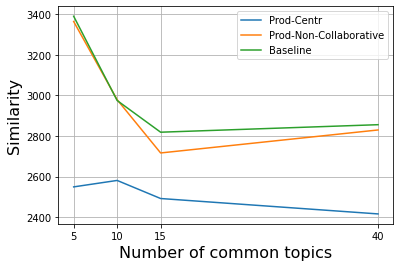

In [21]:
plt.plot(frozen_topics_list, sim_thetas_centralized, label="Prod-Centr")
plt.plot(frozen_topics_list, sim_thetas_non_colab, label="Prod-Non-Collaborative")
plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Similarity', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()